# Time series data science project

- **Chess players patterns discovery and analysis**
- **ariel-zil**

## Part 3 : classifier

In this section we will use the best clustering result from previous section to create a classifer that predicts skill changes after 3 months based on 9 months games

## 1. Imports

#### 1.1. Import packages

In [2]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from collections import Counter
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import RFE

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns  
from datetime import datetime, timezone
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
filterwarnings("ignore")


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = 10,6
base_color = sb.color_palette()[0]


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 


filterwarnings("ignore")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b52e81200e0>
Traceback (most recent call last):
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribut

#### 1.2. enviroment variables loading

In [3]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))
FICS_MIN_YEAR=int(os.getenv('FICS_MIN_YEAR'))
FICS_MAX_YEAR=int(os.getenv('FICS_MAX_YEAR'))
MAX_K=int(os.getenv('MAX_K'))

#### 1.3. Load dataset

In [4]:
df_interval=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-players-interval-90-euclidan-cluster.csv")
df_interval["Label"]=df_interval["EuclidanClusterSSID"]
df_interval=df_interval.drop("EuclidanClusterSSID",axis=1)
df_interval=df_interval.drop("EuclidanClusterMMID",axis=1)
df_interval.index=df_interval["Unnamed: 0"]
df_interval=df_interval.drop("Unnamed: 0",axis=1)

#### 1.4. Methods

In [5]:
def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['Label'], test['Label']
    X_train, X_test = train.drop('Label', axis=1), test.drop('Label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    display( RocCurveDisplay.from_estimator(model, X_test, y_test))
    plt.show()
    try:
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    except Exception as err:
        pass
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }

def rfe(df,test_size,n_features_to_select,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['Label'], test['Label']
    X_train, X_test = train.drop('Label', axis=1), test.drop('Label', axis=1)
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)  # Adjust n_features_to_select as needed
    # Fit RFE
    rfe.fit(X_train, y_train)

    # Boolean mask of selected features
    selected_features = rfe.support_

    # Ranking of features, where 1 means selected
    feature_ranking = rfe.ranking_

    print("Model name:",name)
    print("selected_features:",selected_features)
    print("feature_ranking:",feature_ranking)
    return {
        'model':model,
        'selected_features':selected_features,
        'feature_ranking':feature_ranking,
        'name':name
           }

In [6]:
def label_trend(labels):

    mapping={
        0:"=",1:"-",2:"+",3:"-",4:"-",5:"+",
        6:"-",7:"-",8:"+",9:"=",10:"-",11:"+",
        12:"+",13:"-",14:"+",15:"+",16:"=",17:"=",
        18:"-",19:"=",20:"-",21:"+",22:"-",23:"=",
        24:"-",25:"+",26:"-",27:"-",28:"+",29:"=",
        30:"+",31:"-",32:"+",33:"-",34:"+",35:"=",
        36:"+",
    }
    return [mapping[l] for l in labels]
def choose_positive(labels):
    mapping={
        "=":0,
        "-":0,
        "+":1,
    }
    return [mapping[l] for l in labels]
def choose_negative(labels):
    mapping={
        "=":0,
        "-":1,
        "+":0,
    }
    return [mapping[l] for l in labels]

In [7]:
def get_models():
   return [
    {"name":"decision tree","model":DecisionTreeClassifier(random_state=42)},
    {"name":"Gaussian Naive Bayes","model":GaussianNB()},
    {"name":"KNeighborsClassifier","model":KNeighborsClassifier(2)},
    {"name":"AdaBoostClassifier","model":AdaBoostClassifier()},
    {"name":"CatBoostClassifier","model":CatBoostClassifier()},
    {"name":"XGBClassifier","model":XGBClassifier()},
    {"name":"LGBMClassifier","model":LGBMClassifier()},
    {"name":"logistic regression","model":LogisticRegression()},
    {"name":"Support vector machine","model":SVC(probability =True)},
    {"name":"basic random forrest","model":RandomForestClassifier(n_estimators=100, random_state=42)}
    ]

In [8]:
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])
    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    print(model_score)


In [9]:
from  tsfresh.feature_extraction.feature_calculators import kurtosis
from scipy.stats import skew
from tsfresh.feature_extraction.feature_calculators import mean_abs_change
from scipy.stats import shapiro

def get_feature_df(df):
    return pd.DataFrame.from_dict({
        "Player":[list(df["Player"])[0]],
        "mean":np.mean(list(df["Elo"])),
        "var":np.var(list(df["Elo"])),
        "kurtosis":skew(list(df["Elo"])),
        "skew":skew(list(df["Elo"])),
        "min":min(list(df["Elo"])),
        "max":max(list(df["Elo"])),
    })
def get_extra_feature_df(df):
    return df

def get_samples(df,max_date):
    groups={g:data for g,data in df.groupby("Player")}

    samples={"Player":list(groups.keys())}
    num_samples=0
    for k,v in groups.items():
        num_samples=max(num_samples,len(v[pd.to_datetime(v["Date"])<max_date]))
    
    for k,v in groups.items():
        r=list(v.sort_values(by="FICSGamesDBGameNo")["Elo"])
        for i in range(num_samples):
            try:
                samples[i]=samples.get(i,[])
                samples[i].append(r[i])
            except Exception as err:    
                samples[i].append(-1)
    return pd.DataFrame.from_dict(samples)


CudaAPIError: [999] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_UNKNOWN

In [ ]:

def get_features_per_player(players,max_date,df,extra_df):
    df_f=df[pd.to_datetime(df["Date"])<max_date]
    df_f=df_f[df_f["Player"].isin(players)]
    groups=df_f.groupby("Player")
    groups_d={p:groups.get_group(p) for p in players}
    frames=[]
    for p in players:
        frames.append(get_feature_df(groups_d.get(p)))
    
    return pd.concat(frames)


In [10]:

def get_game_ids(players,max_date,df):
    df_f=df[pd.to_datetime(df["Date"])<max_date]
    df_f=df_f[df_f["Player"].isin(players)]
    groups=df_f.groupby("Player")
    groups_d={p:groups.get_group(p) for p in players}
    ids=[]
    for p in players:
        for game_id in list((groups_d.get(p)["FICSGamesDBGameNo"])):
            ids.append(game_id)
    
    return ids


In [ ]:
def get_extra_details_features(players,extra_df):
    features={
        "Player":[],
        "ECO_A":[],
        "ECO_B":[],
        "ECO_C":[],
        "ECO_D":[],
        "ECO_E":[],
        "PlyCountMean":[],
        "PlyCountVar":[],
        "PlyCountSkew":[],
        "TotalGames":[],
        "EloDiff_1/3_mean":[],
        "EloDiff_2/3_mean":[],
        "EloDiff_3/3_mean":[],
        "EloDiff_mean":[],
        "EloDiff_1/3_time_mean":[],
        "EloDiff_2/3_time_mean":[],
        "EloDiff_3/3_time_mean":[],
        "total_games_1/3_time_mean":[],
        "total_games_2/3_time_mean":[],
        "total_games_3/3_time_mean":[],
    }
    for p in tqdm(players):
        try:
            curr_w=extra_df.groupby("White").get_group(p)
        except Exception as err:
            curr_w=None

        try:
            curr_b=extra_df.groupby("Black").get_group(p)
        except Exception as err:
            curr_b=None

        if curr_w is None and curr_b is not None:
            curr=curr_b
        elif curr_b is None and curr_w is not None:
            curr=curr_w
        else:    
            curr=pd.concat([curr_w,curr_b])
            
        eco=dict(Counter(list(curr["ECO"].apply(lambda m:m[0]))))
        total_eco=sum(eco.values())
        for k in ["A","B","C","D","E"]:
            features[f"ECO_{k}"].append(100*(eco.get(k,0)/total_eco))

        features["Player"].append(p)
        features["PlyCountMean"].append(np.mean(curr["PlyCount"]))
        features["PlyCountVar"].append(np.var(curr["PlyCount"]))
        features["PlyCountSkew"].append(skew(curr["PlyCount"]))
        features["TotalGames"].append(len(curr))
        all_elo_diff=list(curr["EloDiff"])
        total=len(all_elo_diff)
        p1=int(total/3)
        p2=int(2*total/3)
        p3=total

        features["EloDiff_1/3_mean"].append(np.mean([all_elo_diff[i] for i in range(0,p1)]))
        features["EloDiff_2/3_mean"].append(np.mean([all_elo_diff[i] for i in range(p1,p2)]))
        features["EloDiff_3/3_mean"].append(np.mean([all_elo_diff[i] for i in range(p2,p3)]))
        features["EloDiff_mean"].append(np.mean(all_elo_diff))

        date_1=pd.to_datetime([f'{2018}-03-01 00:00:00']).min()
        date_2=pd.to_datetime([f'{2018}-06-01 00:00:00']).min()
        date_3=pd.to_datetime([f'{2018}-09-01 00:00:00']).min()
        features["EloDiff_1/3_time_mean"].append(np.mean(curr[(pd.to_datetime(curr["Date"])<date_1)]["EloDiff"]))
        features["EloDiff_2/3_time_mean"].append(np.mean(curr[(pd.to_datetime(curr["Date"])>=date_1)&
                                                              (pd.to_datetime(curr["Date"])<date_2)
                                                              ]["EloDiff"]))
        features["EloDiff_3/3_time_mean"].append(np.mean(curr[(pd.to_datetime(curr["Date"])>=date_2)&
                                                              (pd.to_datetime(curr["Date"])<date_3)
                                                              ]["EloDiff"]))

        features["total_games_1/3_time_mean"].append(len(curr[(pd.to_datetime(curr["Date"])<date_1)]["EloDiff"]))
        features["total_games_2/3_time_mean"].append(len(curr[(pd.to_datetime(curr["Date"])>=date_1)&
                                                              (pd.to_datetime(curr["Date"])<date_2)
                                                              ]["EloDiff"]))
        features["total_games_3/3_time_mean"].append(len(curr[(pd.to_datetime(curr["Date"])>=date_2)&
                                                              (pd.to_datetime(curr["Date"])<date_3)
                                                              ]["EloDiff"]))

    df= pd.DataFrame.from_dict(features)
    df.index=list(df["Player"])
    df=df.drop(columns=["Player"])
    return df


## 2. clasification of improving pattern

### 2.1. using samples as interval (take 9 months and predict results after another 3 months)

In [27]:
df_interval["Label"]=choose_positive(label_trend(df_interval["Label"]))
df_interval["Label"].value_counts()

Label
0    3584
1    2415
Name: count, dtype: int64

In [28]:
df_interval.to_csv(f"{PROJECT_PATH}/data/fics/interim/player_labels.csv")

####  2.1.1. *run classification models*

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.7283333333333334
roc_auc_score: 0.7219991075412762
precision_score: 0.6686274509803921
f1_score: 0.6765873015873015


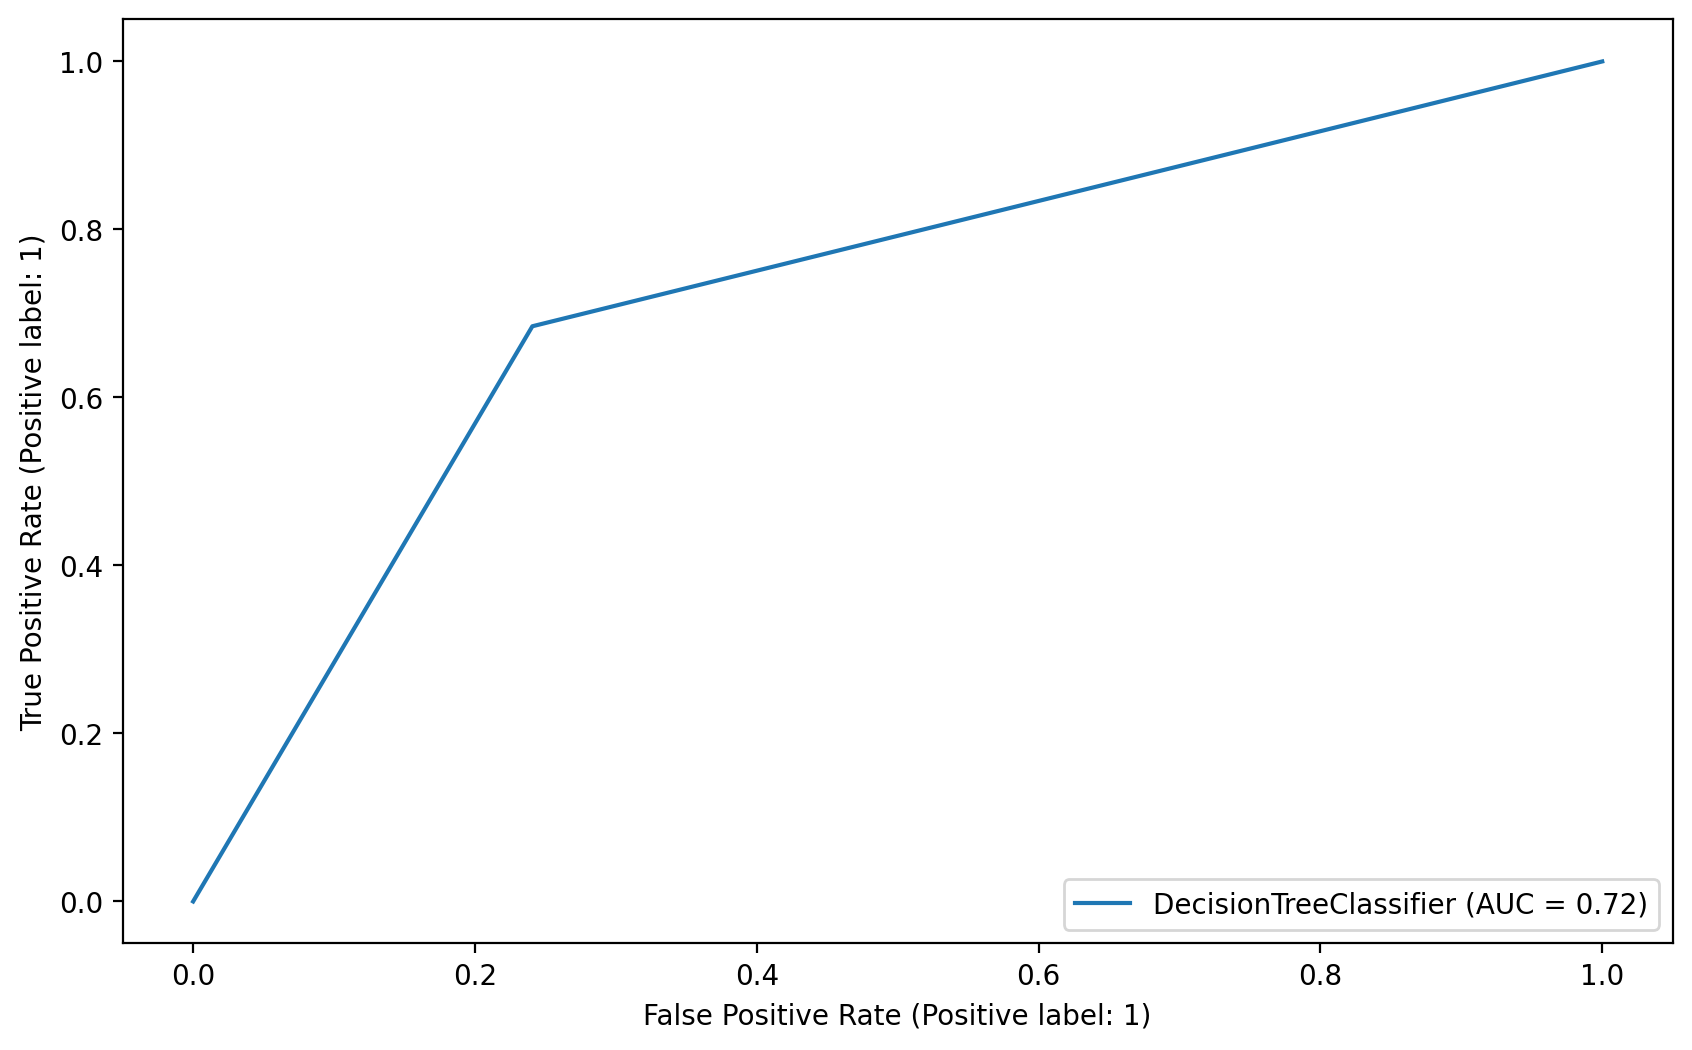

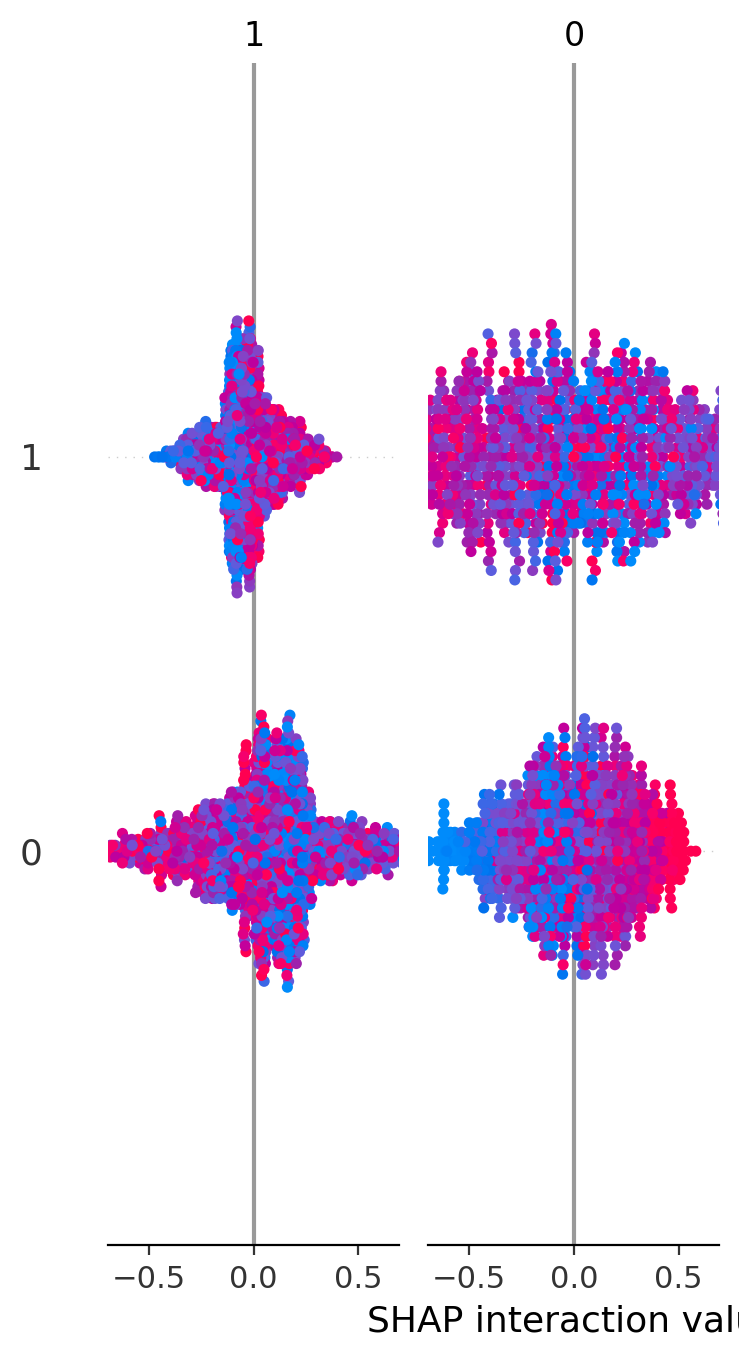

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5975
roc_auc_score: 0.5070287374208943
precision_score: 0.5555555555555556
f1_score: 0.05847953216374269


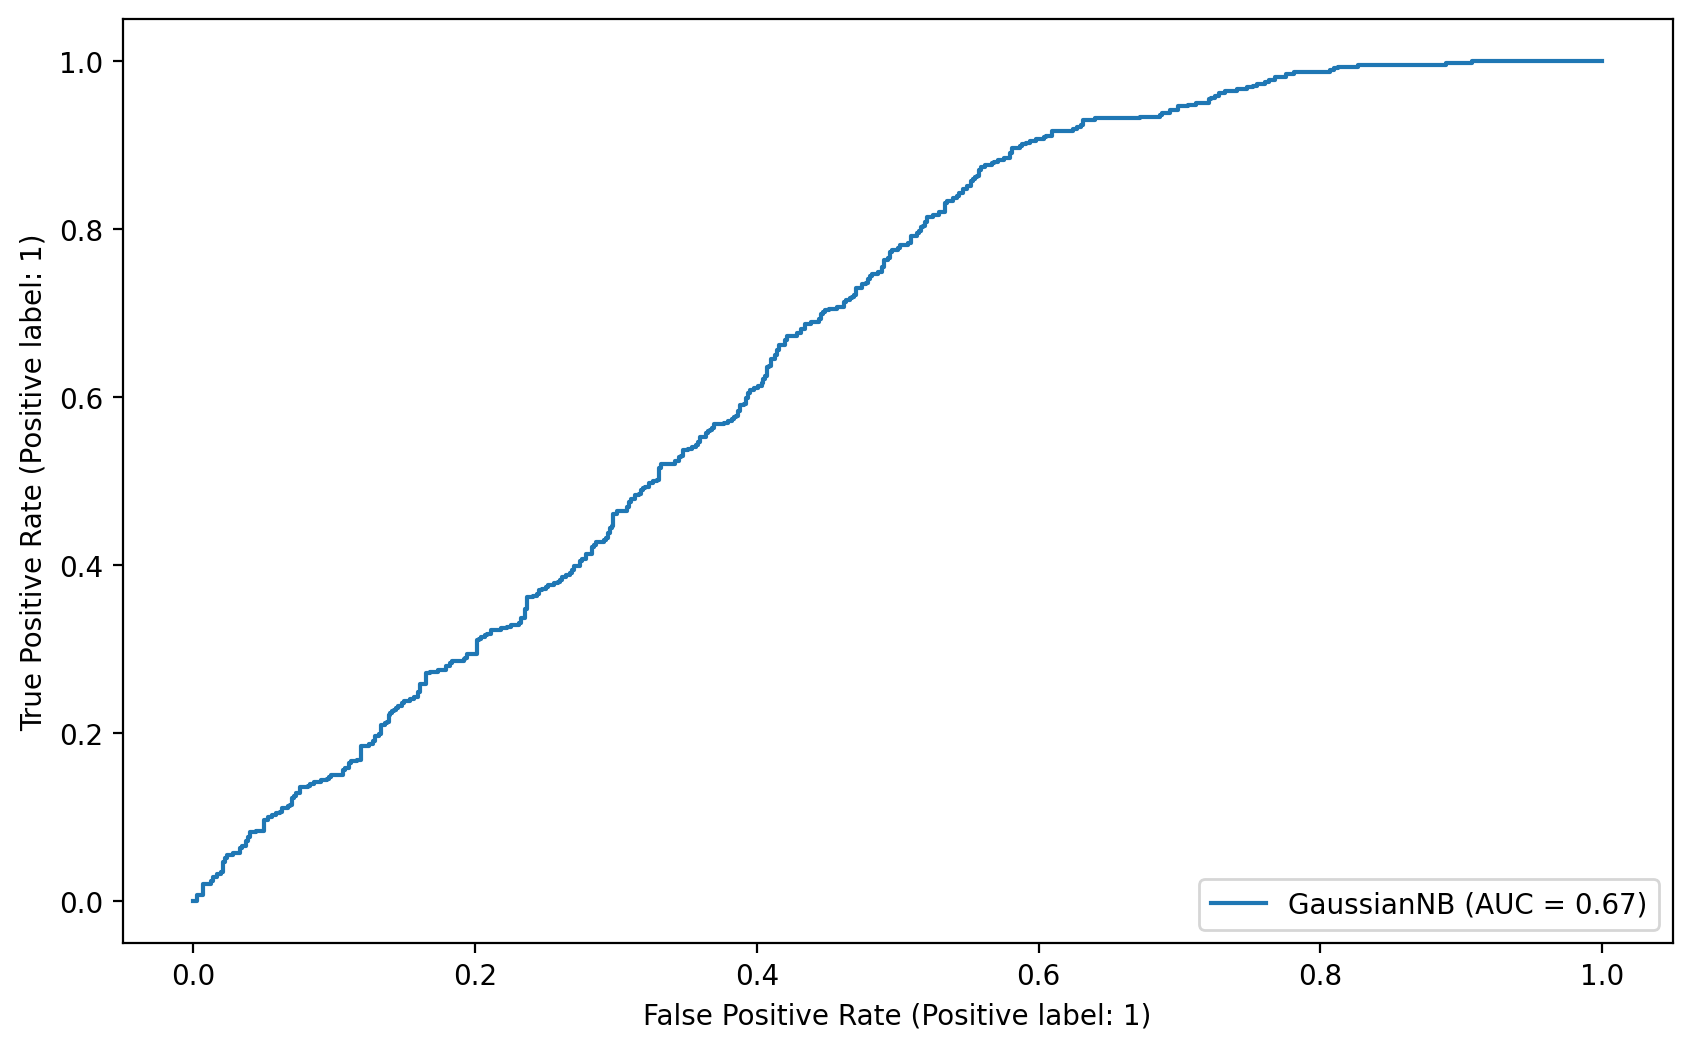

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.74
roc_auc_score: 0.7015799997688369
precision_score: 0.7672955974842768
f1_score: 0.61


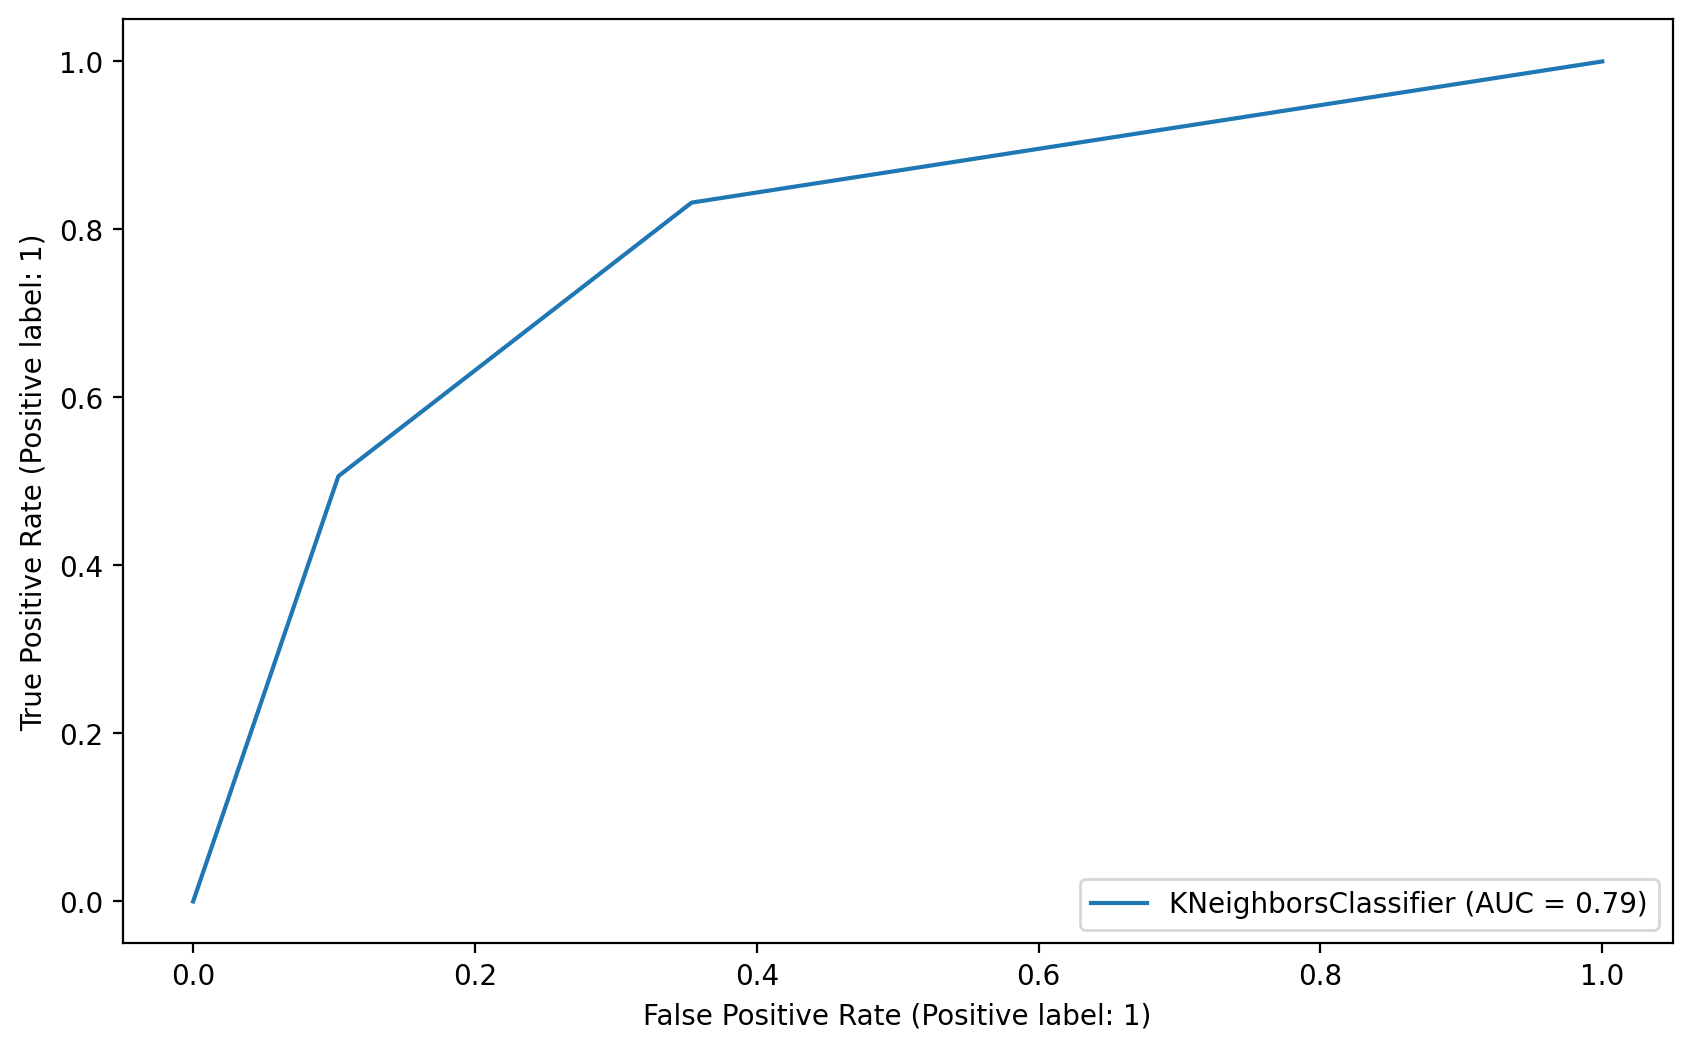

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.7091666666666666
roc_auc_score: 0.6740321534135967
precision_score: 0.7
f1_score: 0.5769696969696969


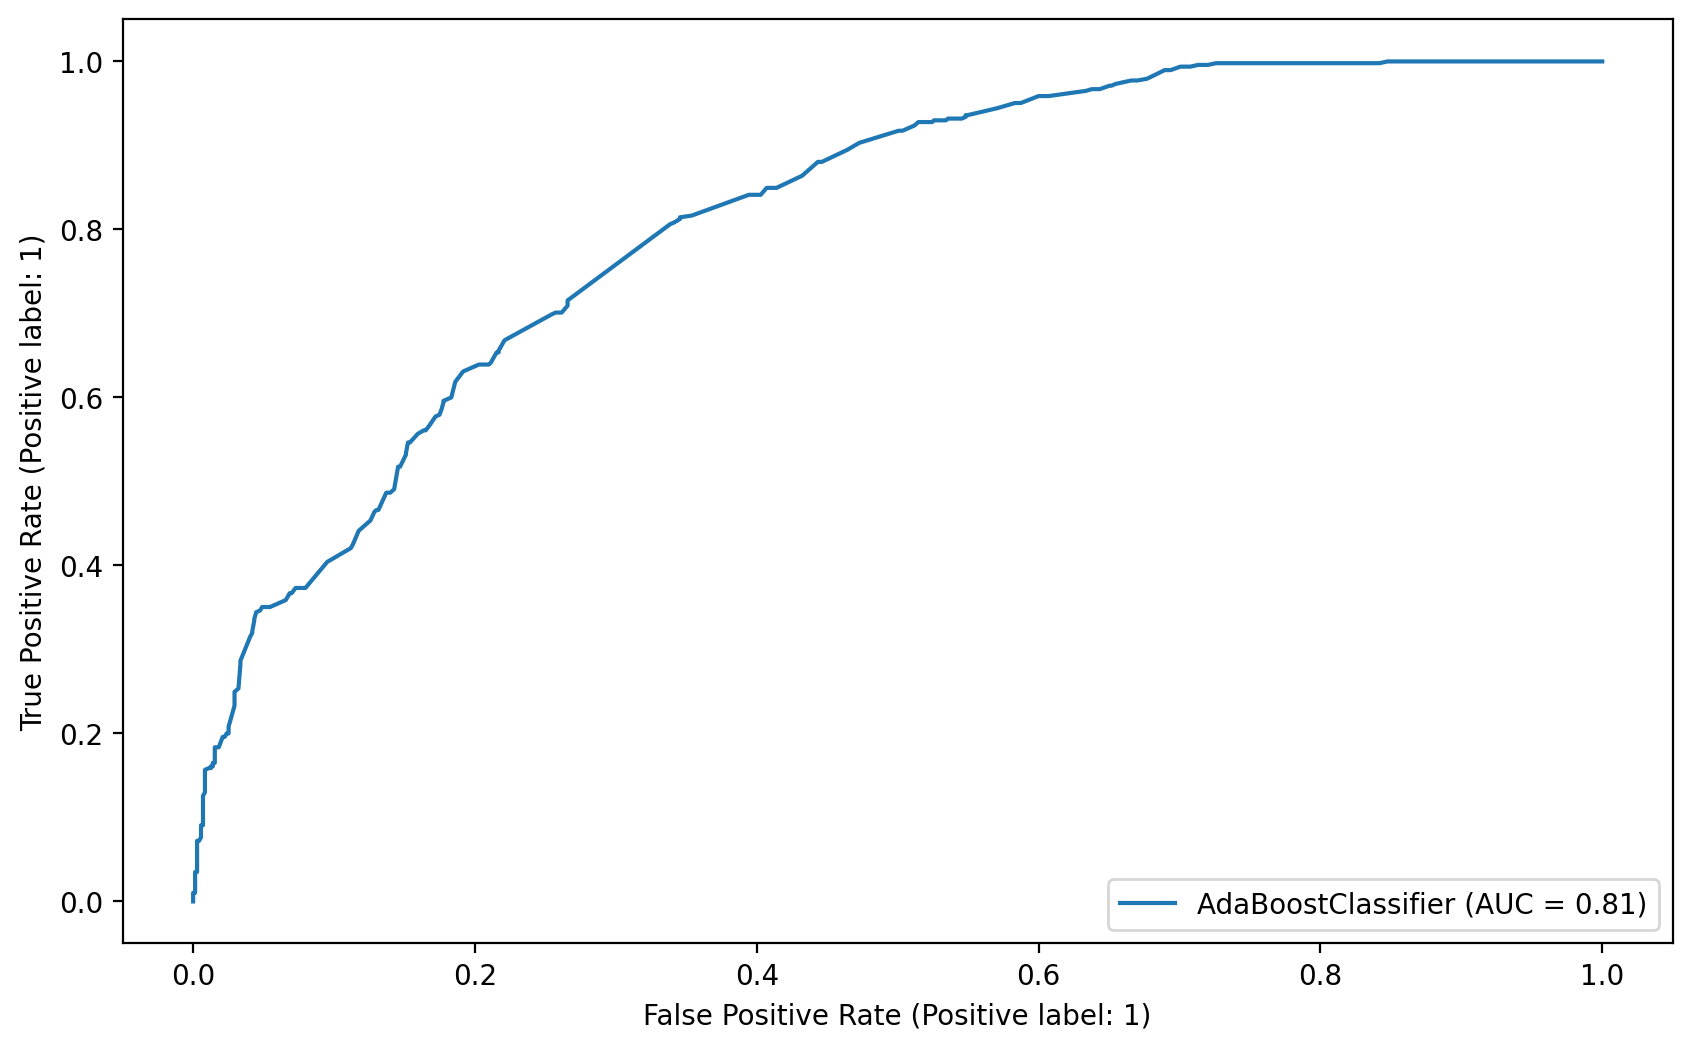

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6890233	total: 47.8ms	remaining: 47.8s
1:	learn: 0.6854083	total: 50.1ms	remaining: 25s
2:	learn: 0.6815897	total: 51.2ms	remaining: 17s
3:	learn: 0.6790876	total: 52.4ms	remaining: 13s
4:	learn: 0.6763557	total: 56.2ms	remaining: 11.2s
5:	learn: 0.6729212	total: 57.5ms	remaining: 9.52s
6:	learn: 0.6704567	total: 58.9ms	remaining: 8.35s
7:	learn: 0.6669924	total: 60ms	remaining: 7.44s
8:	learn: 0.6638291	total: 61ms	remaining: 6.72s
9:	learn: 0.6612310	total: 62ms	remaining: 6.14s
10:	learn: 0.6584976	total: 63.1ms	remaining: 5.67s
11:	learn: 0.6552417	total: 64.1ms	remaining: 5.28s
12:	learn: 0.6523530	total: 65.1ms	remaining: 4.94s
13:	learn: 0.6500071	total: 66.1ms	remaining: 4.66s
14:	learn: 0.6478618	total: 67.3ms	remaining: 4.42s
15:	learn: 0.6455154	total: 68.3ms	remaining: 4.2s
16:	learn: 0.6432084	total: 69.3ms	remai

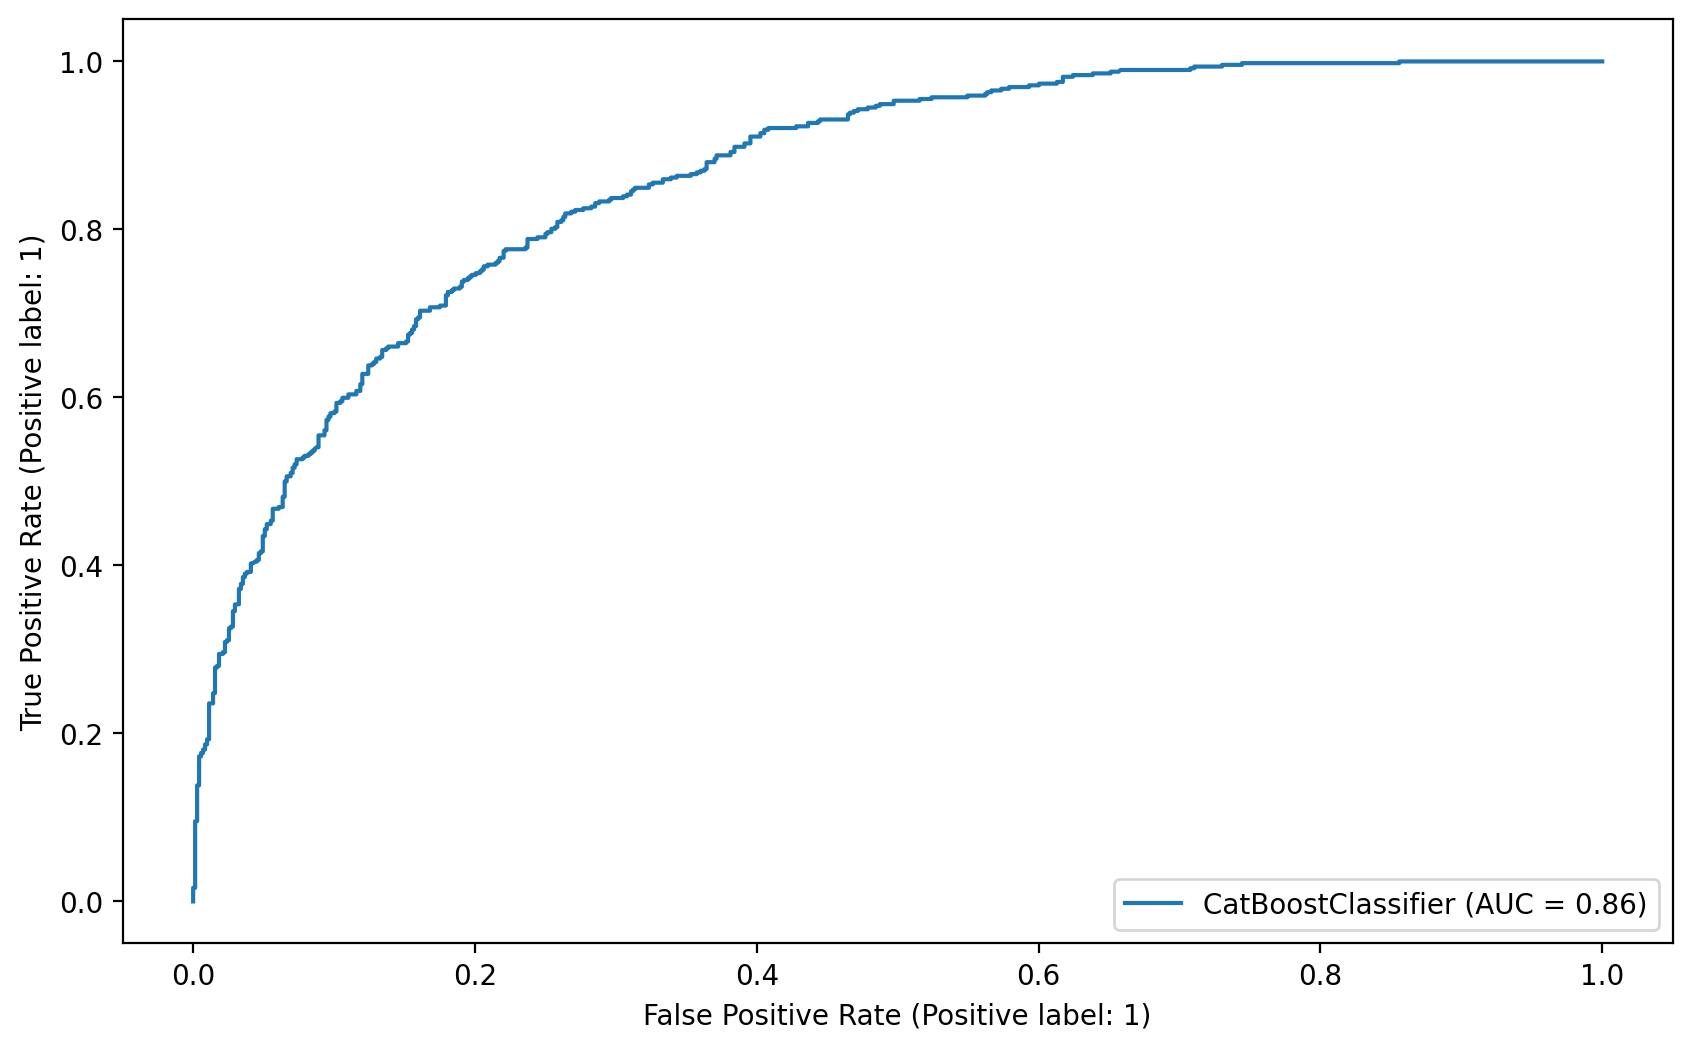

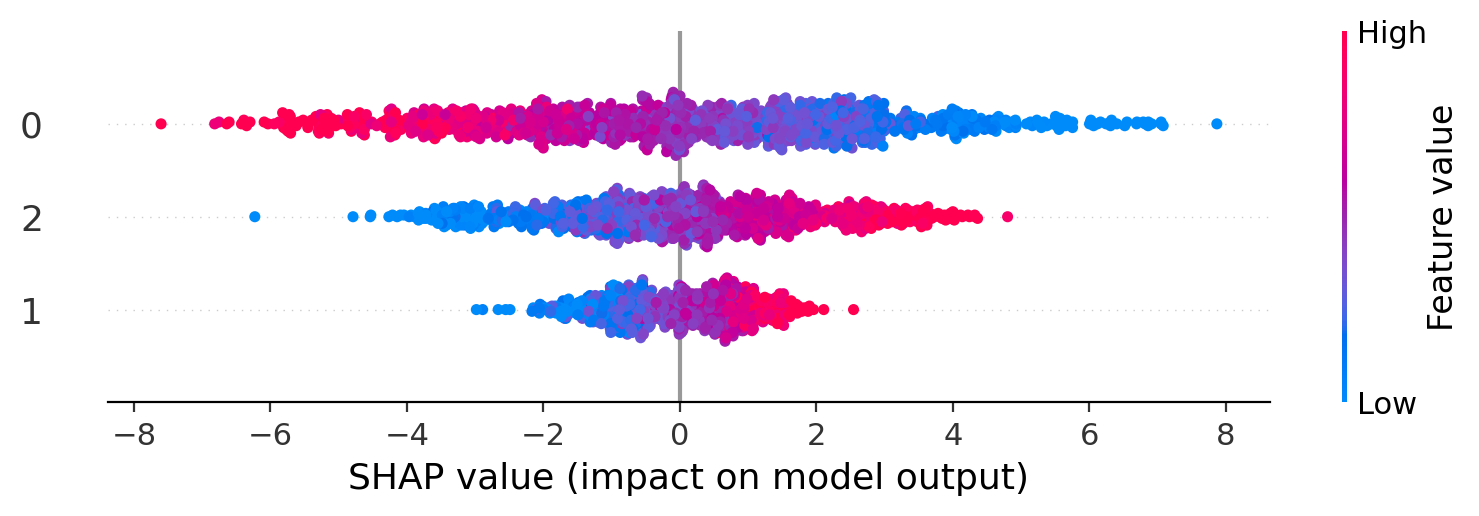

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.7691666666666667
roc_auc_score: 0.7548435127532104
precision_score: 0.6989010989010989
f1_score: 0.696604600219058


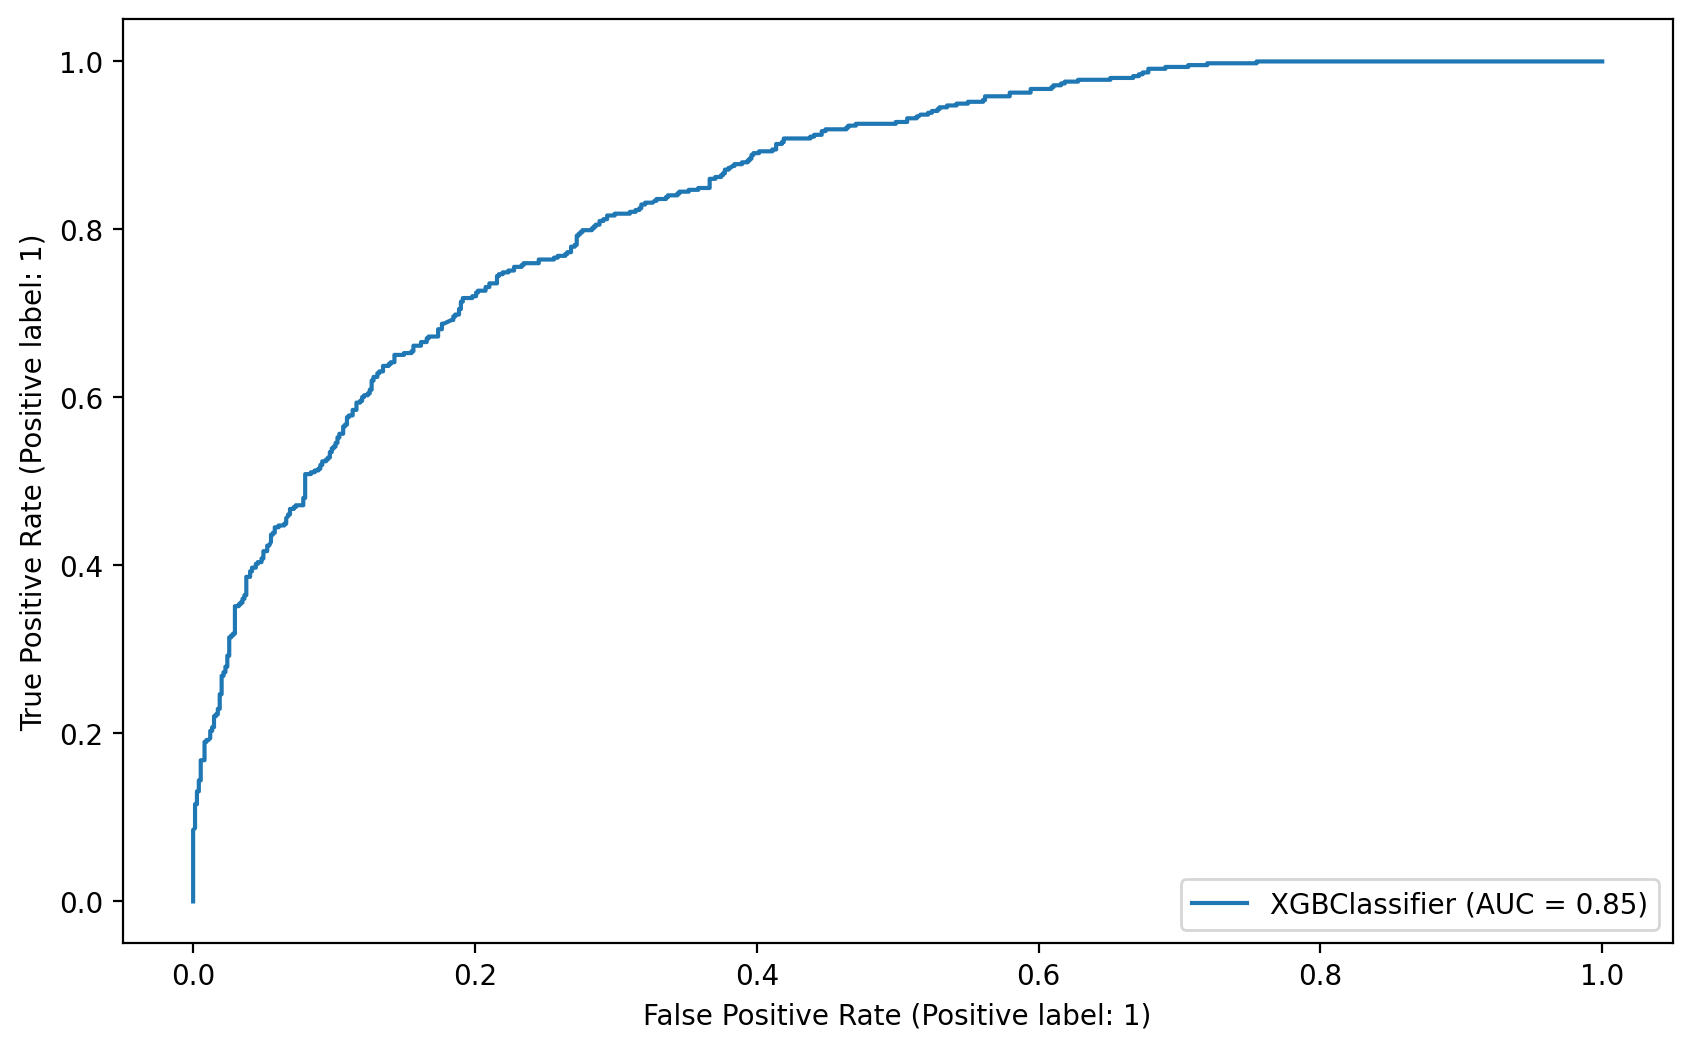

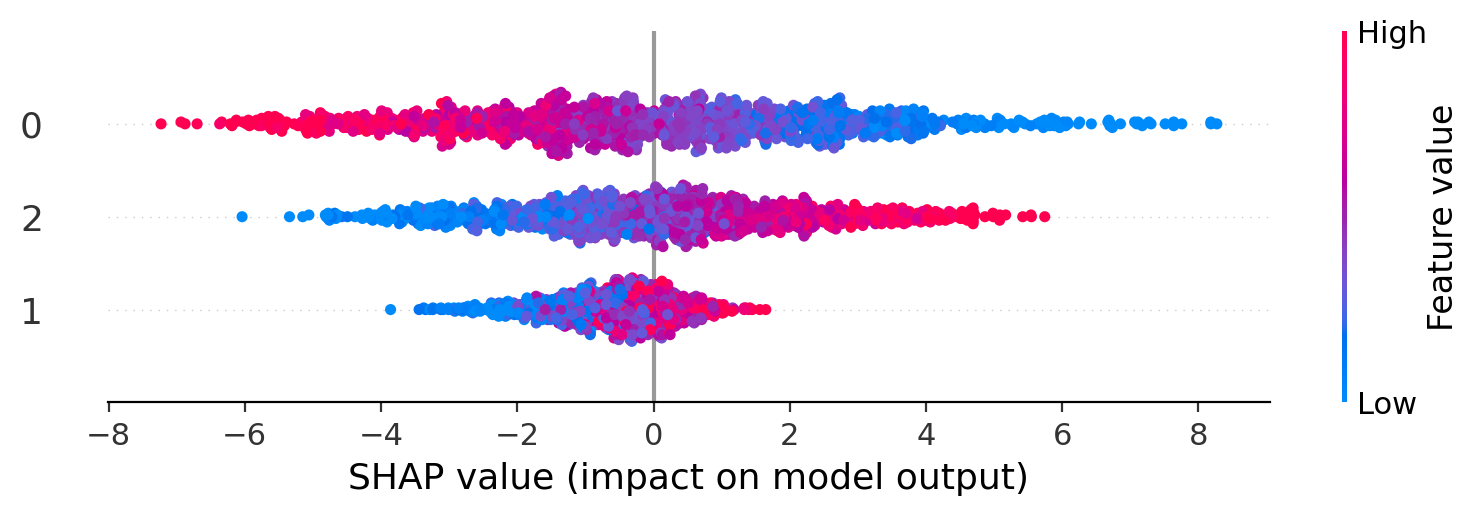

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 1930, number of negative: 2869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402167 -> initscore=-0.396444
[LightGBM] [Info] Start training from score -0.396444
Model name: LGBMClassifier
accuracy_score: 0.79
roc_auc_score: 0.7790065604498595
precision_score: 0.7494646680942184
f1_score: 0.7352941176470588


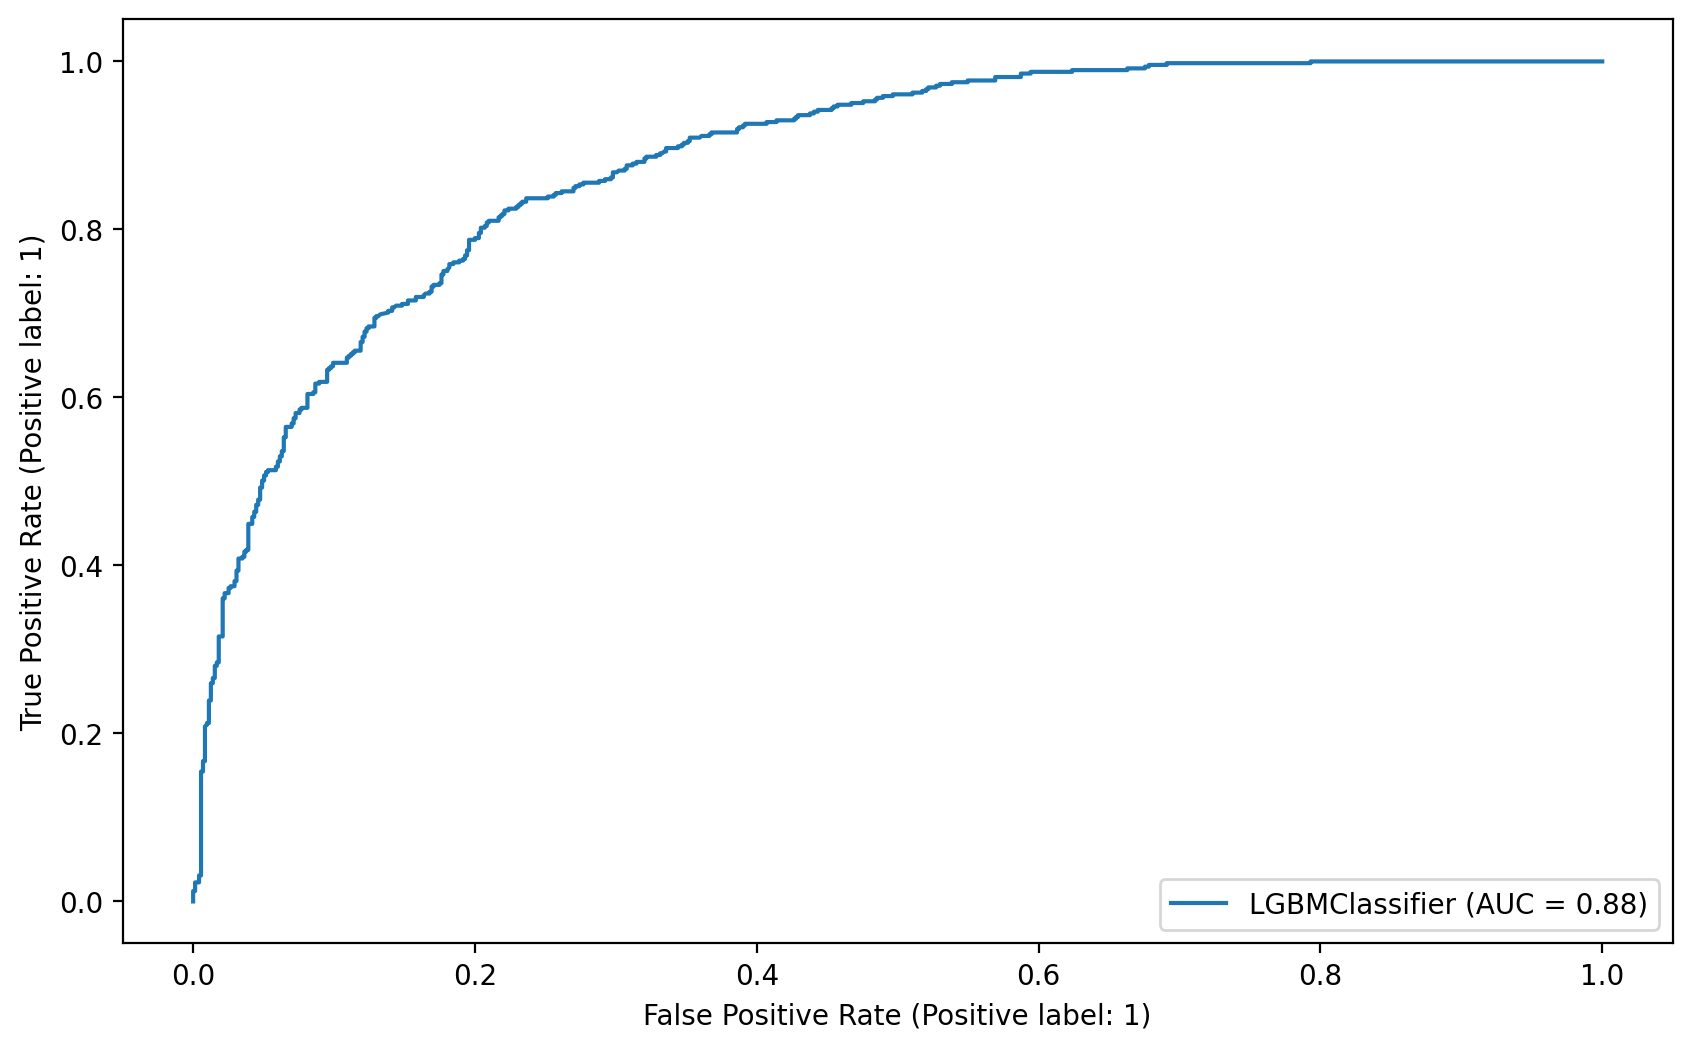

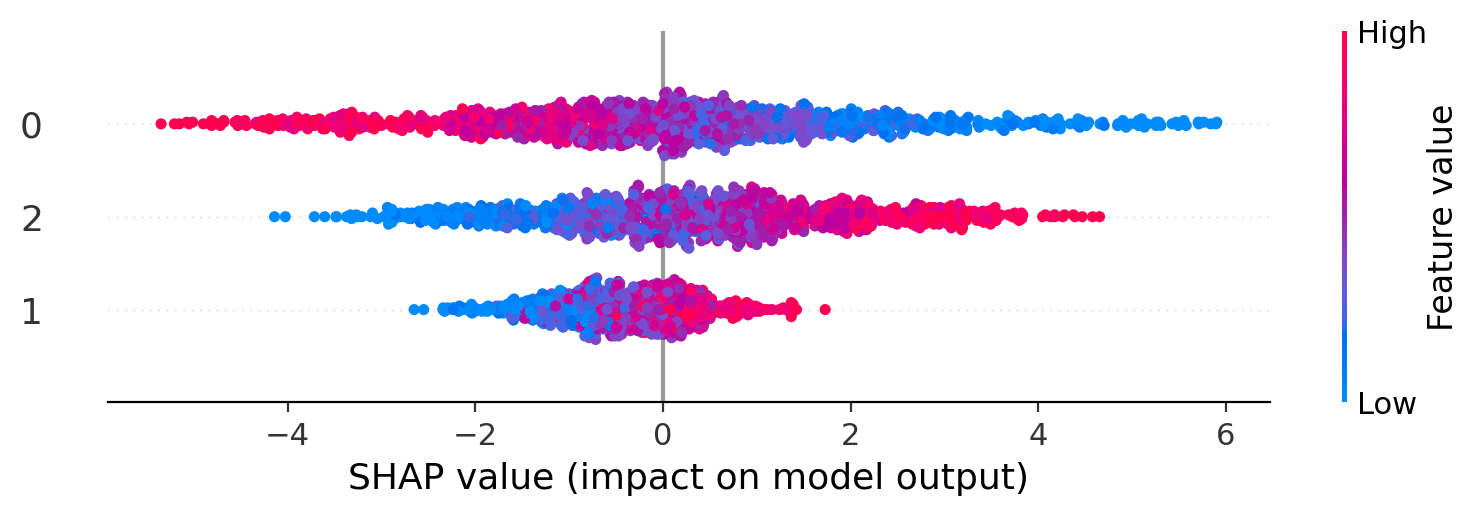

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.7983333333333333
roc_auc_score: 0.7865096655946329
precision_score: 0.7652173913043478
f1_score: 0.744186046511628


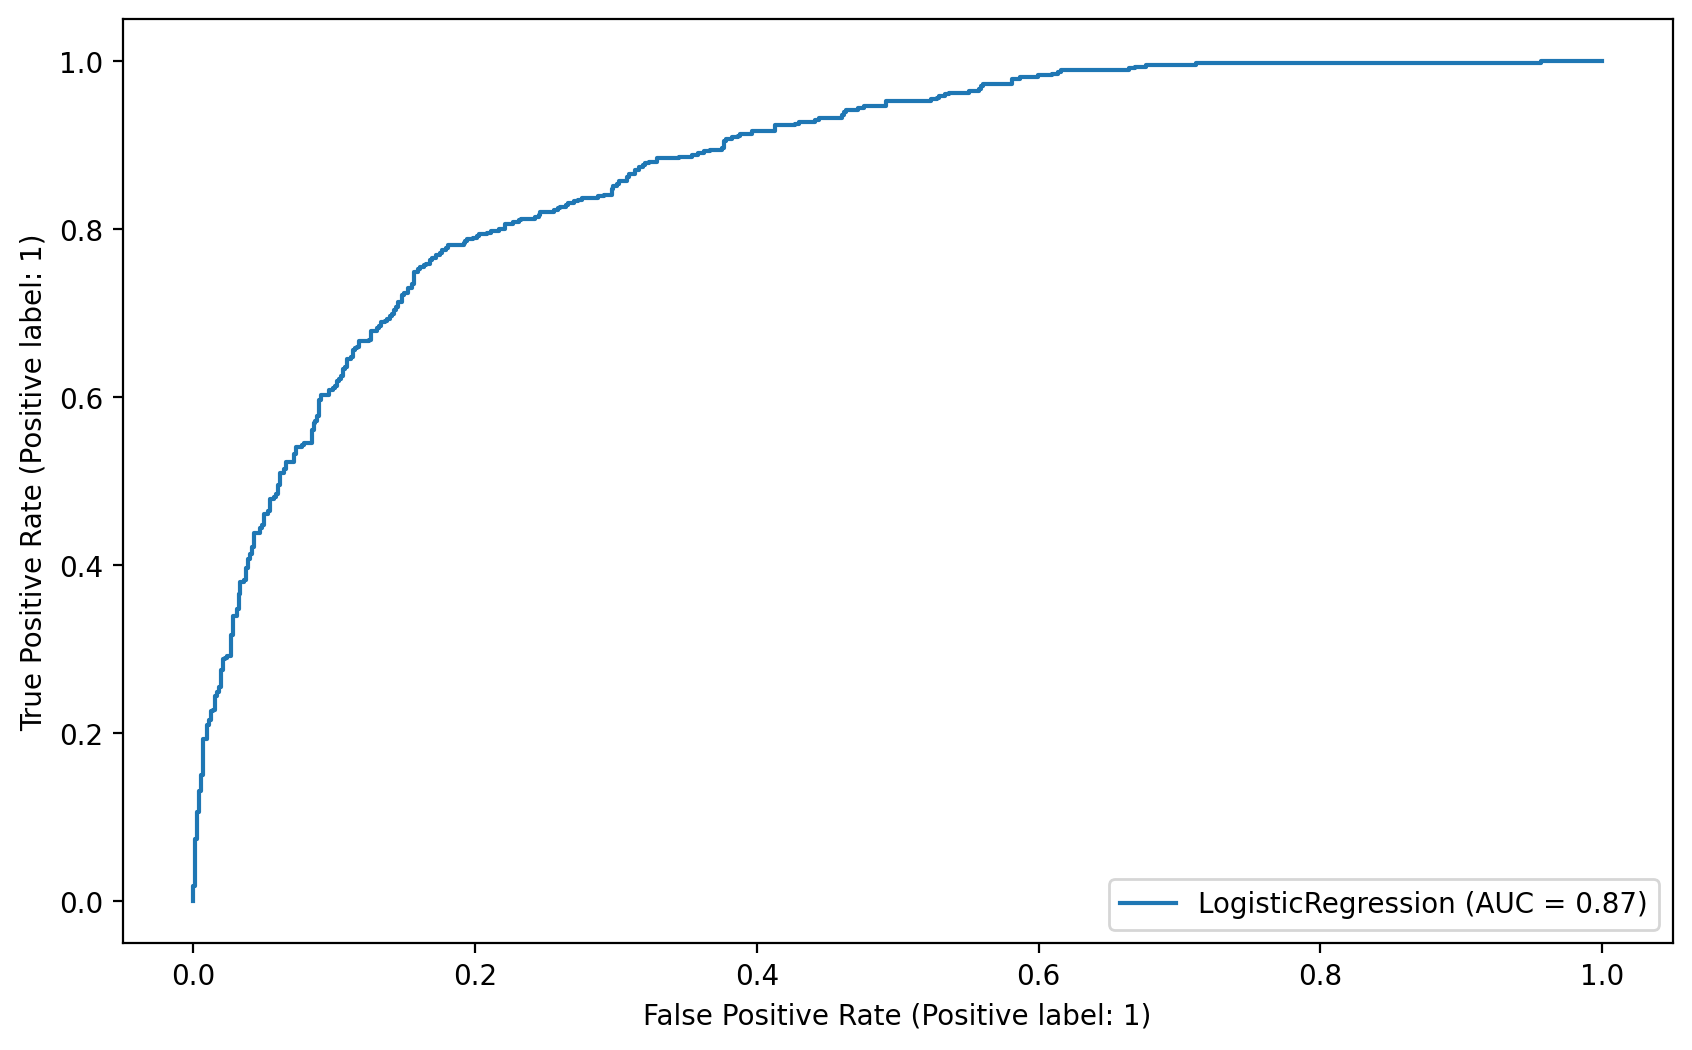

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.7816666666666666
roc_auc_score: 0.7644363602873457
precision_score: 0.7627906976744186
f1_score: 0.7145969498910676


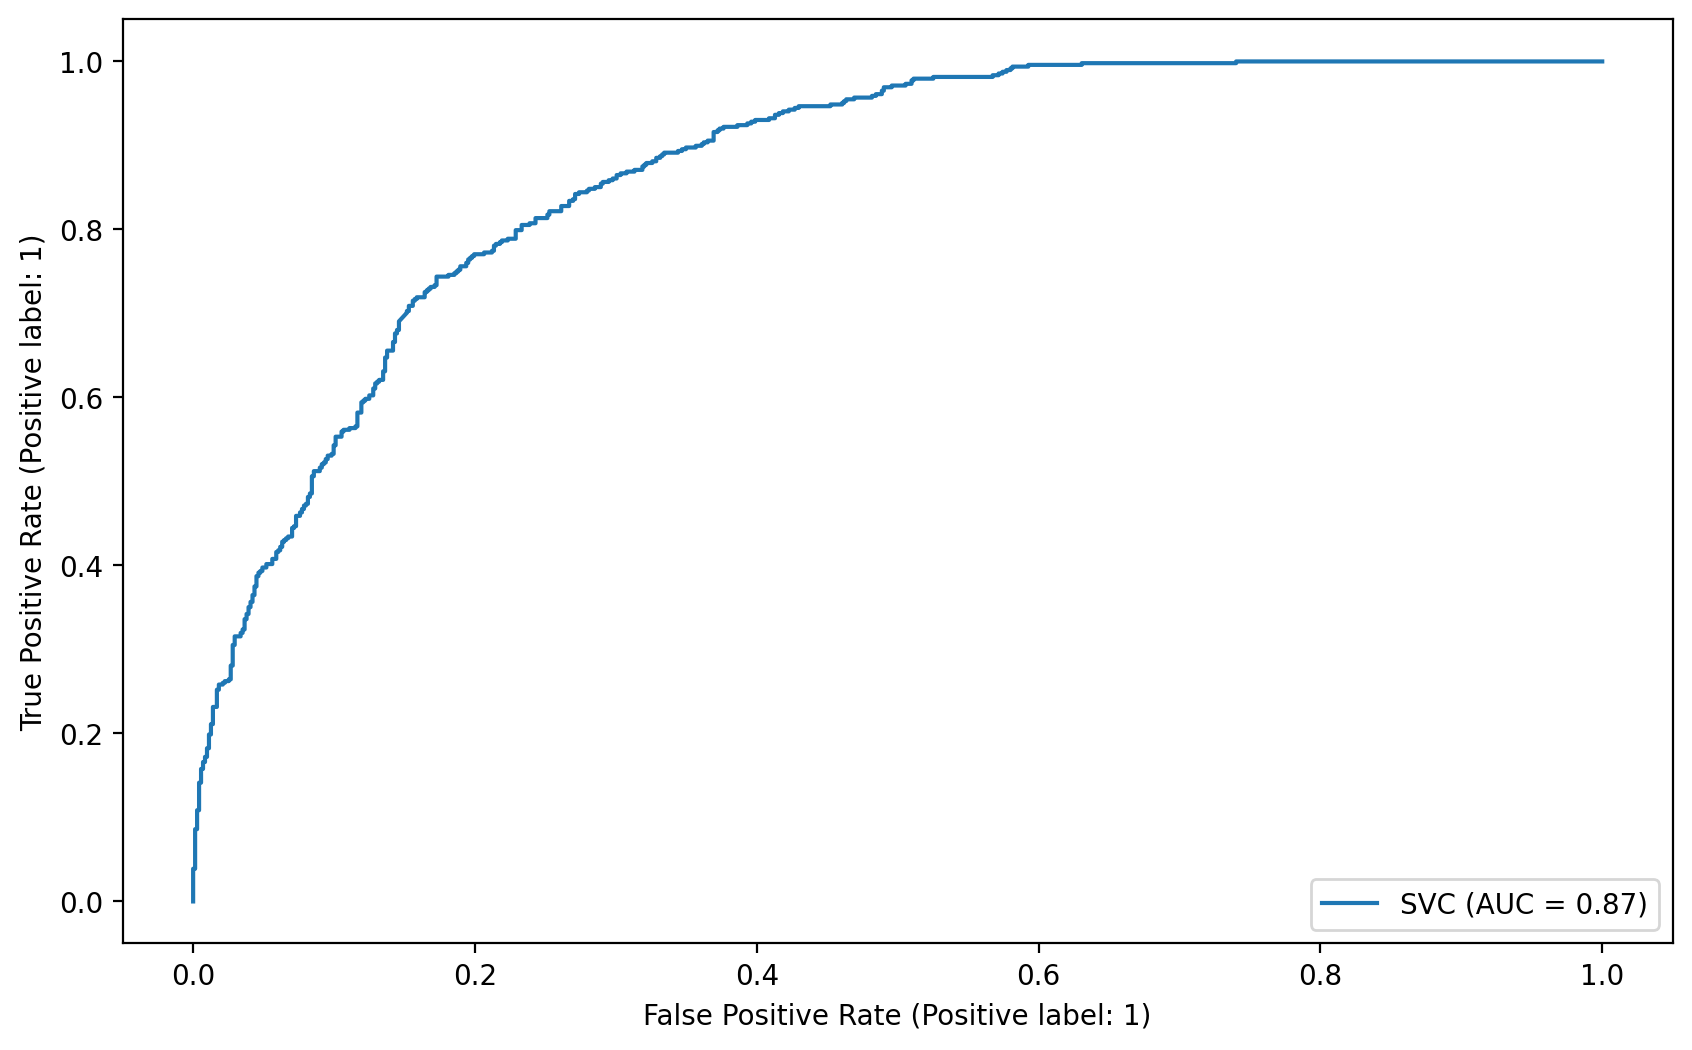

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.79
roc_auc_score: 0.7754239724058638
precision_score: 0.7680180180180181
f1_score: 0.7301927194860814


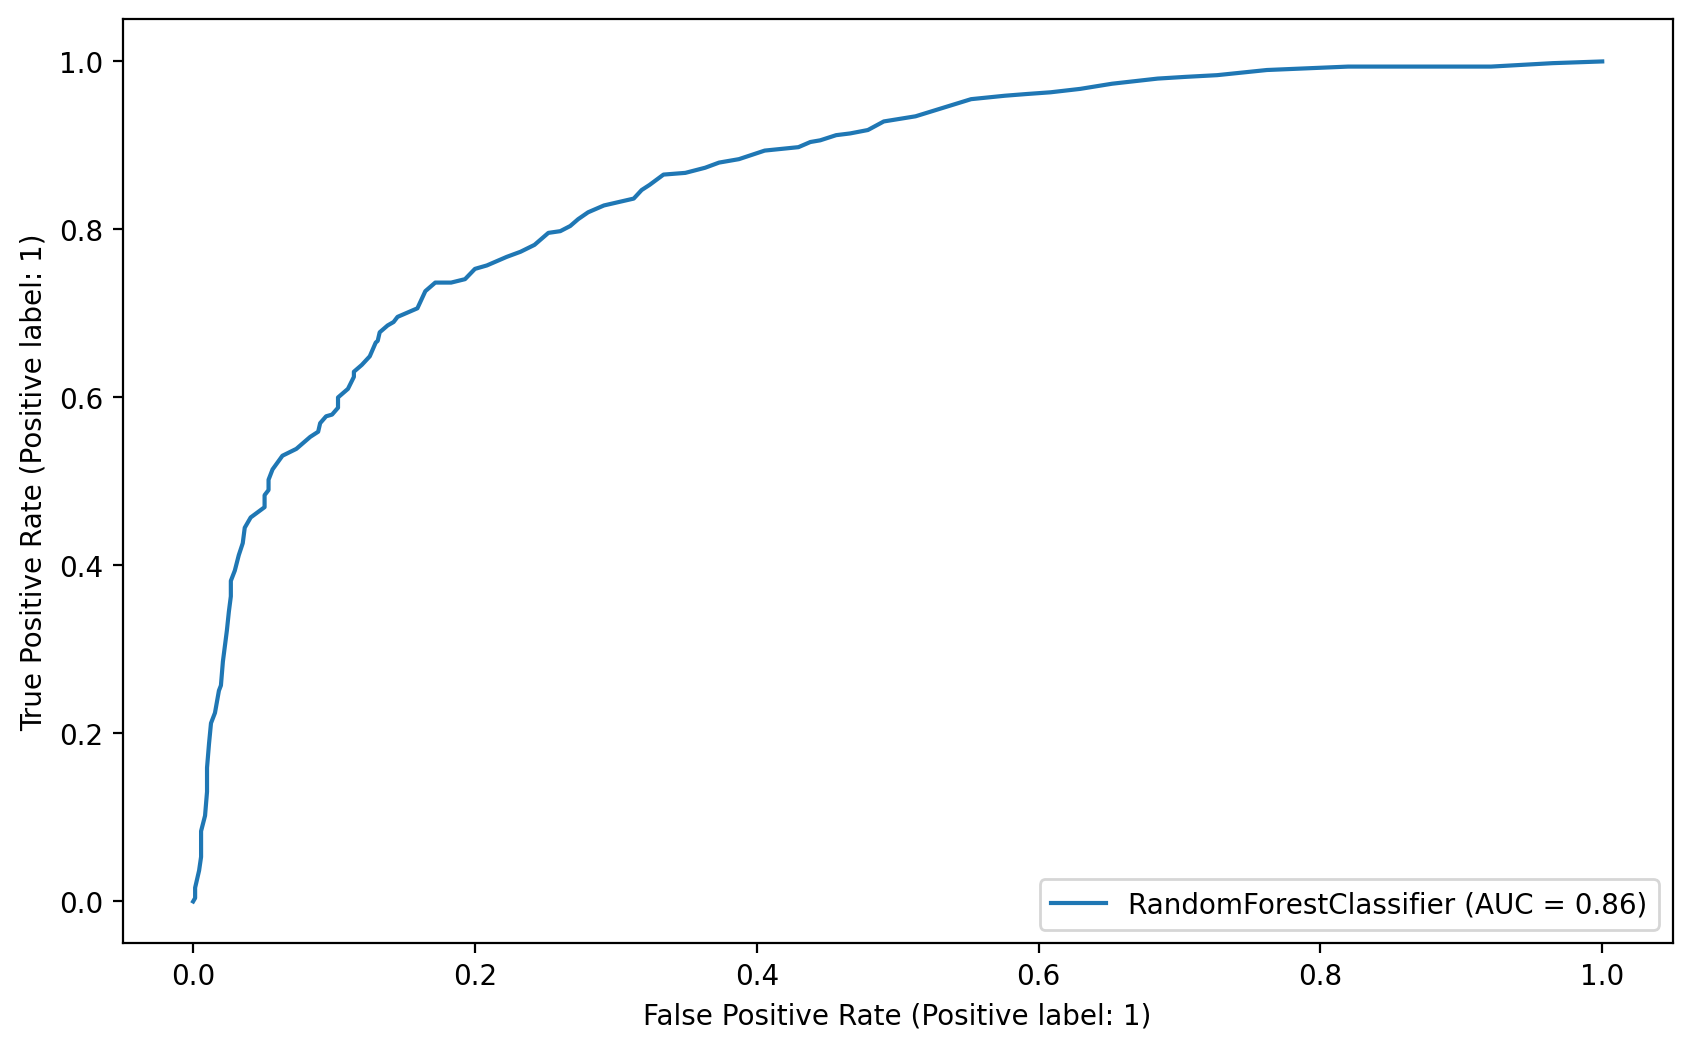

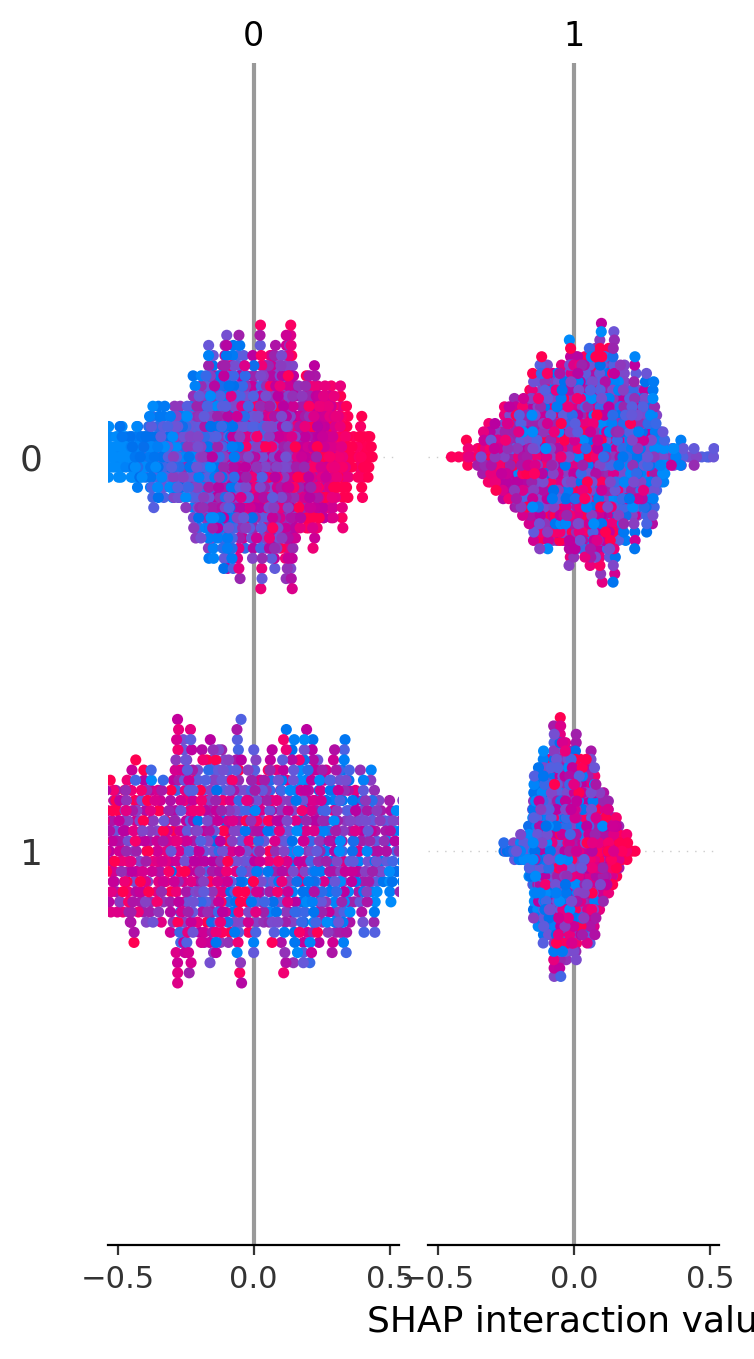

In [29]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(df_interval.drop("3",axis=1),0.2,m["model"],m["name"]))

####  2.1.2. *compare results*

In [30]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
logistic regression       0.7983     0.7652  0.7243  0.7442
LGBMClassifier            0.7900     0.7495  0.7216  0.7353
basic random forrest      0.7900     0.7680  0.6959  0.7302
CatBoostClassifier        0.7800     0.7500  0.6951  0.7215
Support vector machine    0.7817     0.7628  0.6721  0.7146
XGBClassifier             0.7692     0.6989  0.6943  0.6966
decision tree             0.7283     0.6686  0.6847  0.6766
KNeighborsClassifier      0.7400     0.7673  0.5062  0.6100
AdaBoostClassifier        0.7092     0.7000  0.4907  0.5770
Gaussian Naive Bayes      0.5975     0.5556  0.0309  0.0585


### 2.2 using unrealted features
In this section we will try to create classification based on differnt (not ELO) features

### 2.2.1  Prepeare data

In [14]:
frames=[]
for  sample in pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-players.csv",chunksize=1000):
    frames.append(sample[sample["Year"]==2018])

df_2018=pd.concat(frames)
df_2018

Unnamed: 0 Result  FICSGamesDBGameNo         Player   Elo  \
8913            9602   Lost          455492835       rizaisfa  1540   
9630           10382    Tie          450877124        pietroa   828   
15567          16660    Won          450869119           Calx  1621   
17740          18981   Lost          450866229    DixierRebel  1504   
17756          18997    Won          450866210    DixierRebel  1542   
...              ...    ...                ...            ...   ...   
27723453    14408055    Won          434845469       bretteux  1155   
27723454    14408056    Won          434845468          HWPer  1520   
27723455    14408057   Lost          434845467        Jonfern  1676   
27723456    14408058   Lost          434845465  Jesuslovesall  1423   
27723457    14408059    Won          434845462         anzali  1383   

                Opponent  OpponentElo        Date      Time  Year  Month  Day  \
8913             Eldongo         1558  2018.08.31  07:58:00  2018      8   31   
9630              weaker          973  2018.08.19  13:51:00  2018      8   19   
15567        DixierRebel         1514  2018.11.25  16:53:00  2018     11   25   
17740     henkdedenktenk         1487  2018.11.20  07:52:00  2018     11   20   
17756             WASFOX         1542  2018.11.10  15:59:00  2018     11   10   
...                  ...          ...         ...       ...   ...    ...  ...   
27723453        Arembepe         1059  2018.08.09  12:16:00  2018      8    9   
27723454      JonotheRed         1501  2018.08.09  12:12:00  2018      8    9   
27723455       snackking         1621  2018.08.09  12:13:00  2018      8    9   
27723456            alza         1333  2018.08.09  12:14:00  2018      8    9   
27723457    SorryYouLose         1269  2018.08.09  12:11:00  2018      8    9   

          Hour  Minute  Second  
8913         7      58       0  
9630        13      51       0  
15567       16      53       0  
17740        7      52       0  
17756       15      59       0  
...        ...     ...     ...  
27723453    12      16       0  
27723454    12      12       0  
27723455    12      13       0  
27723456    12      14       0  
27723457    12      11       0  

[11355389 rows x 15 columns]

In [33]:
players=df_interval.index

game_ids=get_game_ids(players,pd.to_datetime([f'{2018}-09-01 00:00:00']).min(),df_2018)
with open(f"{PROJECT_PATH}/data/fics/proccessed/players.pkl", 'wb') as f:
    pickle.dump(players, f)
with open(f"{PROJECT_PATH}/data/fics/proccessed/game_ids.pkl", 'wb') as f:
    pickle.dump(game_ids, f)

In [15]:
with open(f"{PROJECT_PATH}/data/fics/proccessed/game_ids.pkl", 'rb') as f:
    game_ids=pickle.load( f)

In [16]:
with open(f"{PROJECT_PATH}/data/fics/proccessed/players.pkl", 'rb') as f:
    players=pickle.load( f)

In [18]:

frames=[]
for  sample in pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-details.csv",chunksize=1000000):
    sample=sample[sample["FICSGamesDBGameNo"].isin(game_ids)]
    sample=sample=sample[(sample["White"].isin(players))|sample["Black"].isin(players)]
    sample=sample.drop(columns=["Unnamed: 0.1","Unnamed: 0"])
    frames.append(sample)

extra_df=pd.concat(frames)

In [ ]:
extra_df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-details-clean-2018.csv")

In [ ]:
parsed_details=get_extra_details_features(players,extra_df)
parsed_details["Label"]=df_interval["Label"]

  0%|          | 0/5999 [00:00<?, ?it/s]

100%|██████████| 5999/5999 [1:07:54<00:00,  1.47it/s]


ValueError: All arrays must be of the same length

In [ ]:
with open(f"{PROJECT_PATH}/data/fics/proccessed/parsed_details.pkl", 'wb') as f:
    pickle.dump(parsed_details, f)

### 2.2.2  Run classification models

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.49583333333333335
roc_auc_score: 0.48987570480670384
precision_score: 0.42
f1_score: 0.43298969072164945


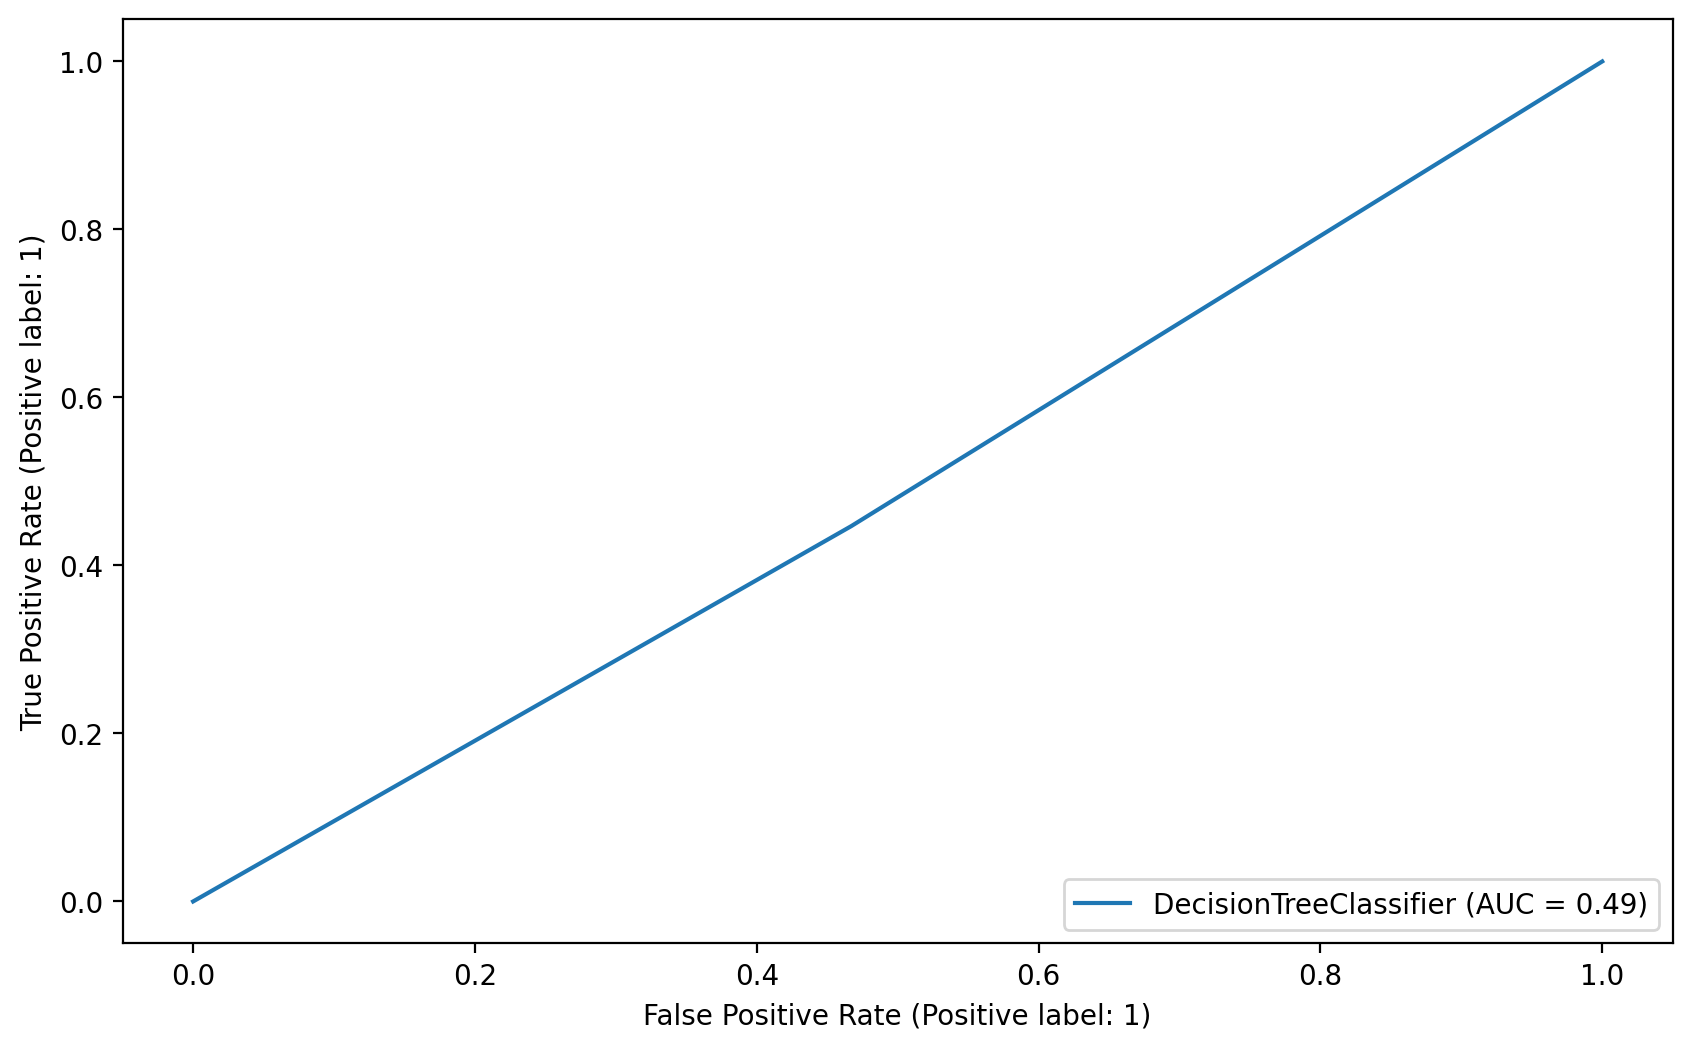

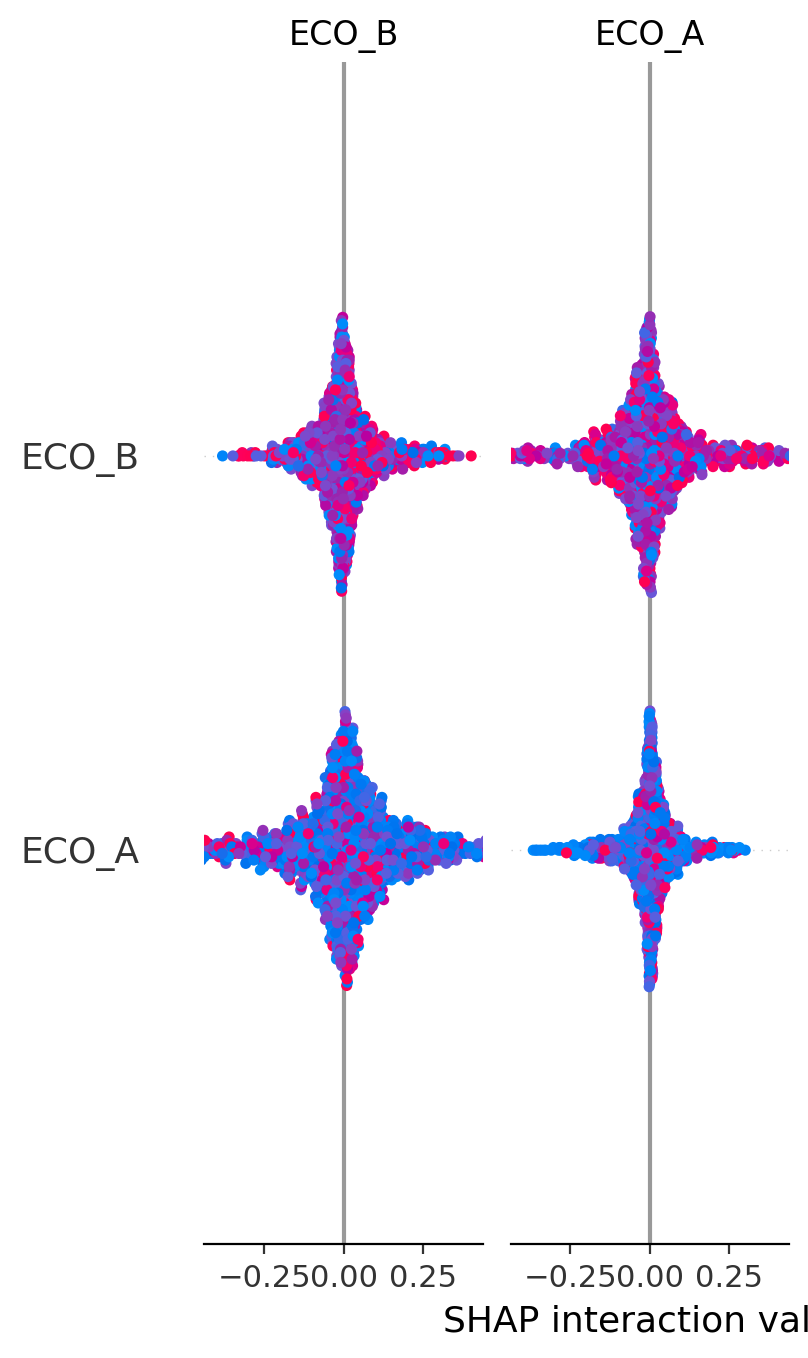

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5533333333333333
roc_auc_score: 0.49347205222358226
precision_score: 0.38636363636363635
f1_score: 0.11258278145695365


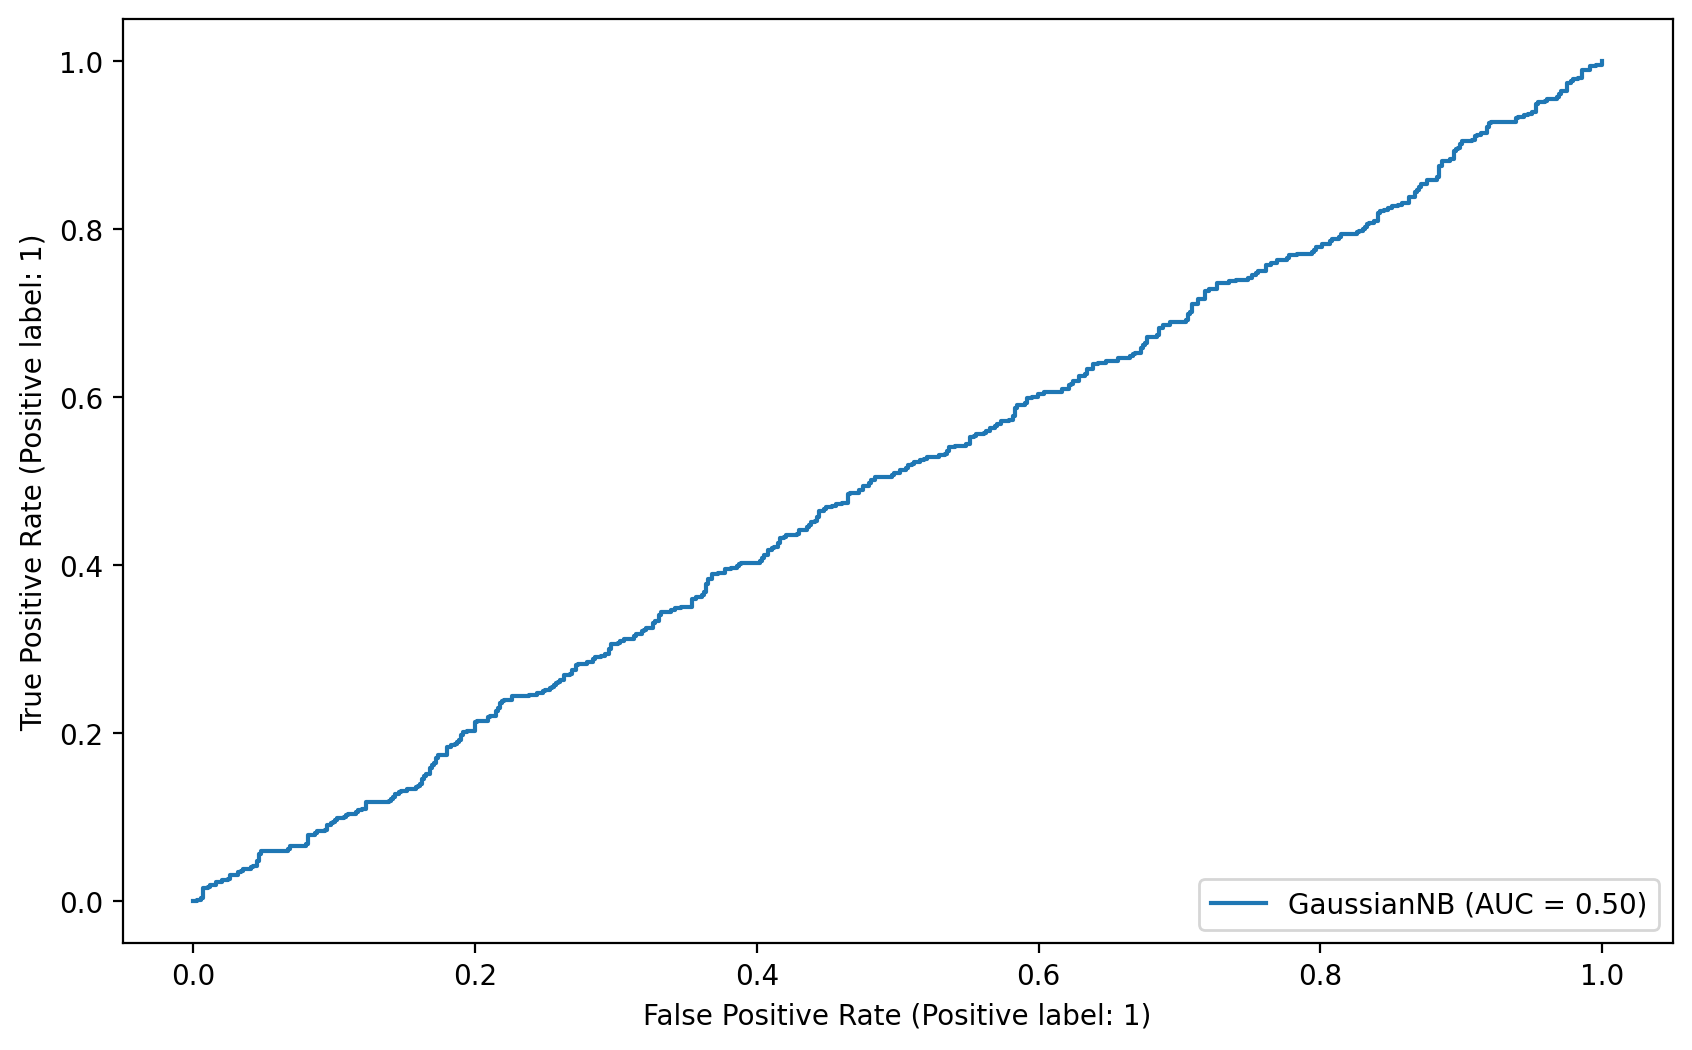

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.5433333333333333
roc_auc_score: 0.5061103563974457
precision_score: 0.450199203187251
f1_score: 0.29198966408268734


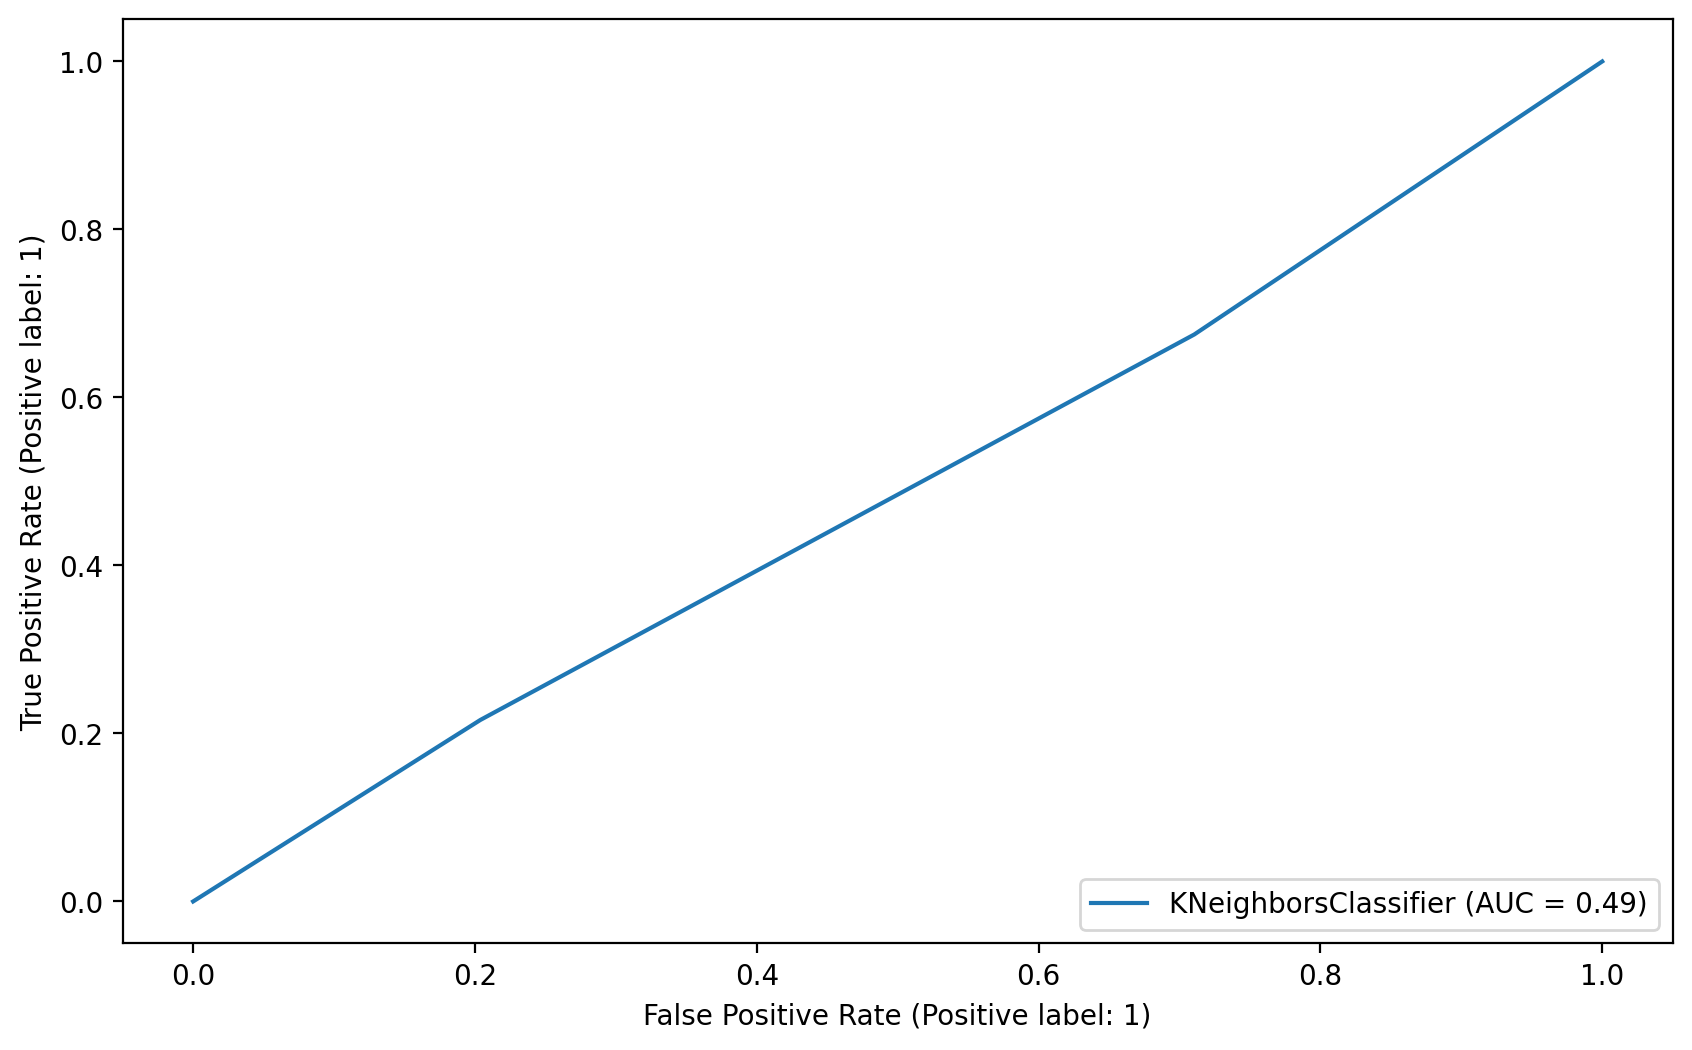

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.5458333333333333
roc_auc_score: 0.5032476380813953
precision_score: 0.4342629482071713
f1_score: 0.2857142857142857


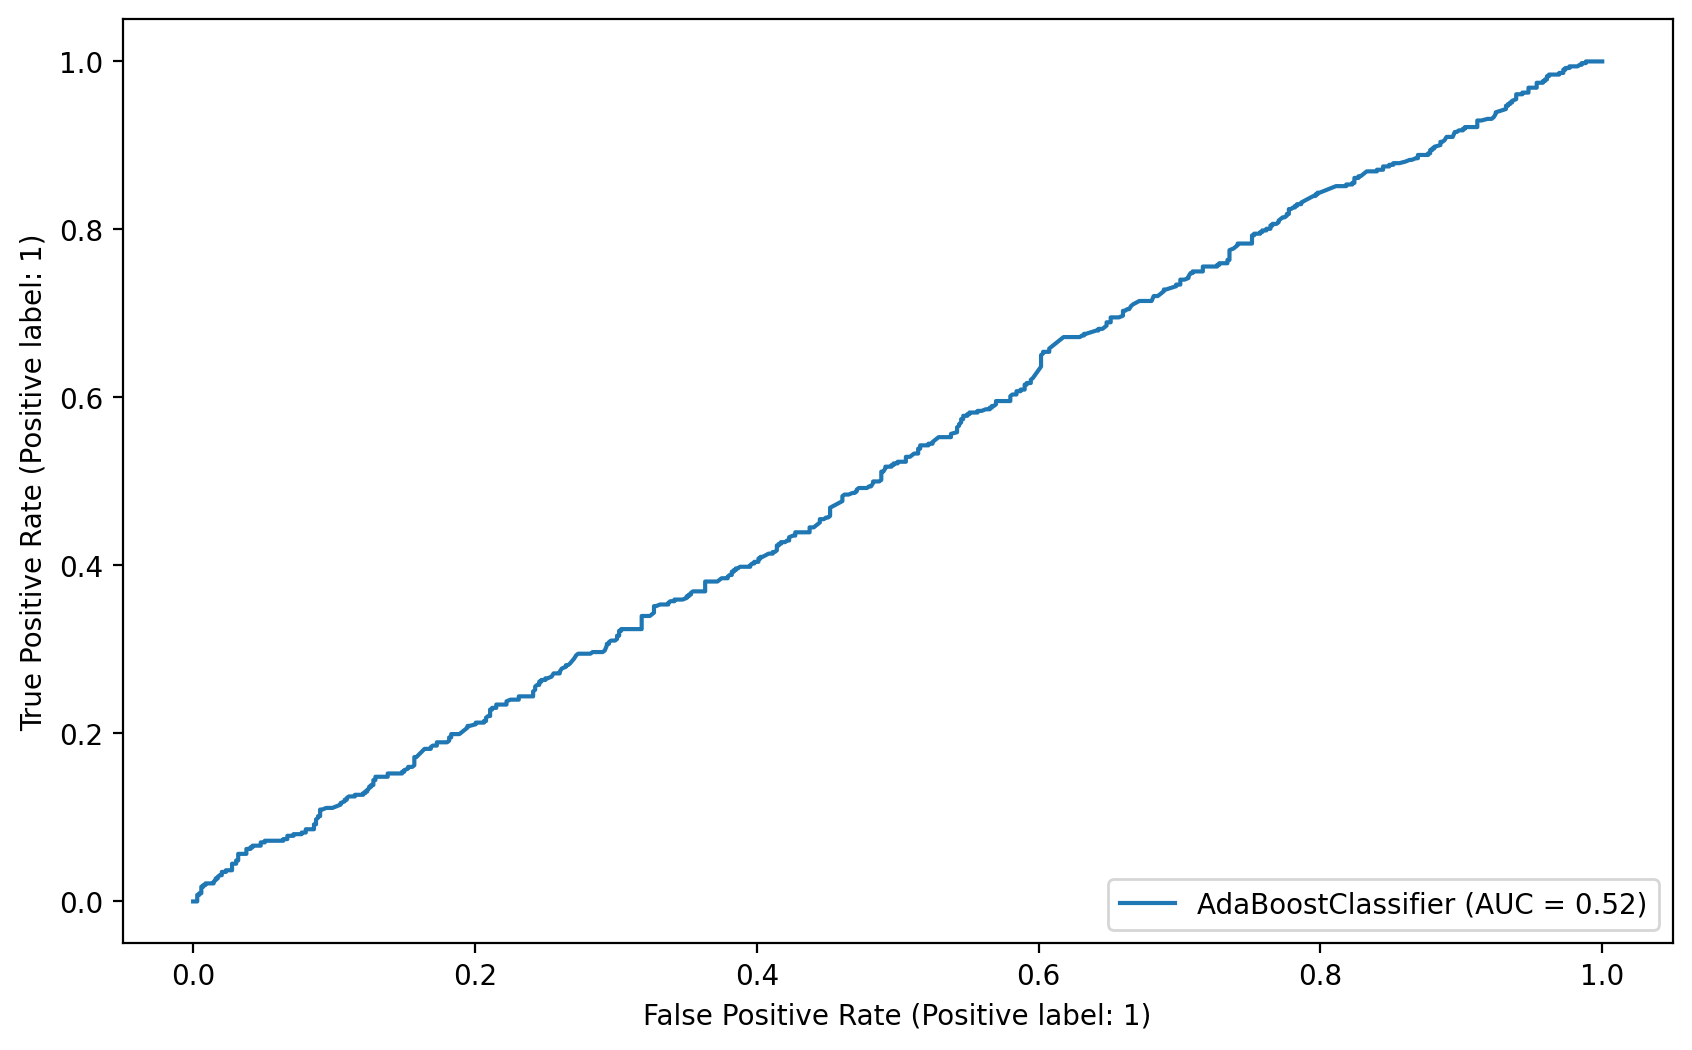

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6926647	total: 49.7ms	remaining: 49.6s
1:	learn: 0.6921378	total: 50.9ms	remaining: 25.4s
2:	learn: 0.6915964	total: 52ms	remaining: 17.3s
3:	learn: 0.6911482	total: 53ms	remaining: 13.2s
4:	learn: 0.6906383	total: 54.1ms	remaining: 10.8s
5:	learn: 0.6901628	total: 55.2ms	remaining: 9.14s
6:	learn: 0.6897010	total: 56.2ms	remaining: 7.98s
7:	learn: 0.6891362	total: 57.2ms	remaining: 7.1s
8:	learn: 0.6886031	total: 58.2ms	remaining: 6.41s
9:	learn: 0.6881717	total: 59.3ms	remaining: 5.87s
10:	learn: 0.6878070	total: 61.1ms	remaining: 5.49s
11:	learn: 0.6873799	total: 62.2ms	remaining: 5.12s
12:	learn: 0.6869052	total: 63.4ms	remaining: 4.81s
13:	learn: 0.6864389	total: 64.4ms	remaining: 4.54s
14:	learn: 0.6860576	total: 65.4ms	remaining: 4.3s
15:	learn: 0.6855758	total: 66.4ms	remaining: 4.08s
16:	learn: 0.6851602	total: 67.4m

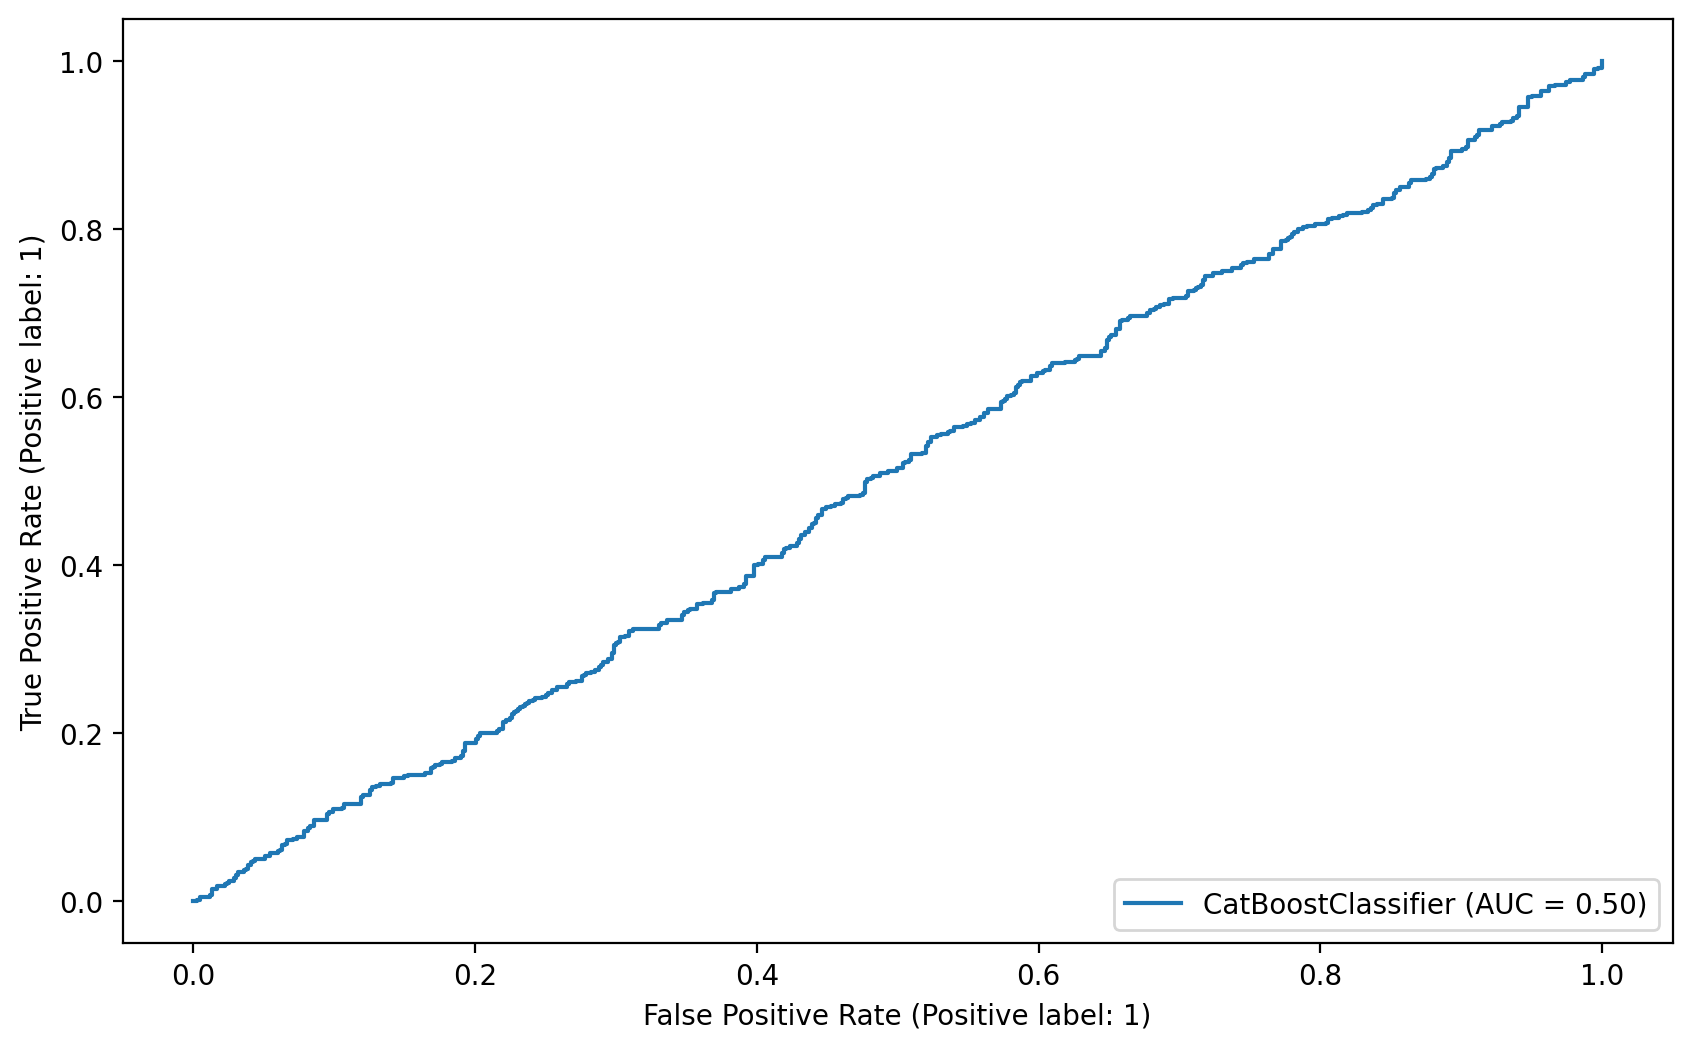

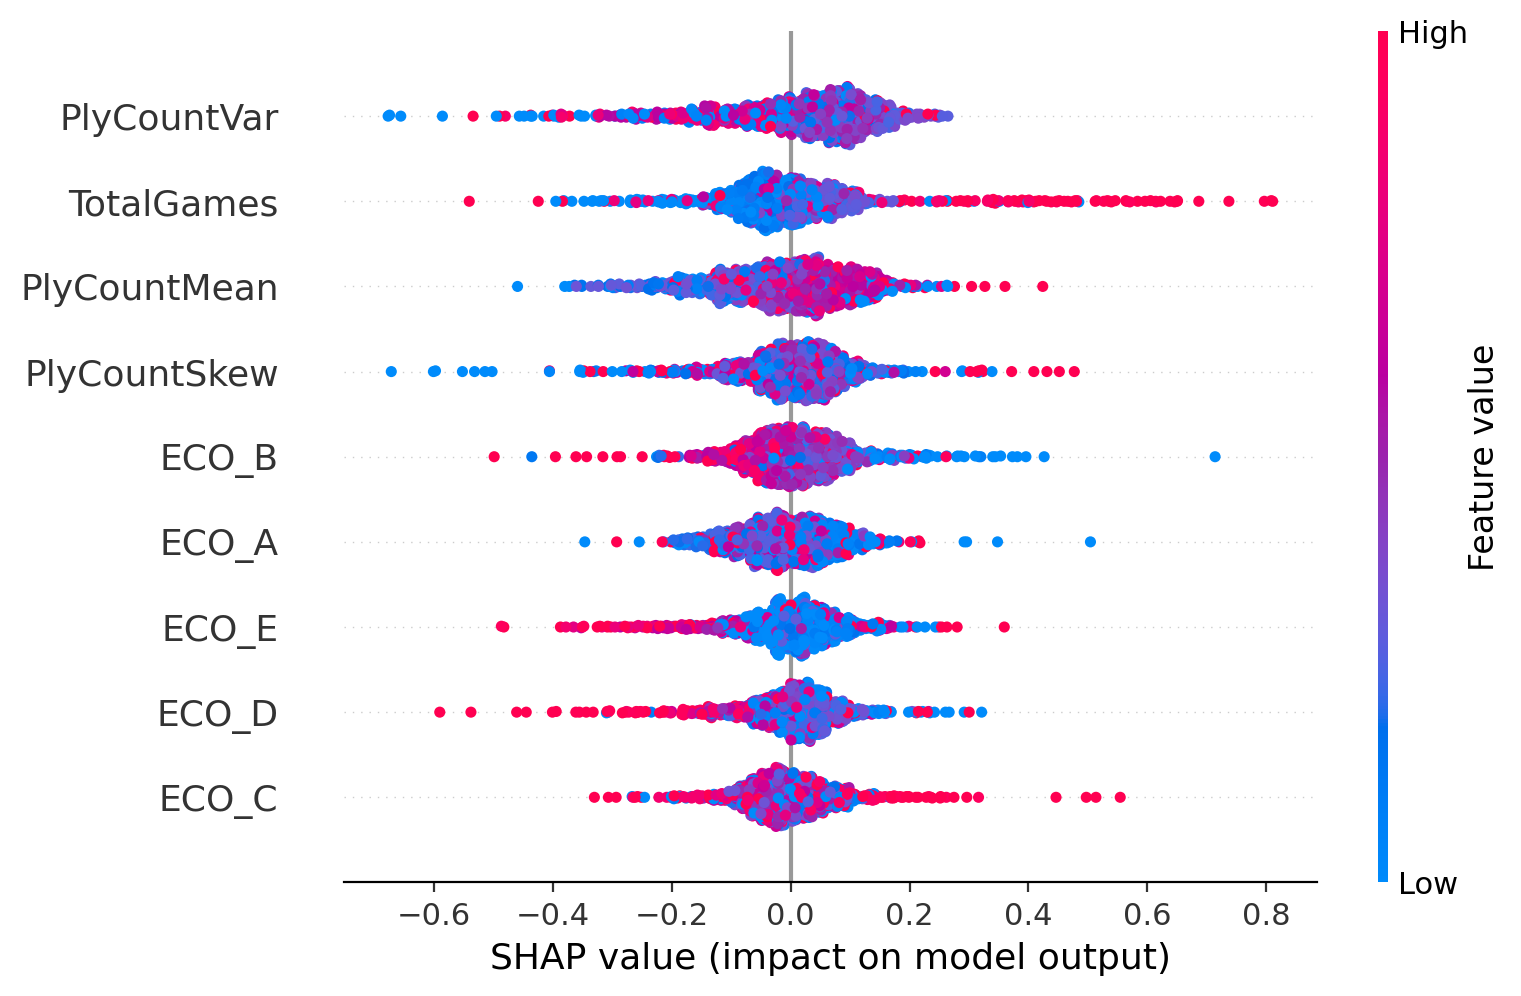

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.5125
roc_auc_score: 0.49691133720930236
precision_score: 0.42283298097251587
f1_score: 0.40609137055837563


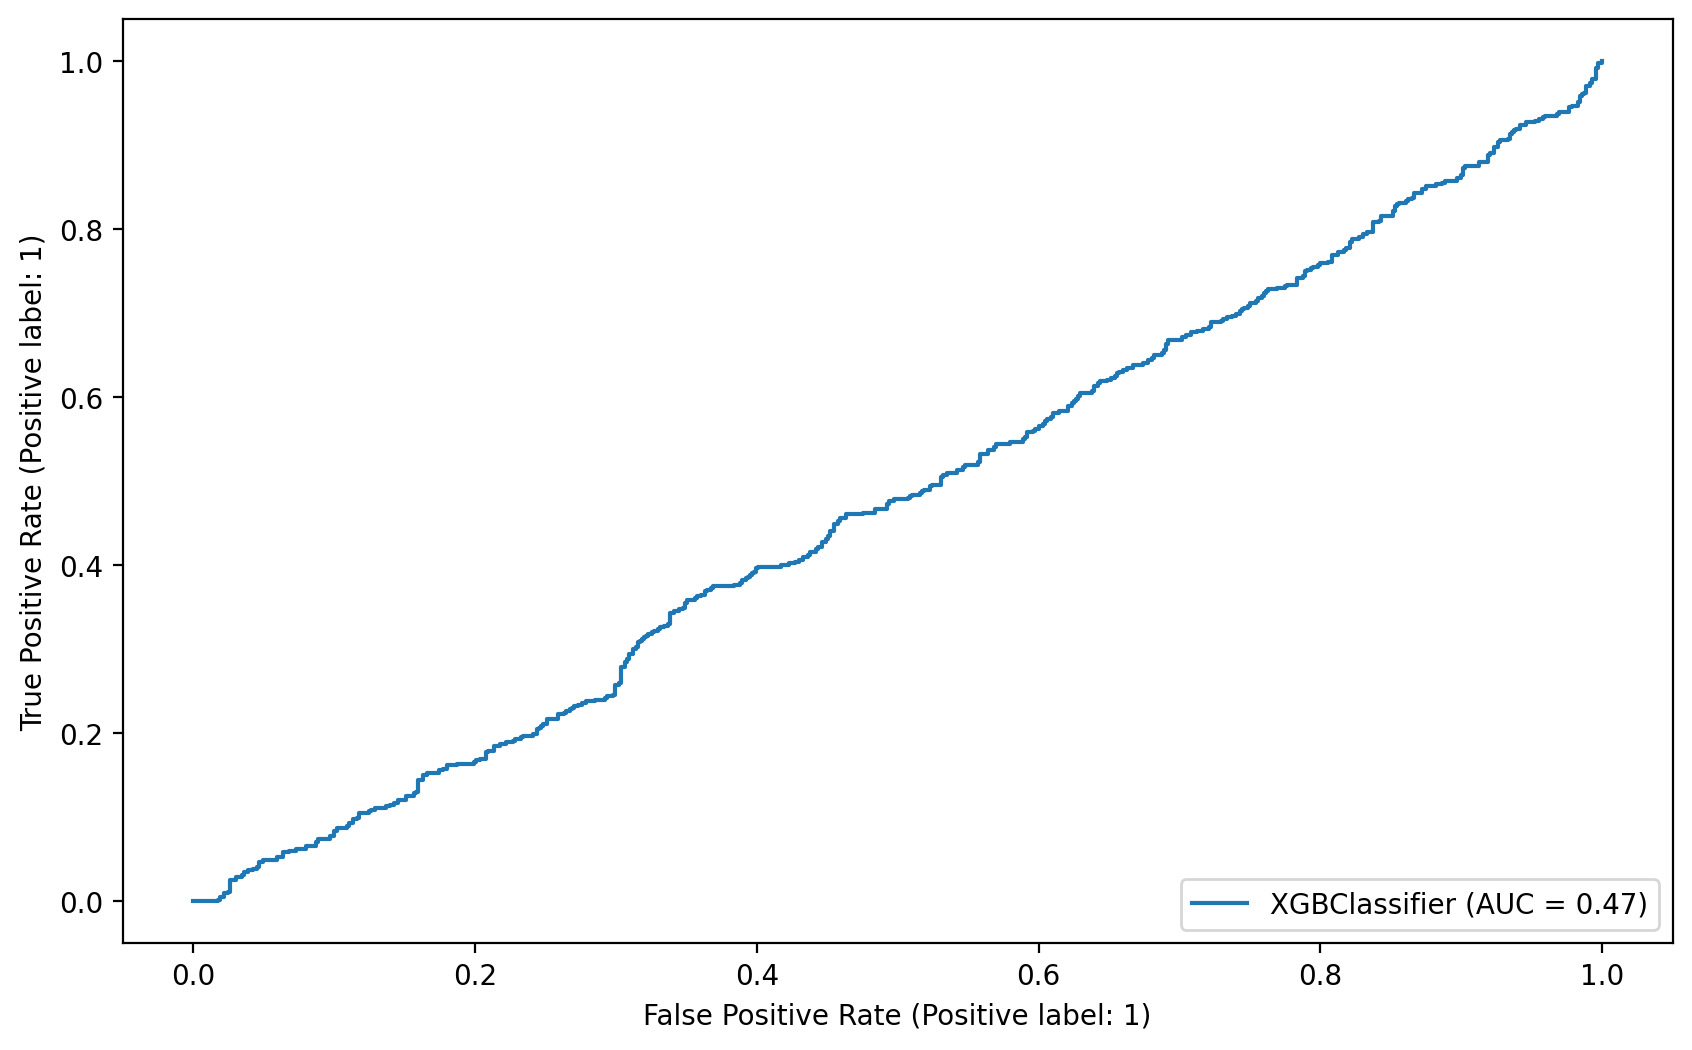

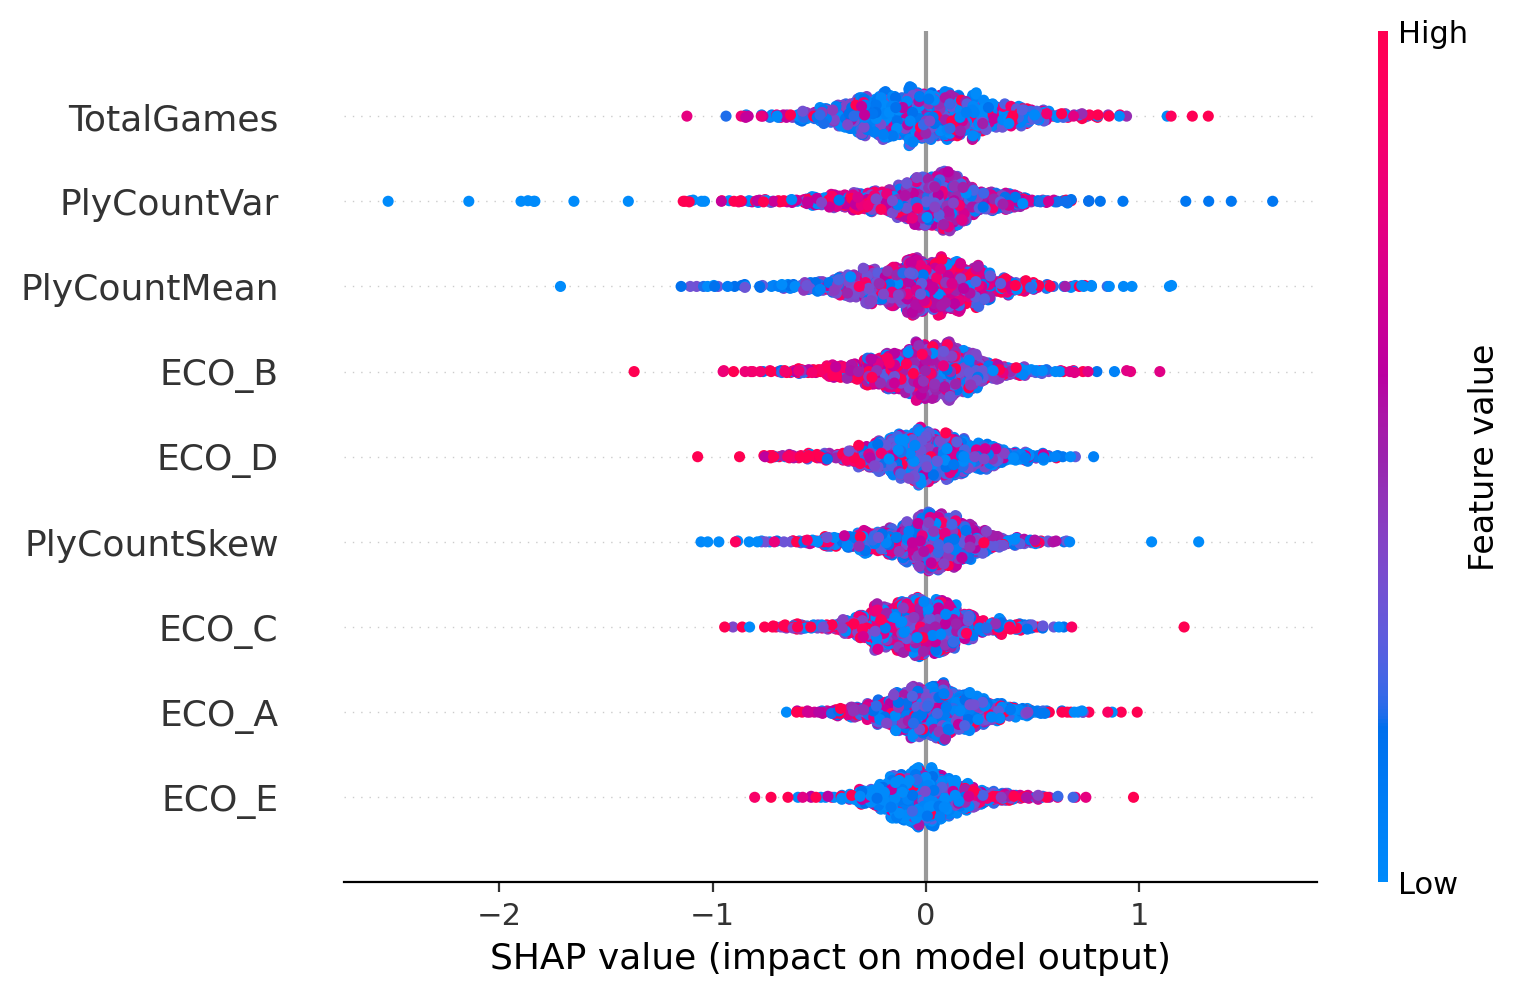

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 2108, number of negative: 2691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439258 -> initscore=-0.244173
[LightGBM] [Info] Start training from score -0.244173
Model name: LGBMClassifier
accuracy_score: 0.5108333333333334
roc_auc_score: 0.4925174825174825
precision_score: 0.44510385756676557
f1_score: 0.3382187147688838


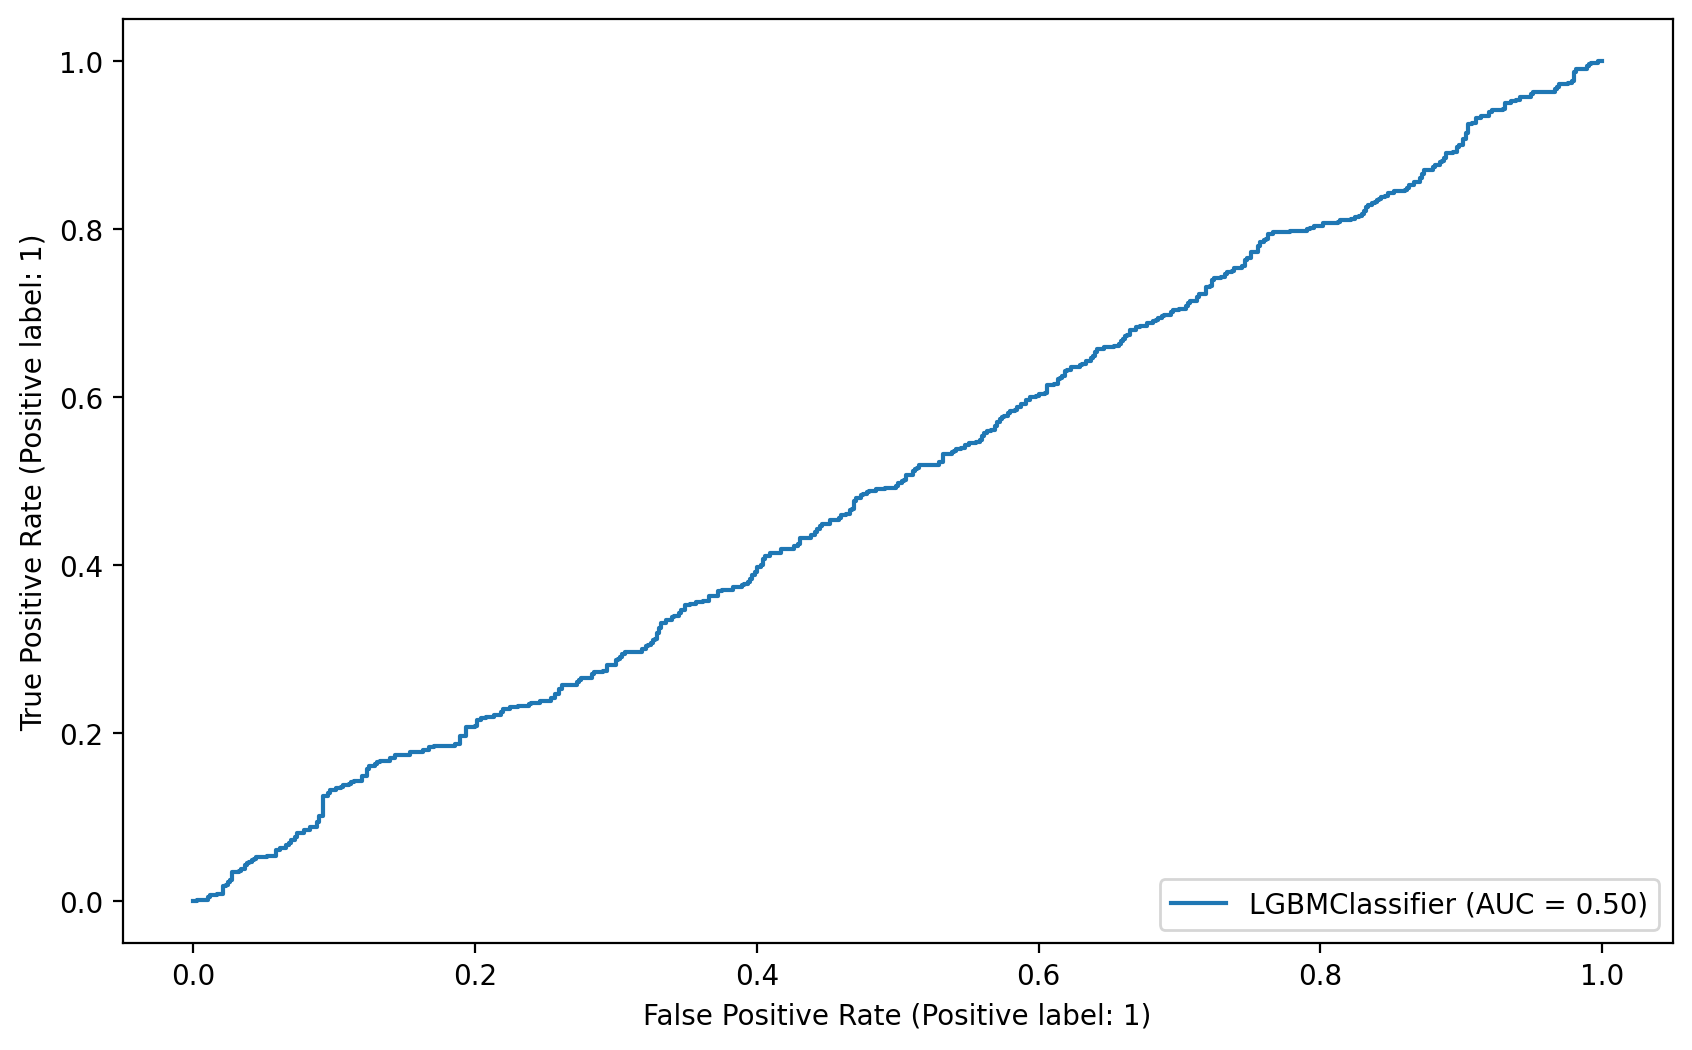

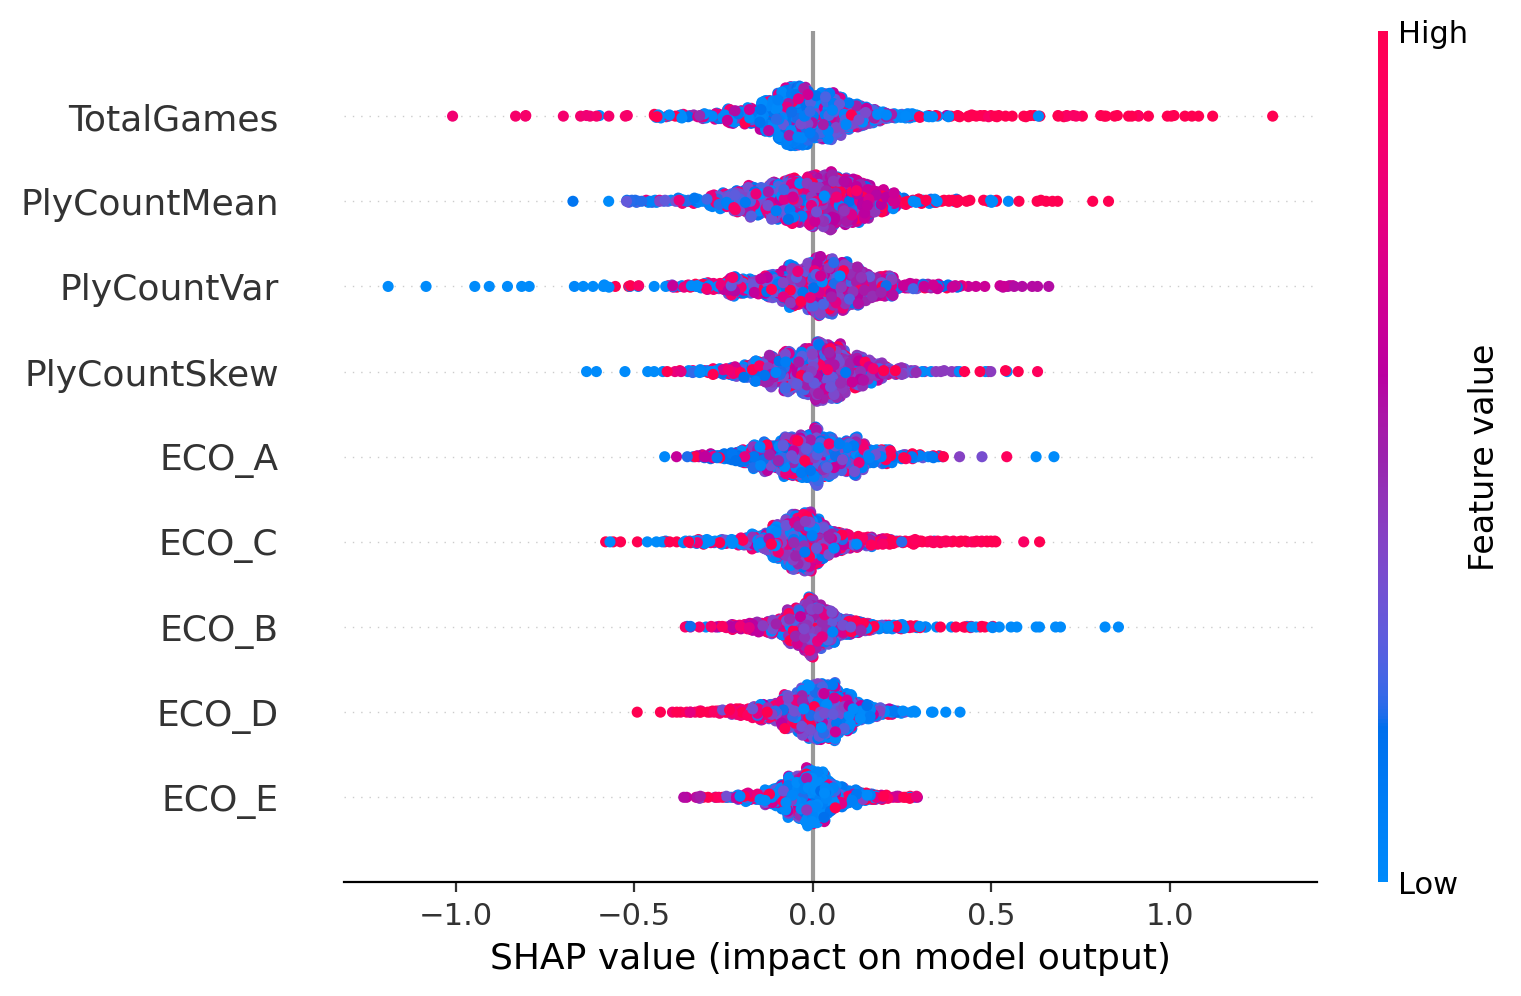

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.5591666666666667
roc_auc_score: 0.4995432386634374
precision_score: 0.4166666666666667
f1_score: 0.01855287569573284


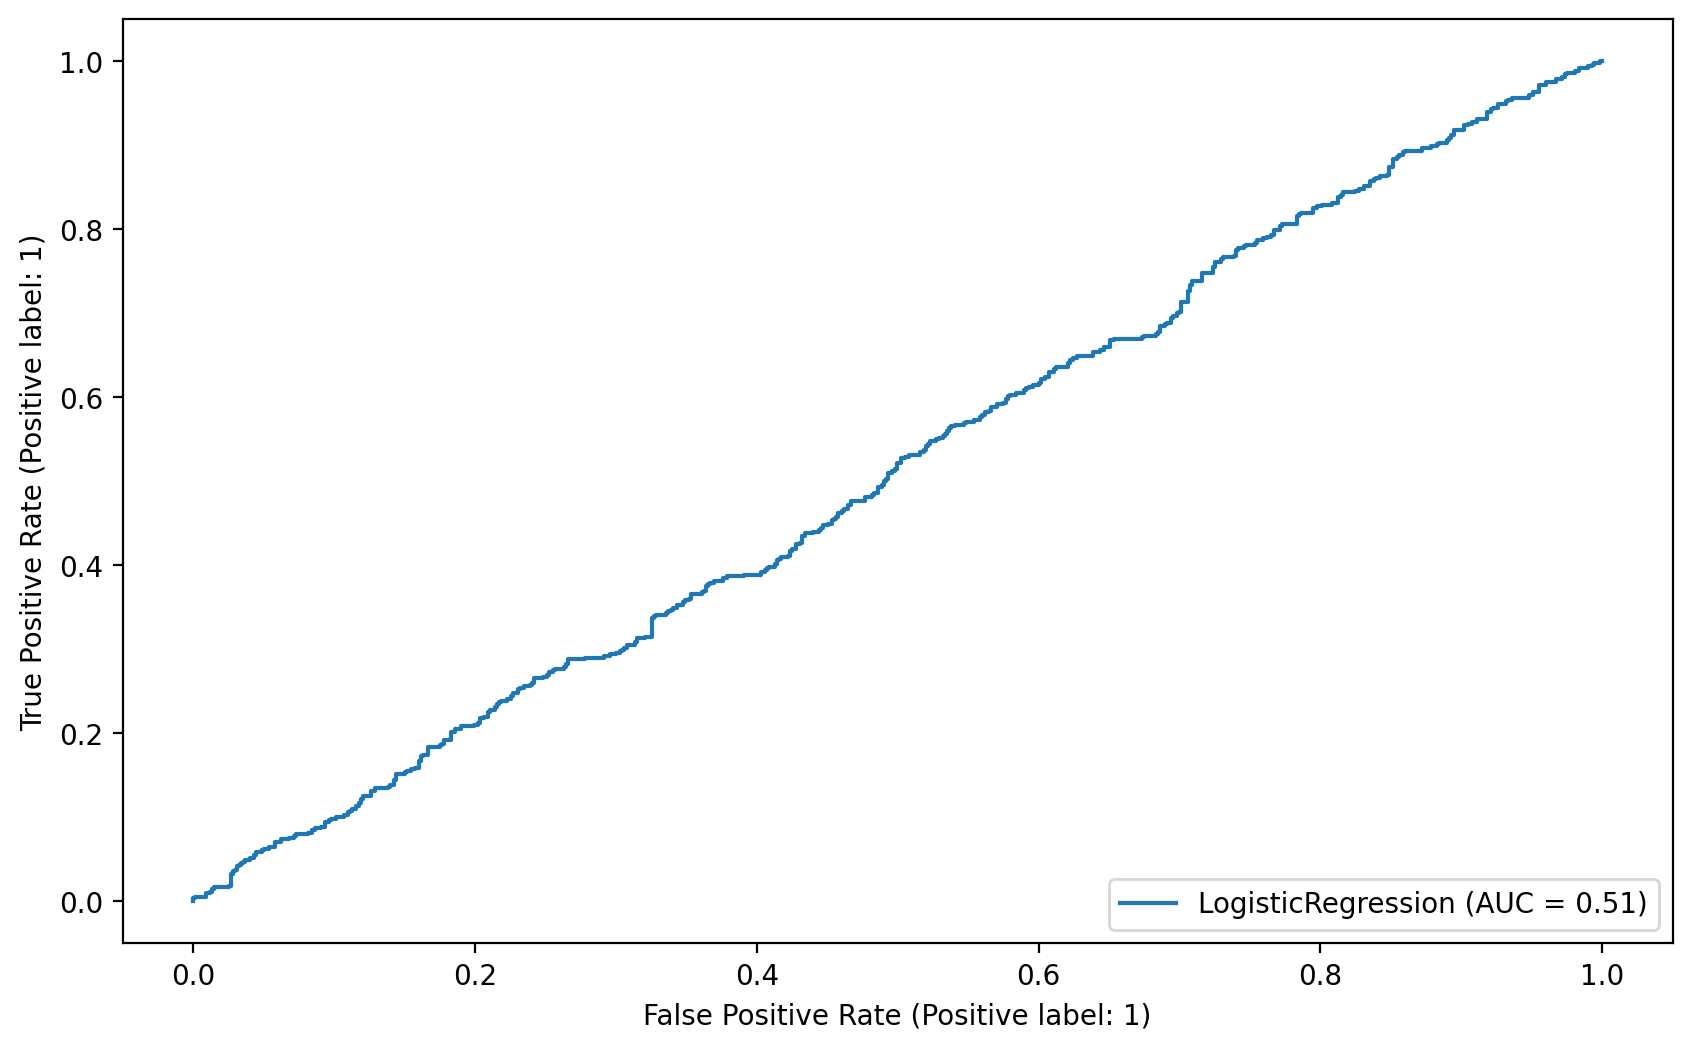

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.5683333333333334
roc_auc_score: 0.5058494354466443
precision_score: 0.49122807017543857
f1_score: 0.0975609756097561


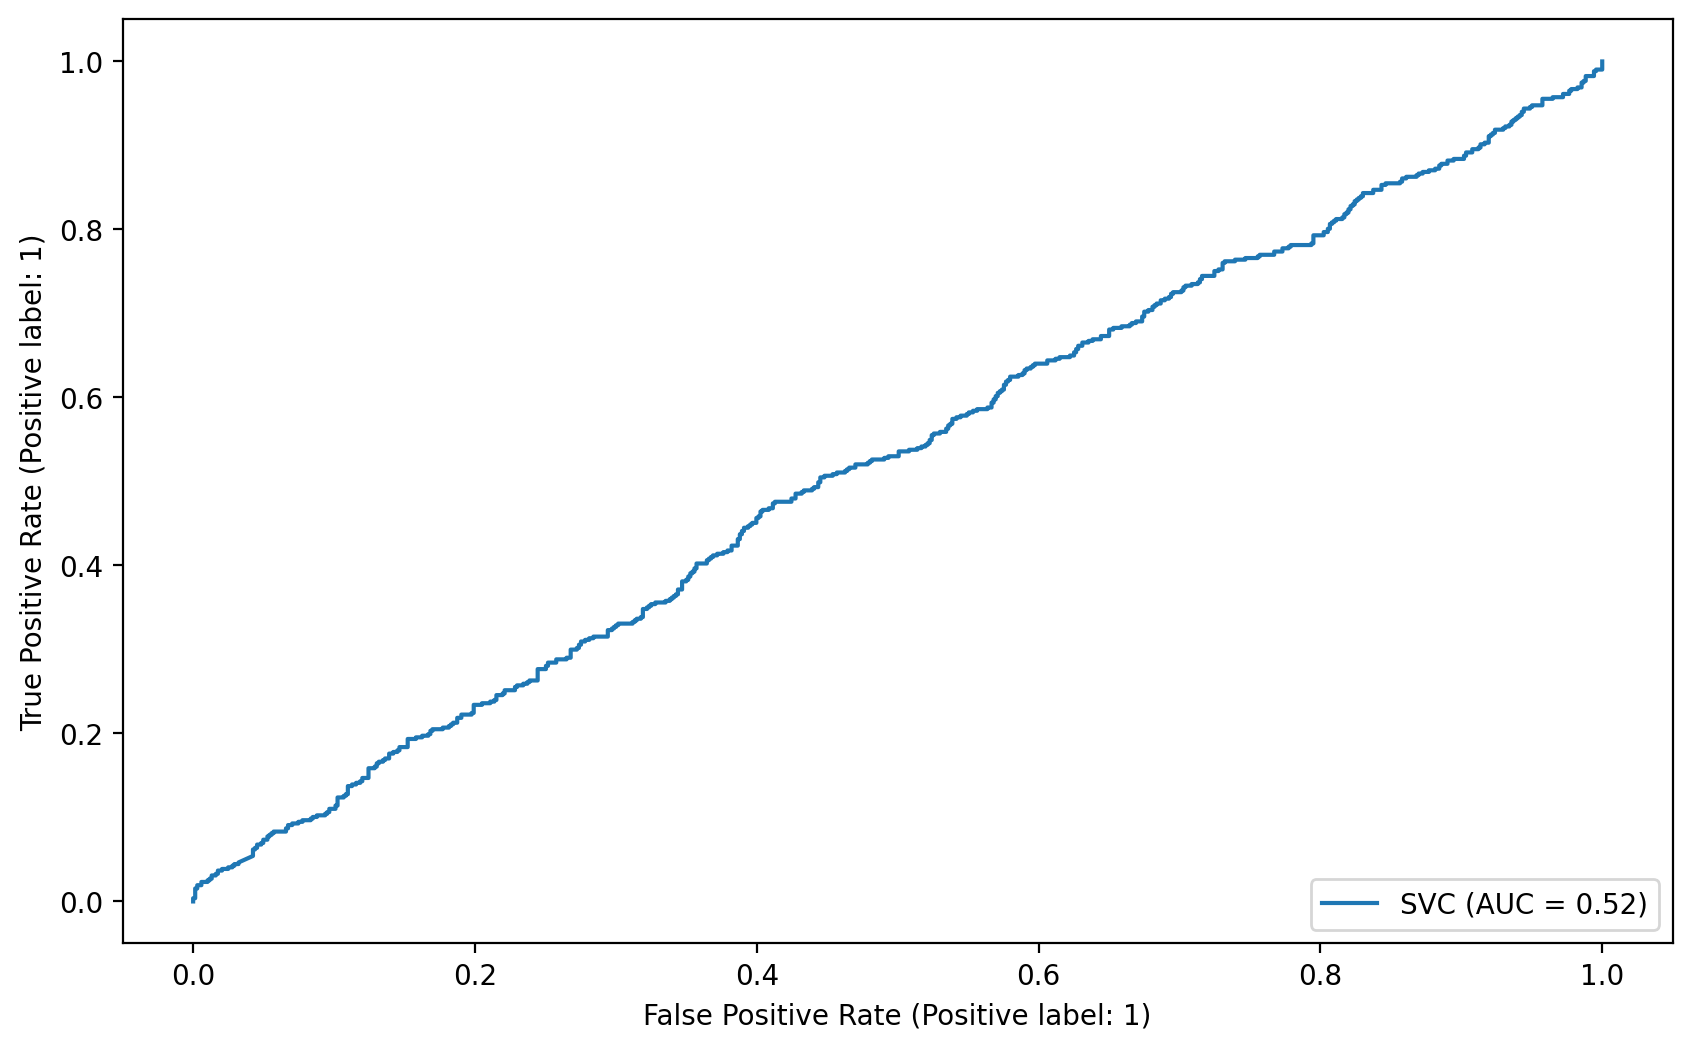

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.5316666666666666
roc_auc_score: 0.5092592592592593
precision_score: 0.4666666666666667
f1_score: 0.35402298850574715


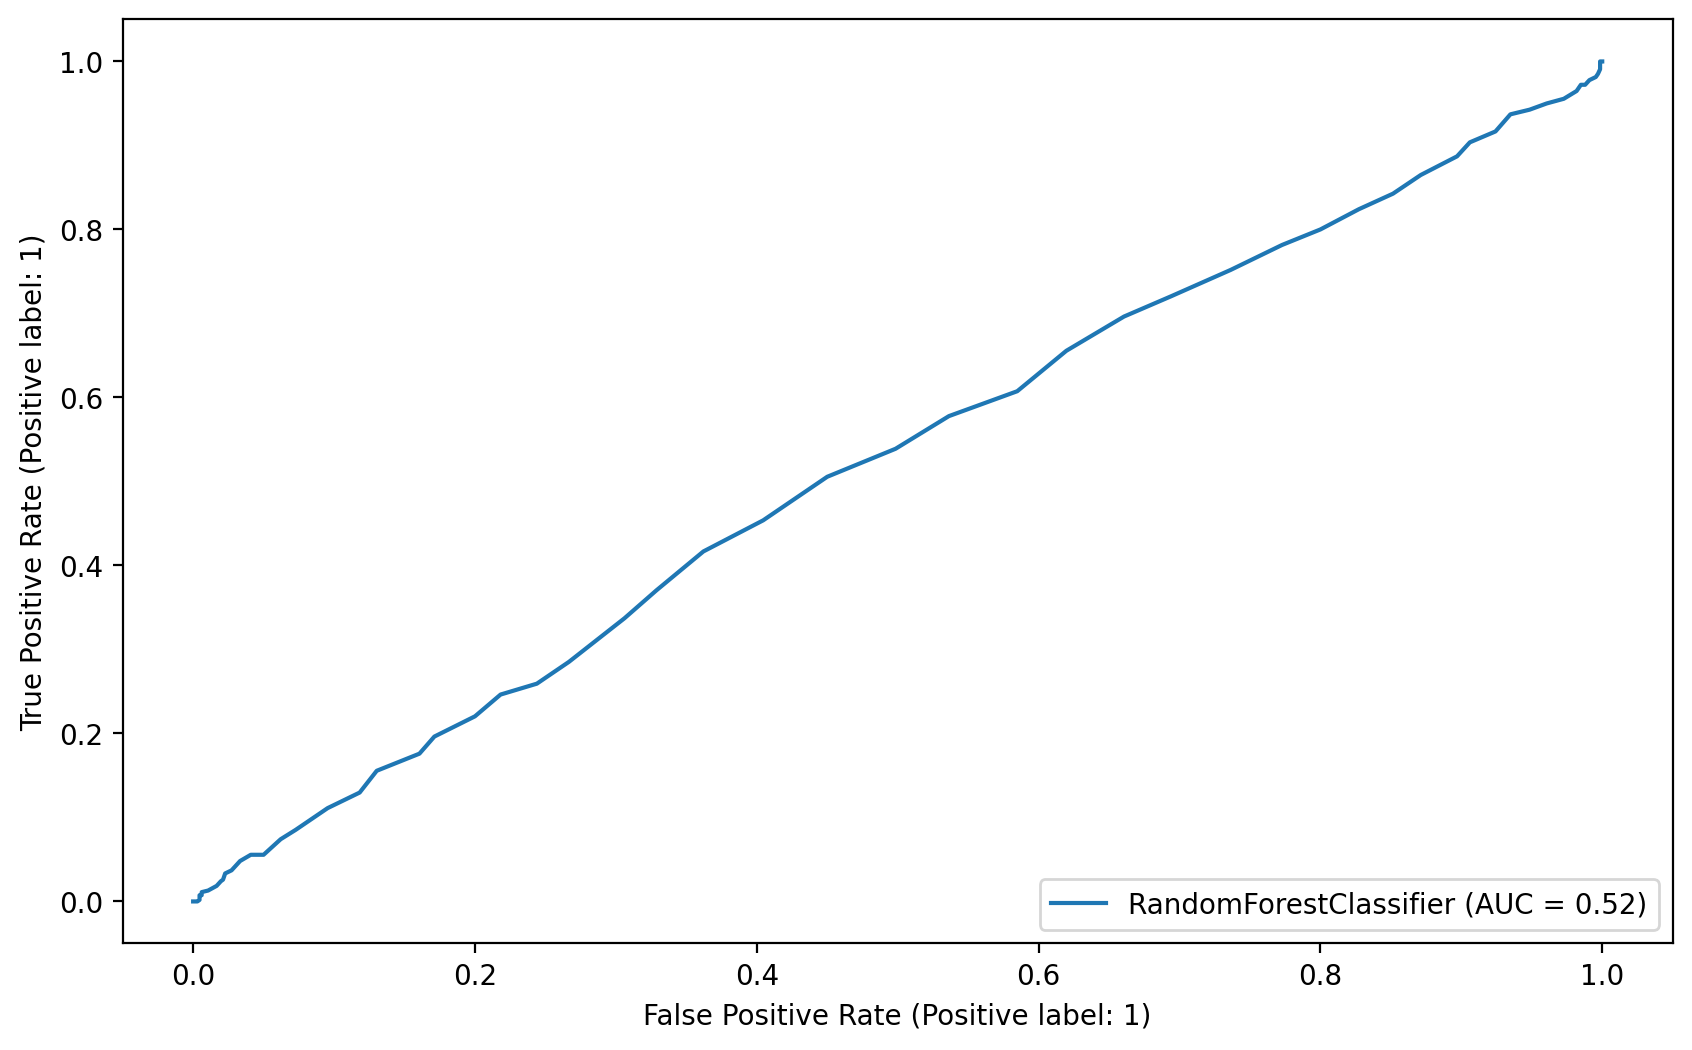

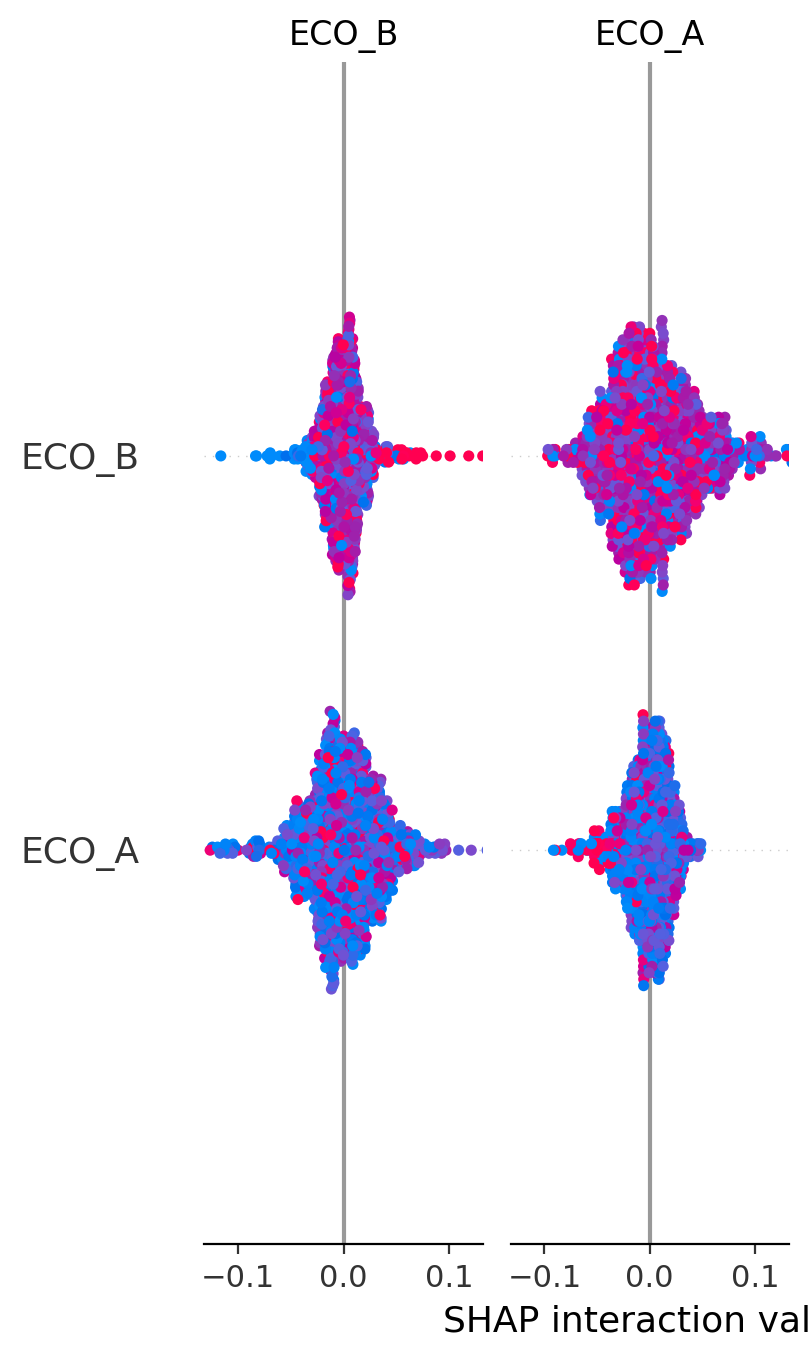

In [ ]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(parsed_details,0.2,m["model"],m["name"]))

### 2.2.3  Compare results

In [ ]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
decision tree             0.4958     0.4200  0.4468  0.4330
XGBClassifier             0.5125     0.4228  0.3906  0.4061
basic random forrest      0.5317     0.4667  0.2852  0.3540
LGBMClassifier            0.5108     0.4451  0.2727  0.3382
CatBoostClassifier        0.5225     0.4412  0.2514  0.3203
KNeighborsClassifier      0.5433     0.4502  0.2161  0.2920
AdaBoostClassifier        0.5458     0.4343  0.2129  0.2857
Gaussian Naive Bayes      0.5533     0.3864  0.0659  0.1126
Support vector machine    0.5683     0.4912  0.0542  0.0976
logistic regression       0.5592     0.4167  0.0095  0.0186


### 2.3 using game trends features

In this section we will try to predict game results using trend related features

### 2.3.1  Load data

In [ ]:
players=df_interval.index
df=get_features_per_player(players,pd.to_datetime([f'{2018}-09-01 00:00:00']).min(),df_2018,extra_df)
df.index=list(df["Player"])
df=df.drop(columns="Player")
df["Label"]=choose_positive(label_trend(df_interval["Label"]))
df

mean          var  kurtosis      skew   min   max  Label
ABCi         1463.333333   739.022222 -0.428960 -0.428960  1406  1502      0
ABSBEGINNER  1344.142276  1451.811736 -0.302494 -0.302494  1241  1426      0
ADJUSTOR     1878.373218  1864.929391 -0.363291 -0.363291  1745  1994      0
AFCERGY      1571.542036  1115.665047 -0.014246 -0.014246  1461  1677      0
AFRF         1364.376000  1022.746624 -0.244517 -0.244517  1278  1456      0
...                  ...          ...       ...       ...   ...   ...    ...
zwartspeler  1821.970471  1499.353478  0.477892  0.477892  1724  1925      0
zwirek        985.571429   452.530612 -0.211077 -0.211077   951  1016      0
zxtxf        1332.290323  1331.109261 -0.369068 -0.369068  1252  1408      0
zyrq         1478.447326  2225.900386  0.052584  0.052584  1373  1590      0
zzyxx        1497.287770  1376.881217  0.554133  0.554133  1418  1597      0

[5999 rows x 7 columns]

In [ ]:
df["Label"]=df_interval["Label"]
df

mean          var  kurtosis      skew   min   max  Label
ABCi         1463.333333   739.022222 -0.428960 -0.428960  1406  1502      0
ABSBEGINNER  1344.142276  1451.811736 -0.302494 -0.302494  1241  1426      0
ADJUSTOR     1878.373218  1864.929391 -0.363291 -0.363291  1745  1994      1
AFCERGY      1571.542036  1115.665047 -0.014246 -0.014246  1461  1677      0
AFRF         1364.376000  1022.746624 -0.244517 -0.244517  1278  1456      1
...                  ...          ...       ...       ...   ...   ...    ...
zwartspeler  1821.970471  1499.353478  0.477892  0.477892  1724  1925      0
zwirek        985.571429   452.530612 -0.211077 -0.211077   951  1016      1
zxtxf        1332.290323  1331.109261 -0.369068 -0.369068  1252  1408      1
zyrq         1478.447326  2225.900386  0.052584  0.052584  1373  1590      0
zzyxx        1497.287770  1376.881217  0.554133  0.554133  1418  1597      0

[5999 rows x 7 columns]

### 2.3.2  Run classification model

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.5383333333333333
roc_auc_score: 0.5330917113142137
precision_score: 0.47962962962962963
f1_score: 0.4832089552238806


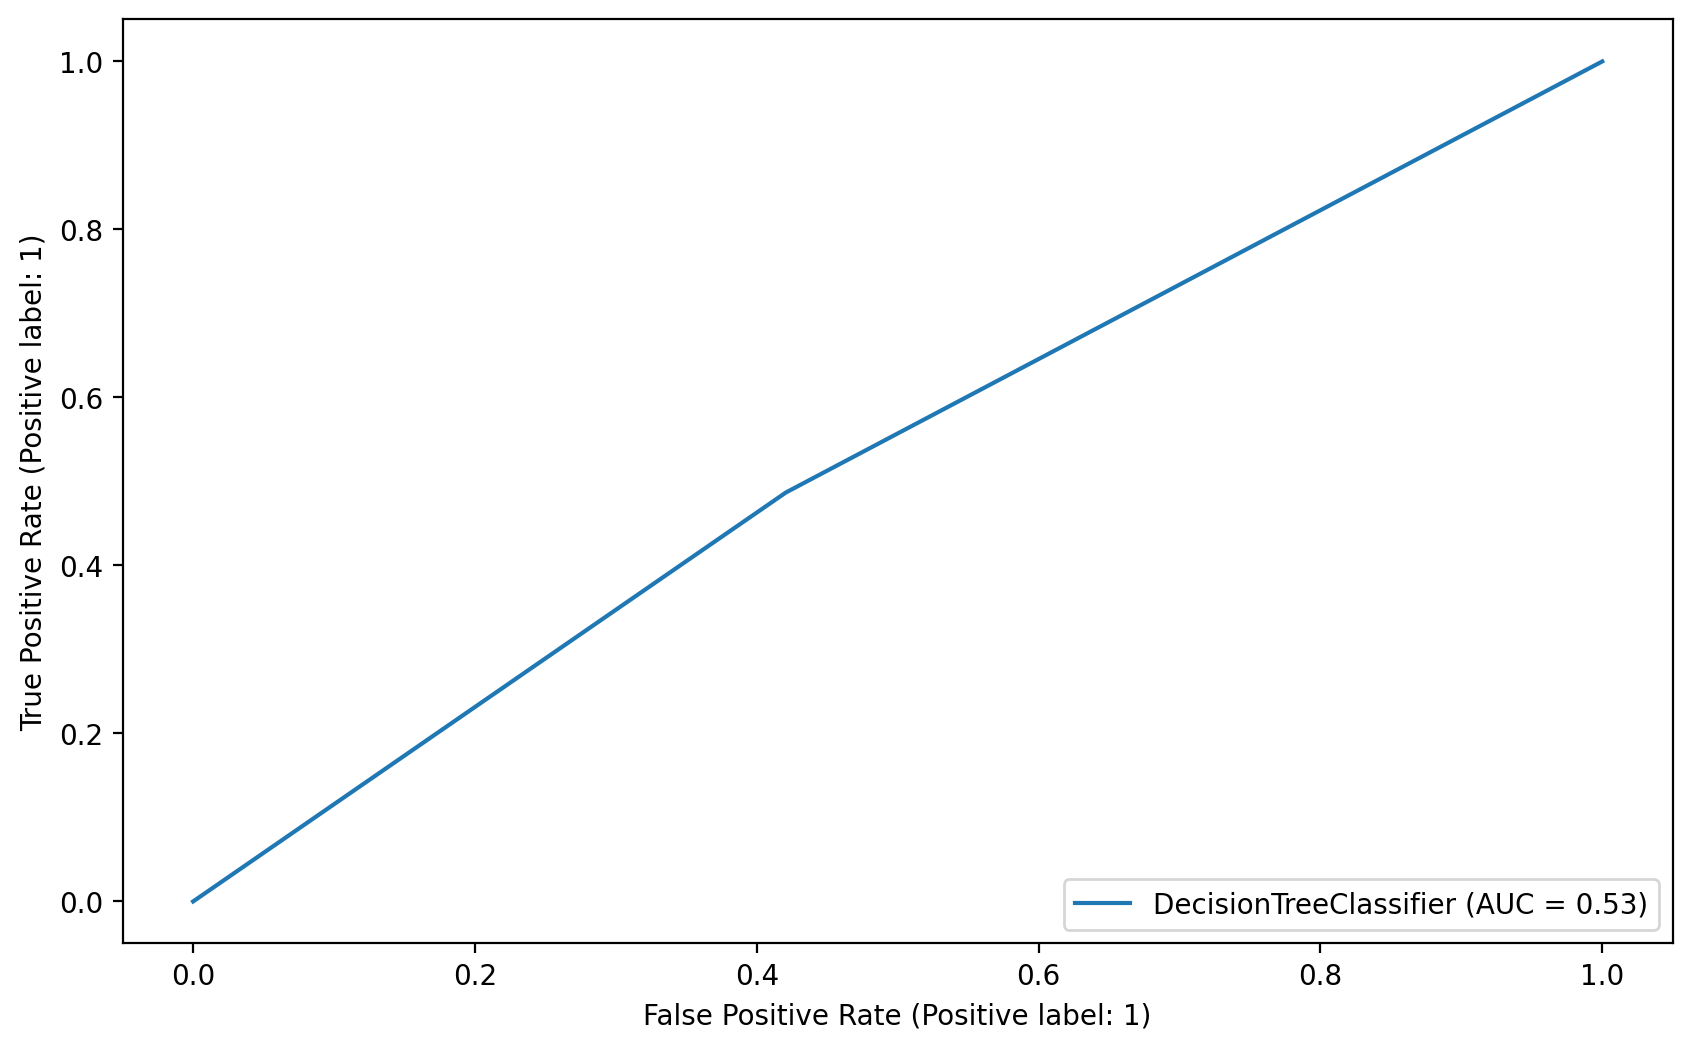

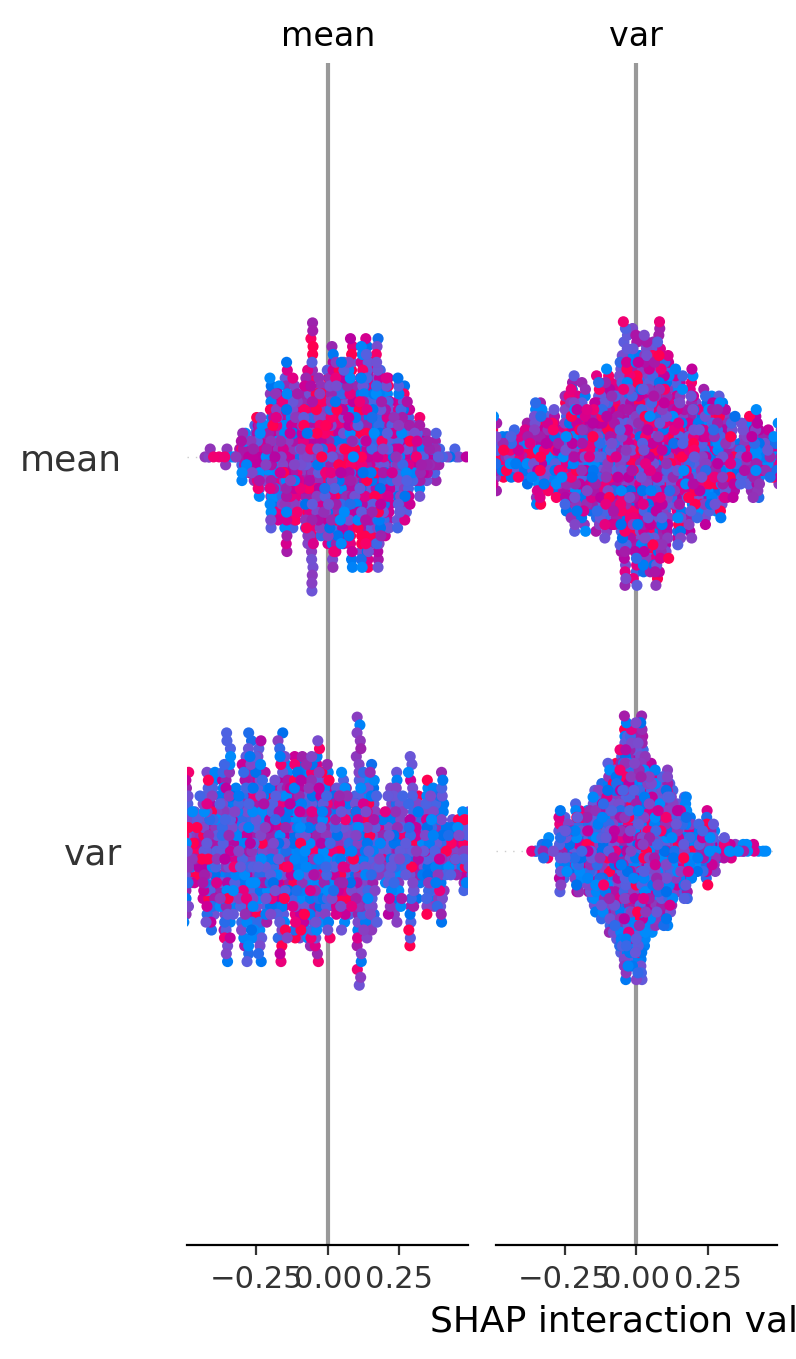

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.525
roc_auc_score: 0.5267436430191359
precision_score: 0.48475120385232745
f1_score: 0.5144804088586031


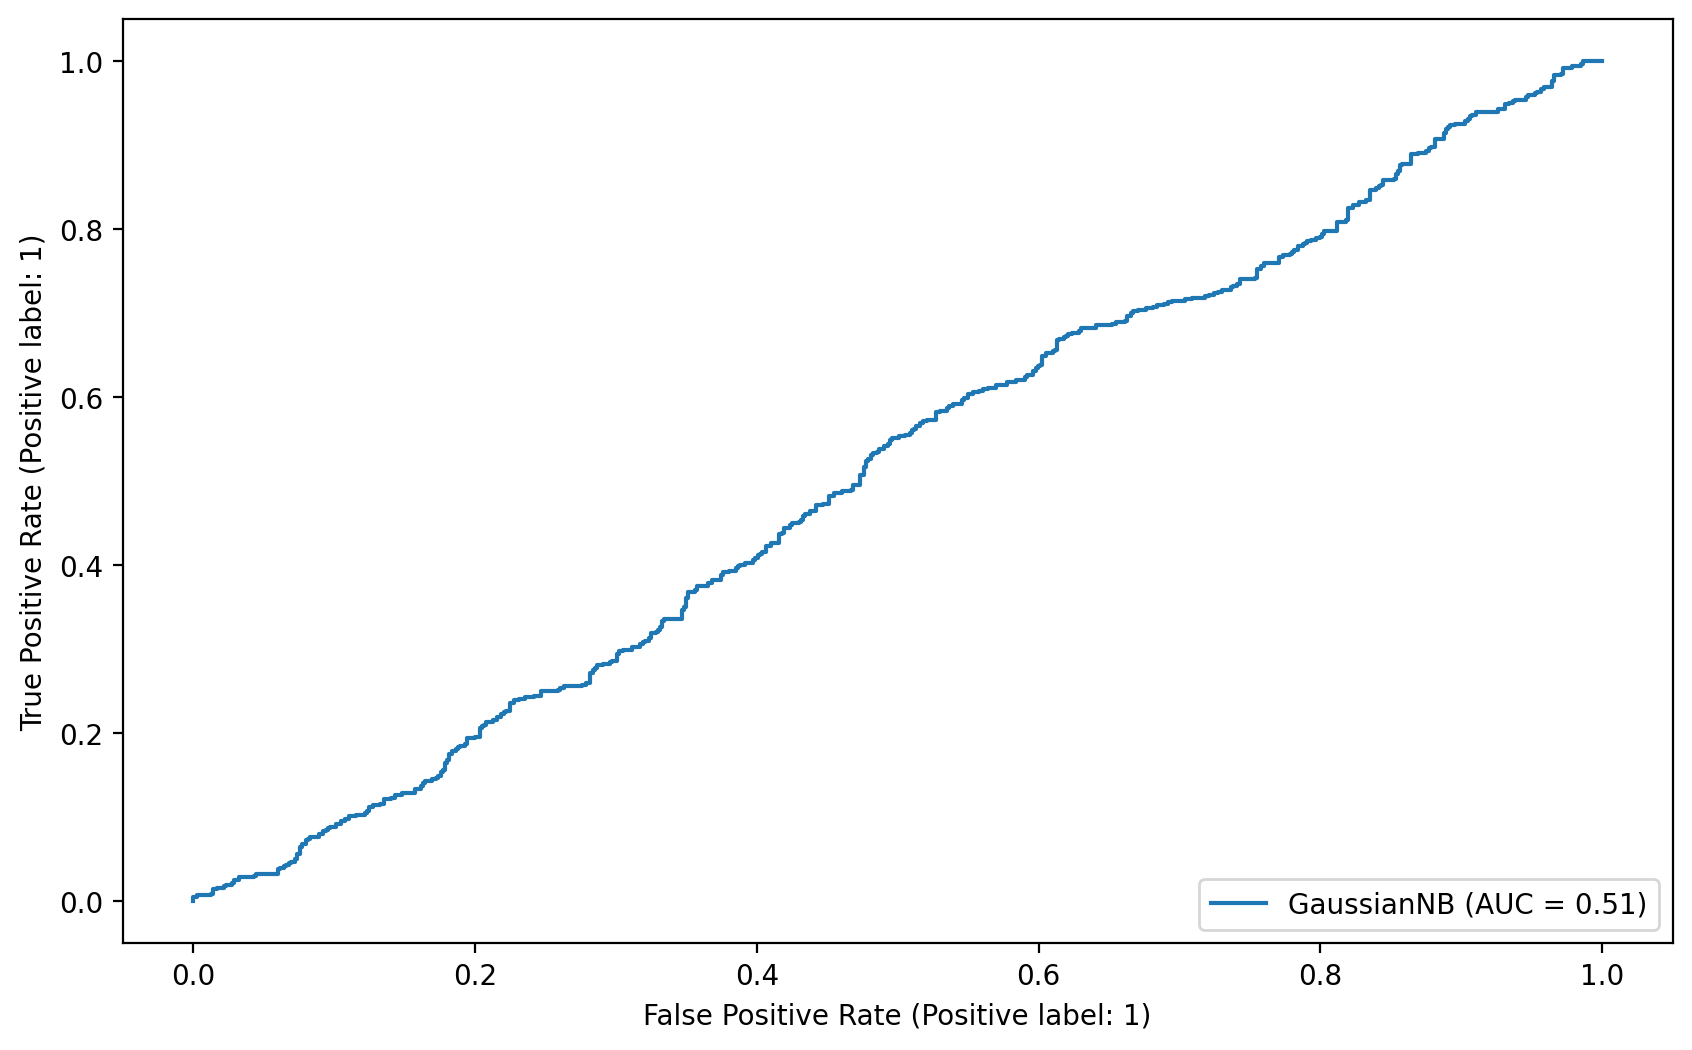

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.5233333333333333
roc_auc_score: 0.4964399265594913
precision_score: 0.4473684210526316
f1_score: 0.26288659793814434


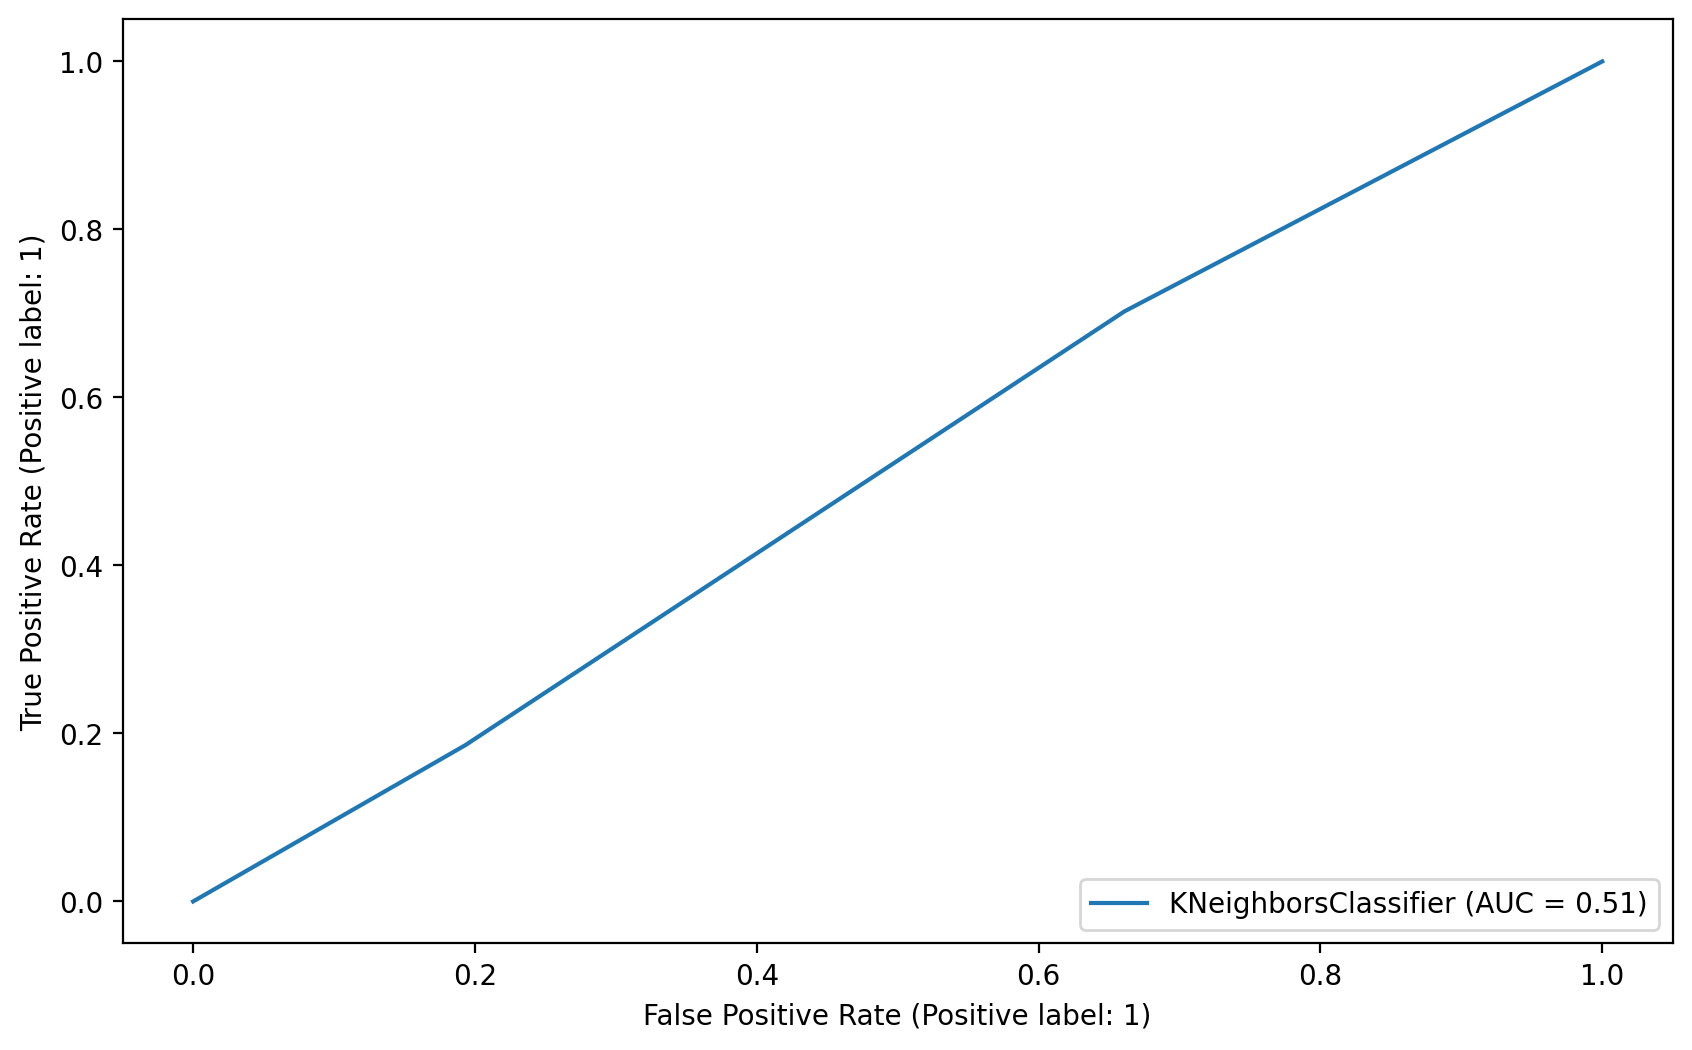

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.56
roc_auc_score: 0.5020367757498521
precision_score: 0.4315068493150685
f1_score: 0.1926605504587156


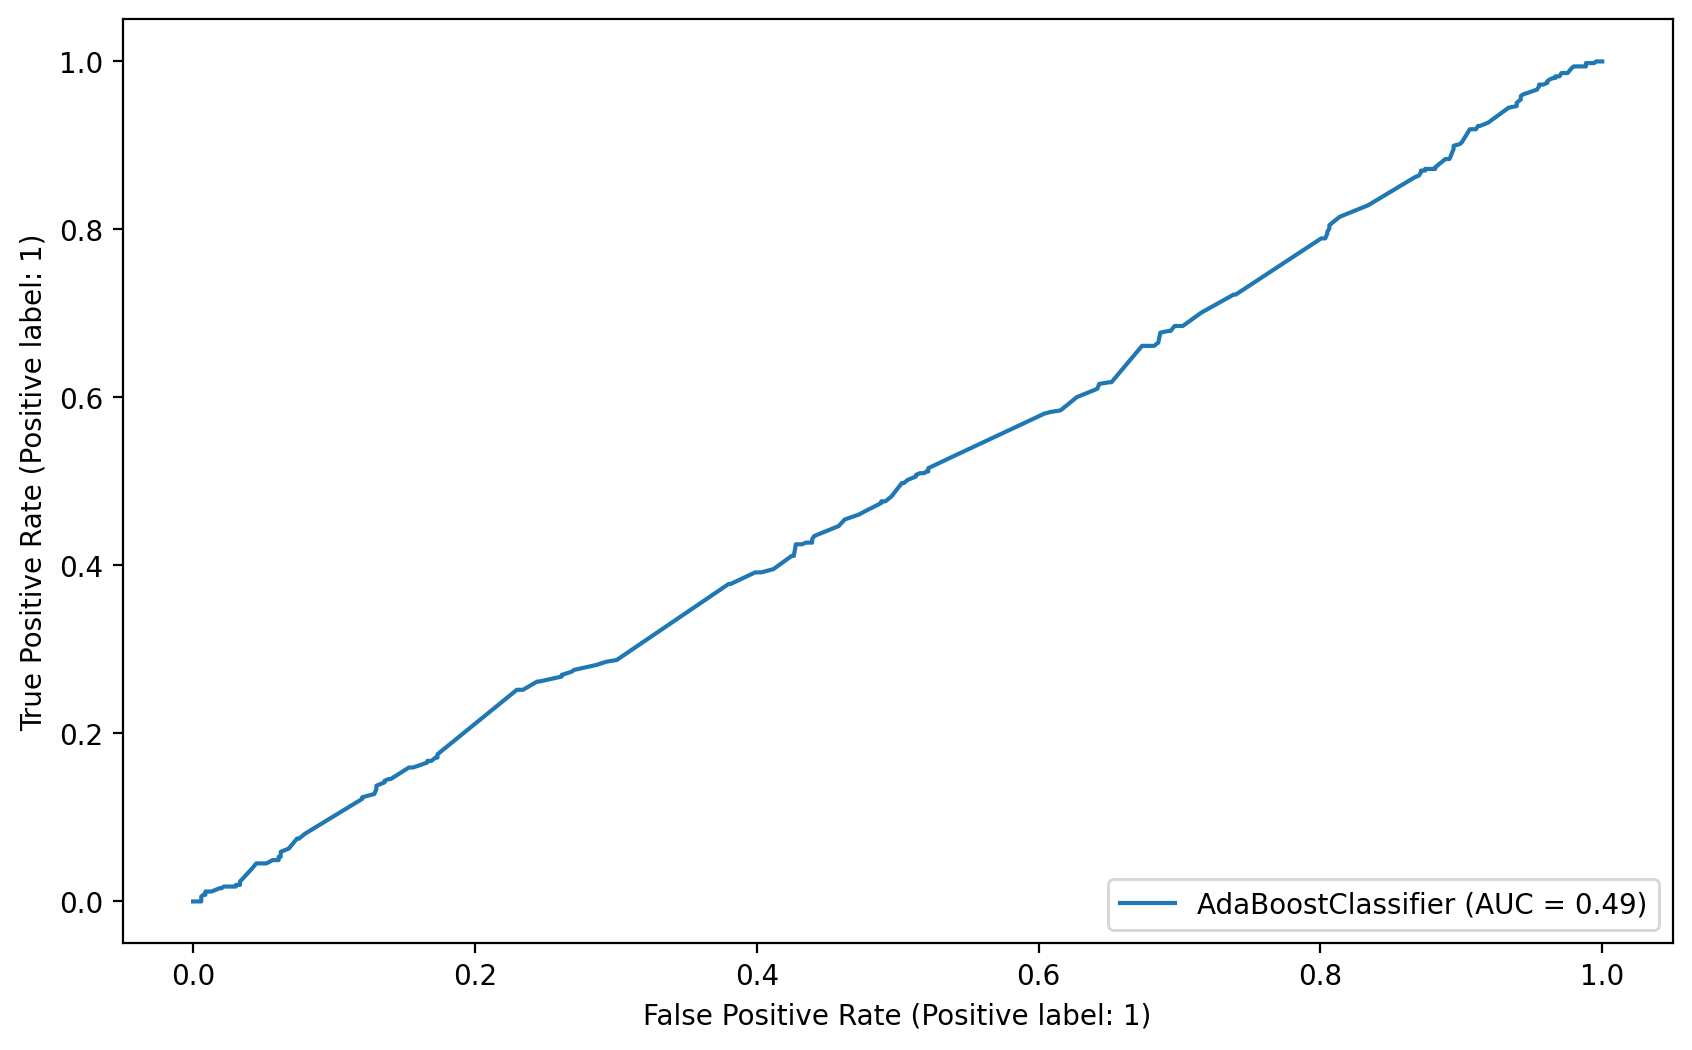

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6928446	total: 1.27ms	remaining: 1.27s
1:	learn: 0.6925471	total: 2.35ms	remaining: 1.17s
2:	learn: 0.6922691	total: 3.71ms	remaining: 1.23s
3:	learn: 0.6919955	total: 4.8ms	remaining: 1.2s
4:	learn: 0.6917856	total: 5.84ms	remaining: 1.16s
5:	learn: 0.6915570	total: 6.93ms	remaining: 1.15s
6:	learn: 0.6912614	total: 7.95ms	remaining: 1.13s
7:	learn: 0.6910765	total: 8.95ms	remaining: 1.11s
8:	learn: 0.6908275	total: 10.1ms	remaining: 1.11s
9:	learn: 0.6906132	total: 11.2ms	remaining: 1.11s
10:	learn: 0.6903797	total: 12.2ms	remaining: 1.1s
11:	learn: 0.6901572	total: 13.2ms	remaining: 1.08s
12:	learn: 0.6899707	total: 14.2ms	remaining: 1.07s
13:	learn: 0.6898144	total: 15.2ms	remaining: 1.07s
14:	learn: 0.6896201	total: 16.1ms	remaining: 1.06s
15:	learn: 0.6894320	total: 17.1ms	remaining: 1.05s
16:	learn: 0.6892816	total: 18

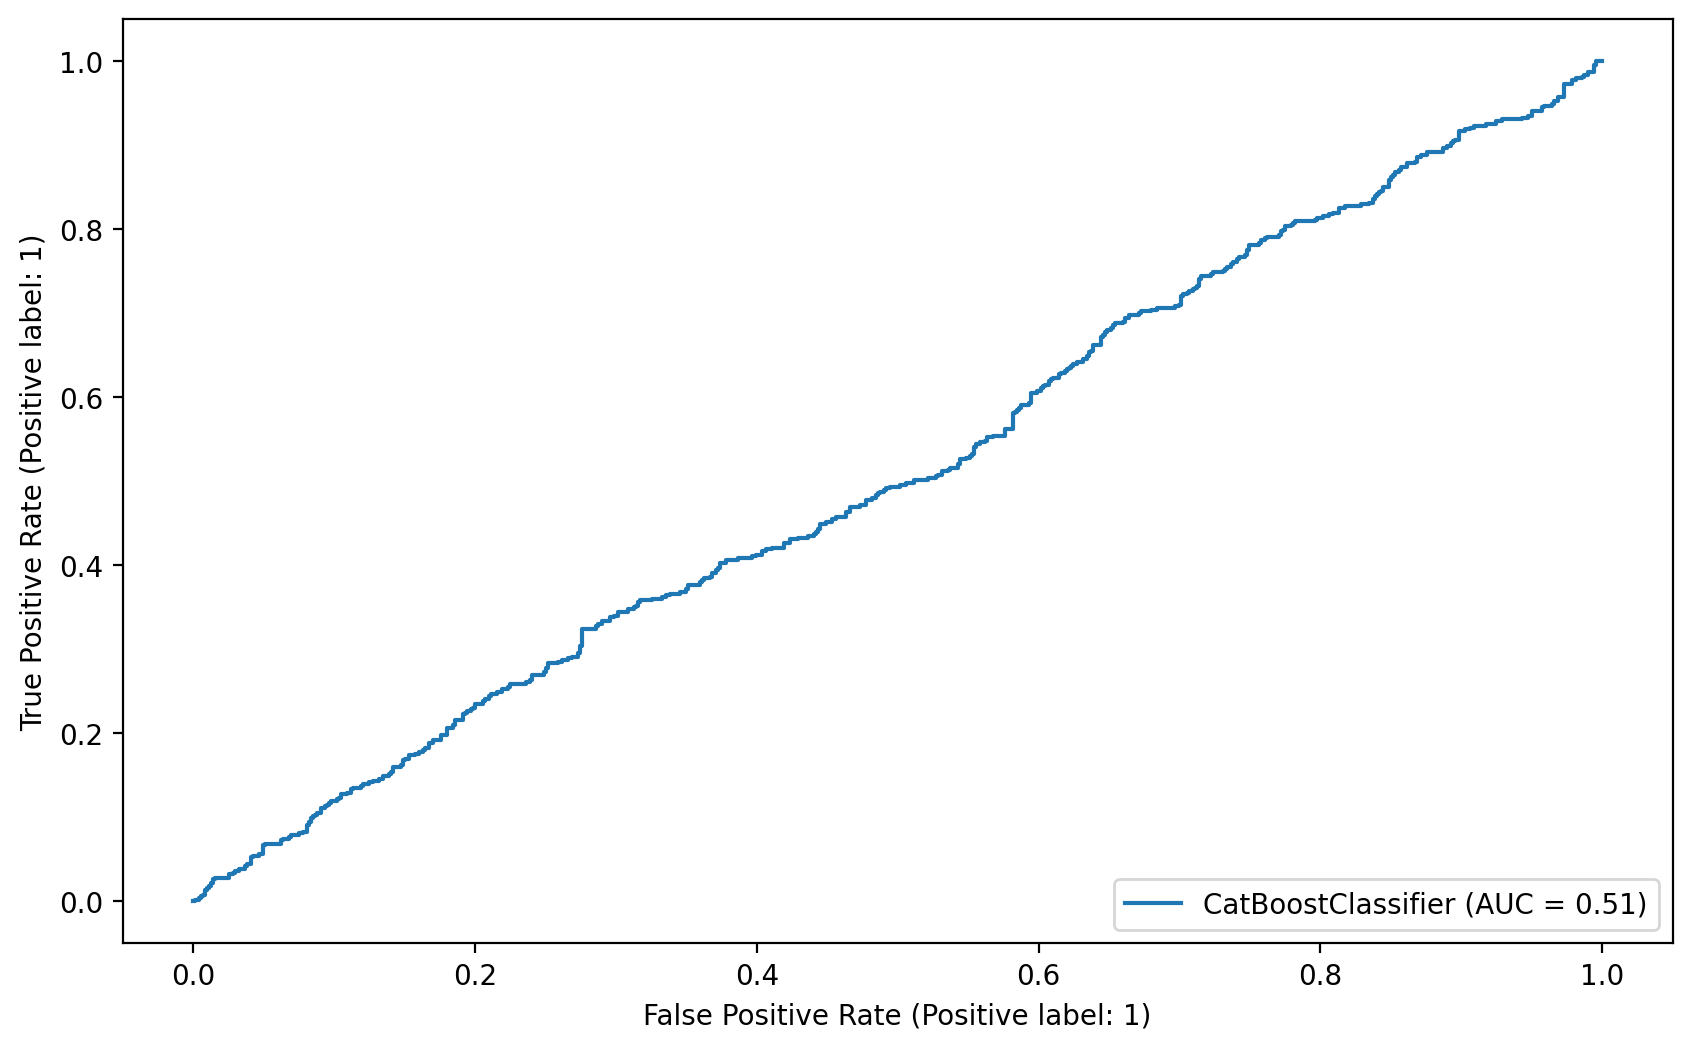

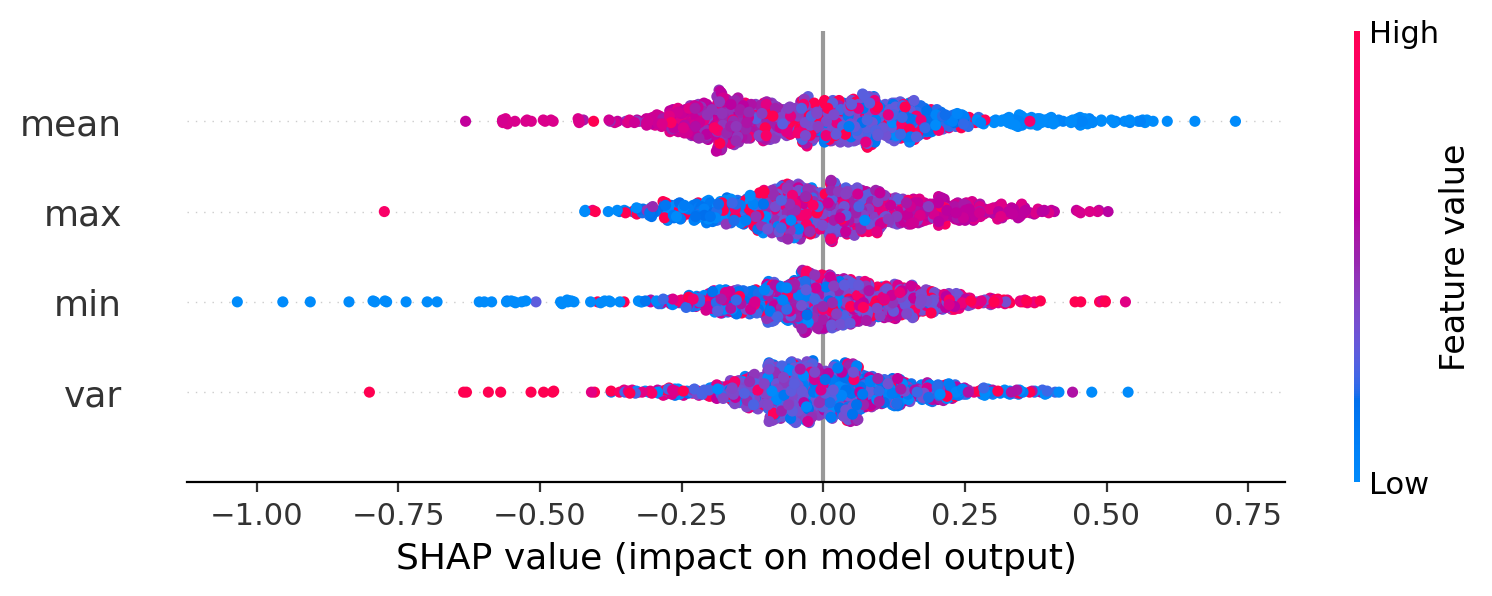

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.5416666666666666
roc_auc_score: 0.5239781885407863
precision_score: 0.4666666666666667
f1_score: 0.4246861924686192


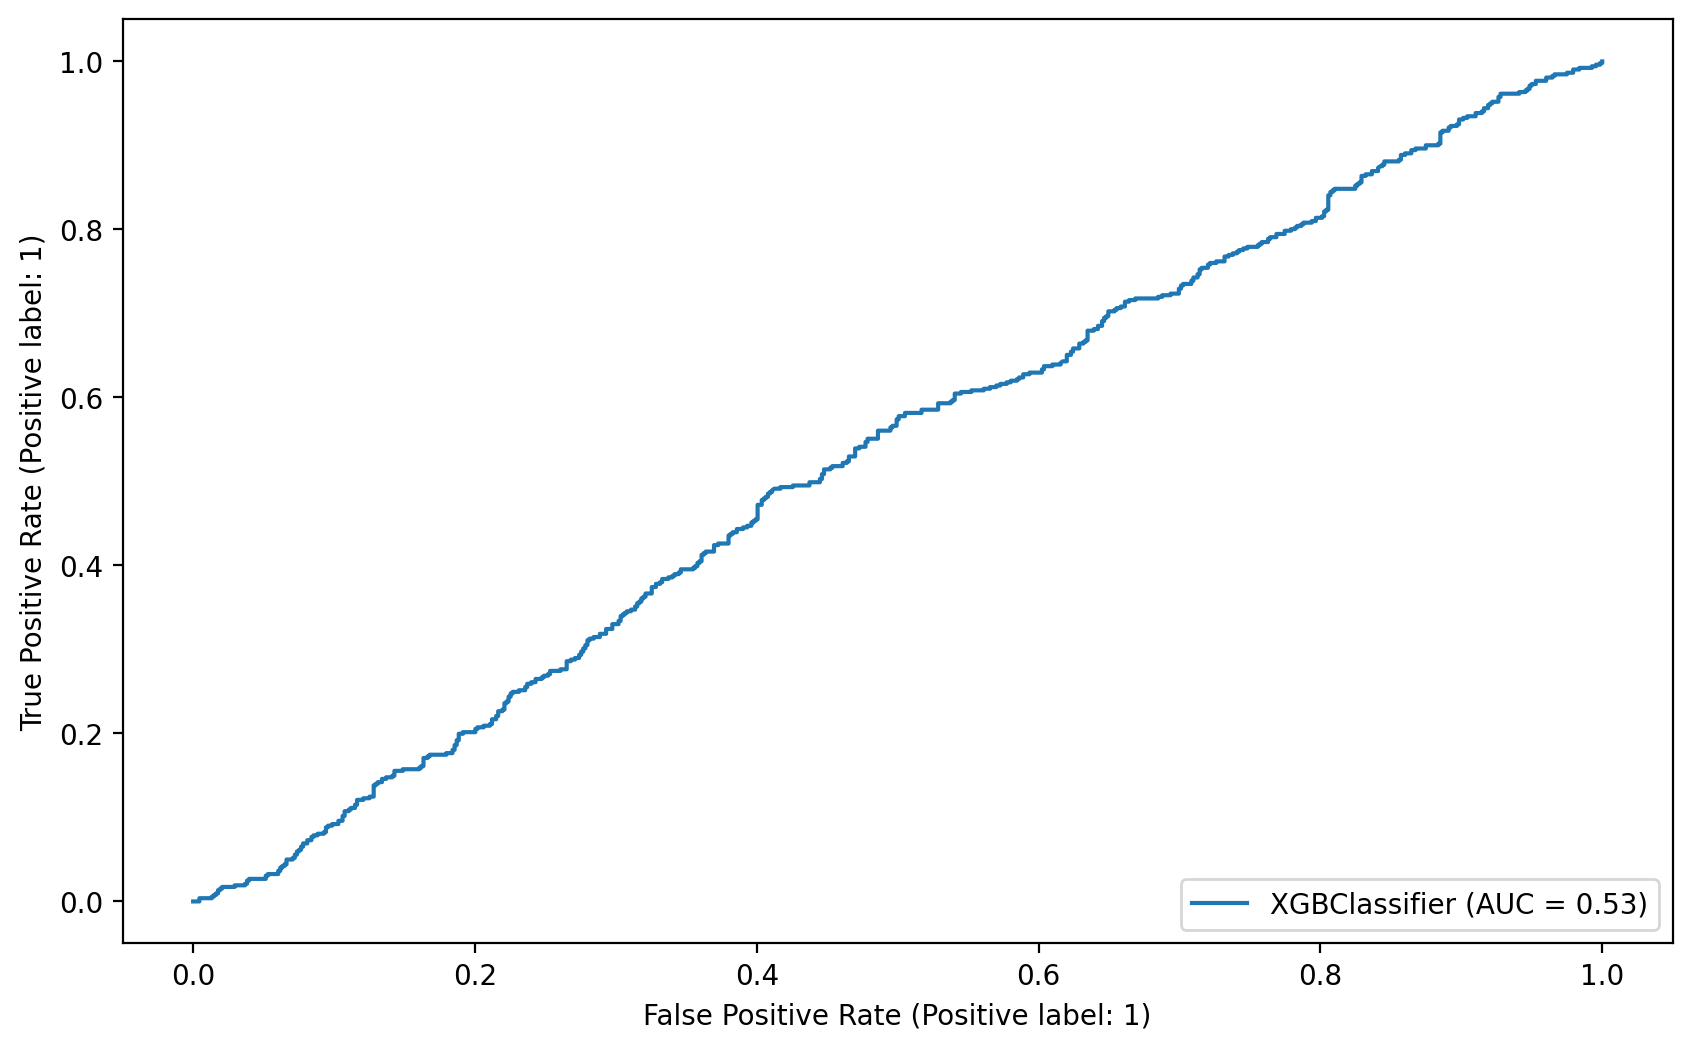

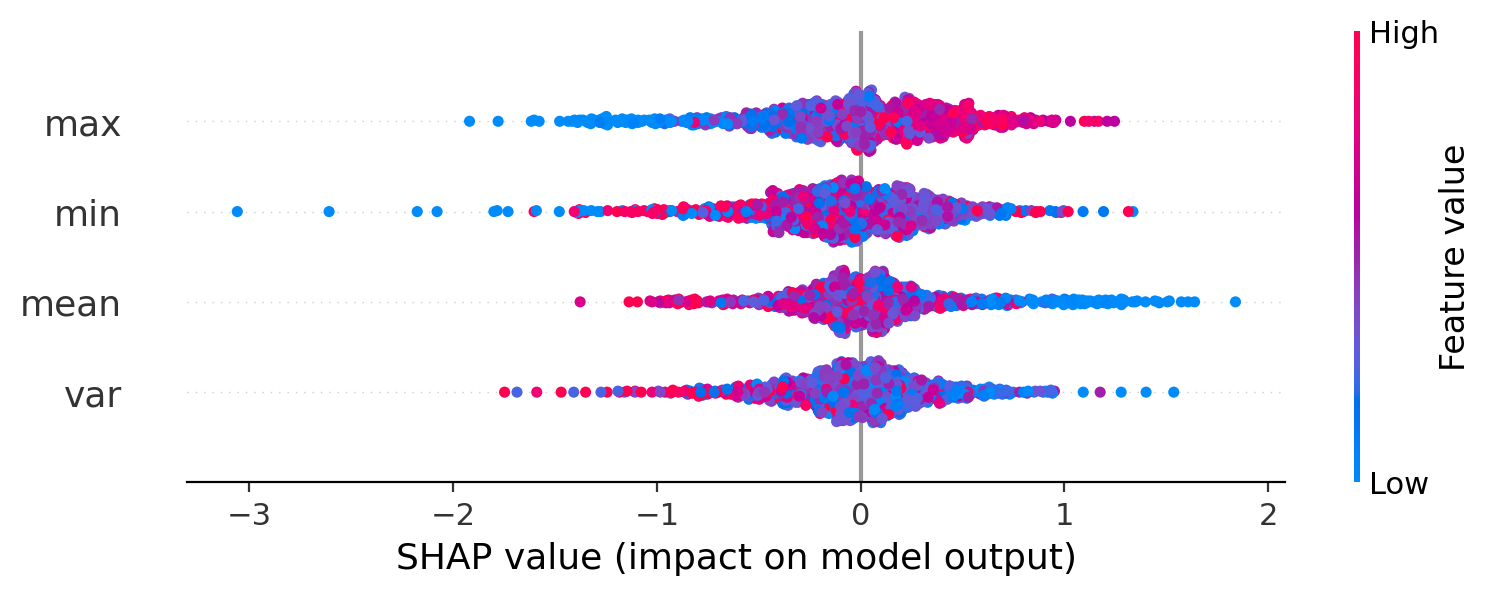

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 2160, number of negative: 2639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450094 -> initscore=-0.200292
[LightGBM] [Info] Start training from score -0.200292
Model name: LGBMClassifier
accuracy_score: 0.5333333333333333
roc_auc_score: 0.5036899735694917
precision_score: 0.4205128205128205
f1_score: 0.3693693693693694


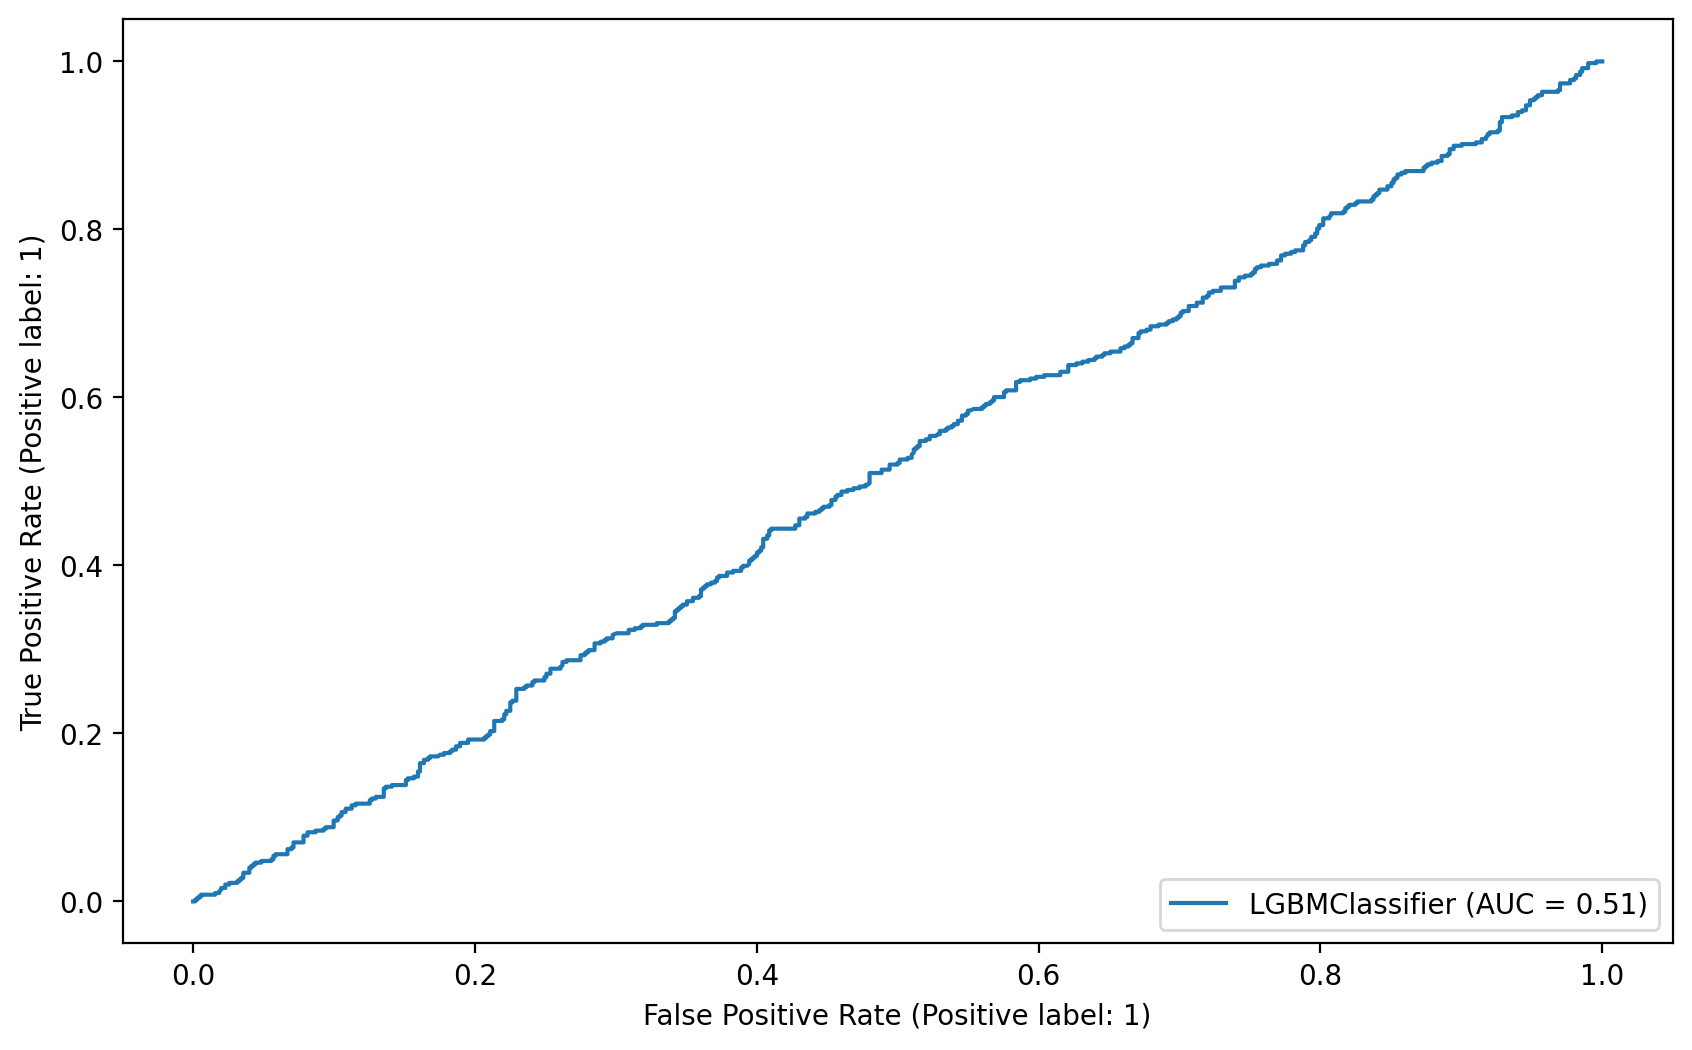

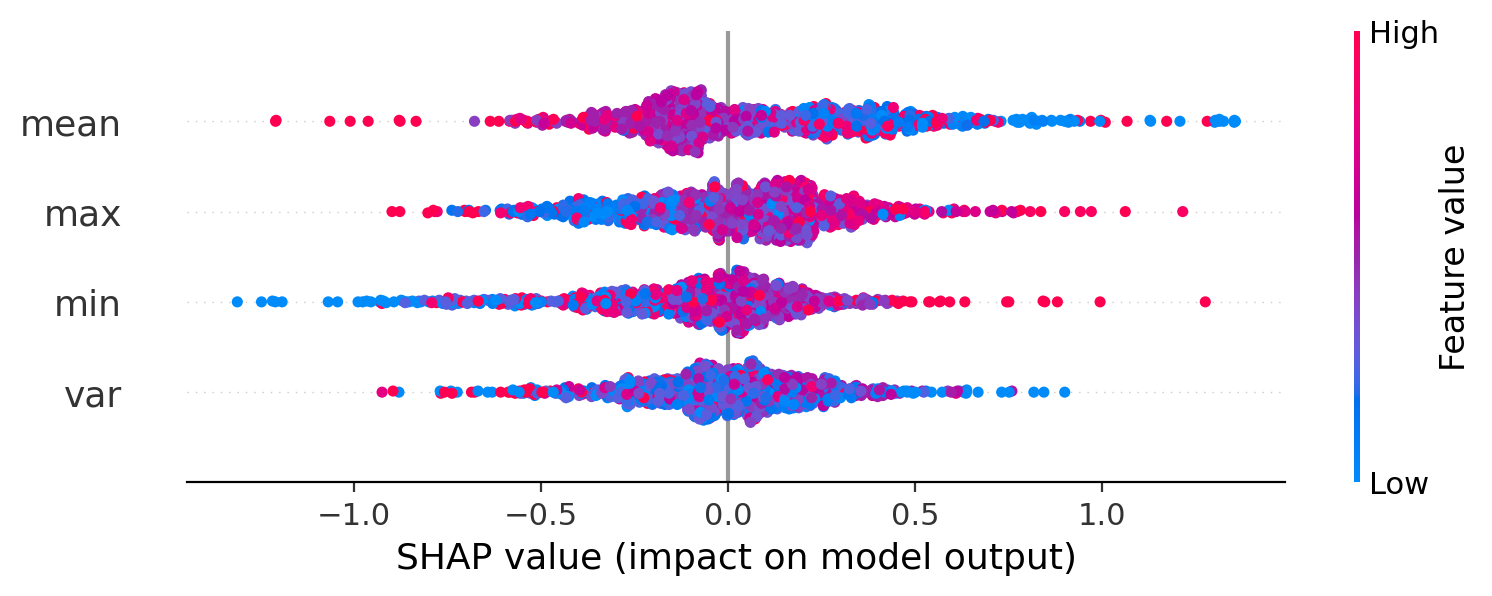

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.5641666666666667
roc_auc_score: 0.49607772060343636
precision_score: 0.2
f1_score: 0.007590132827324478


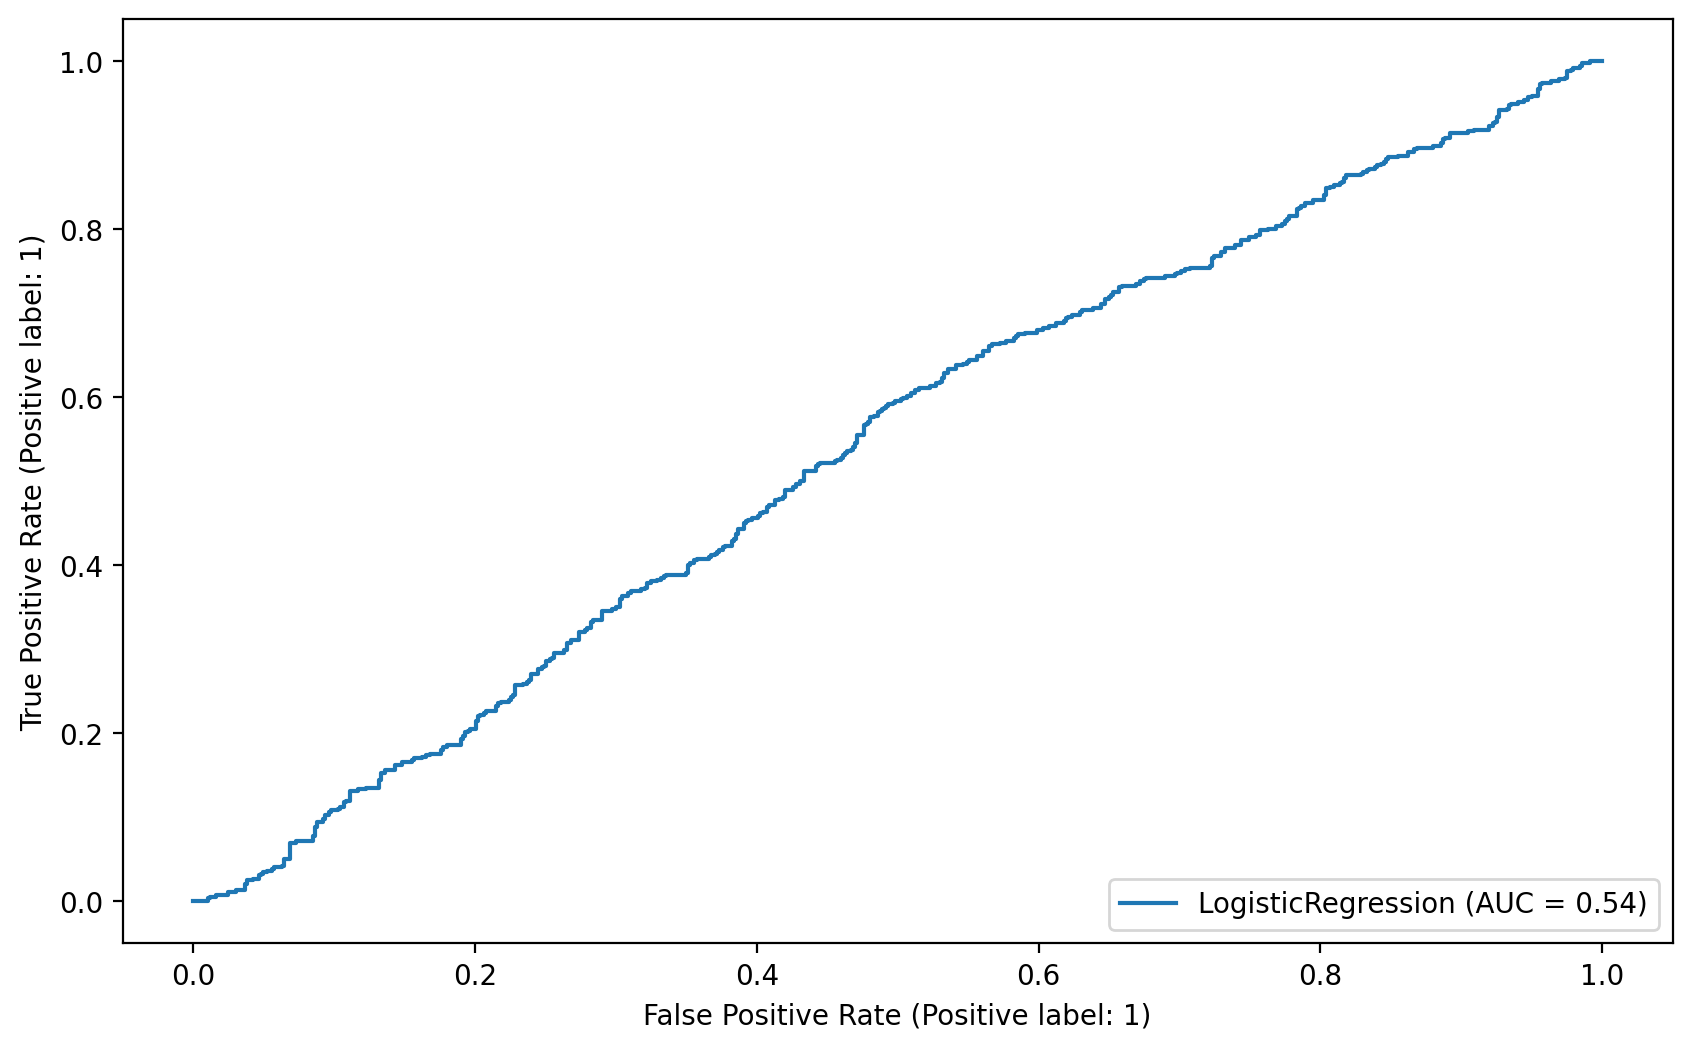

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.53
roc_auc_score: 0.5
precision_score: 0.0
f1_score: 0.0


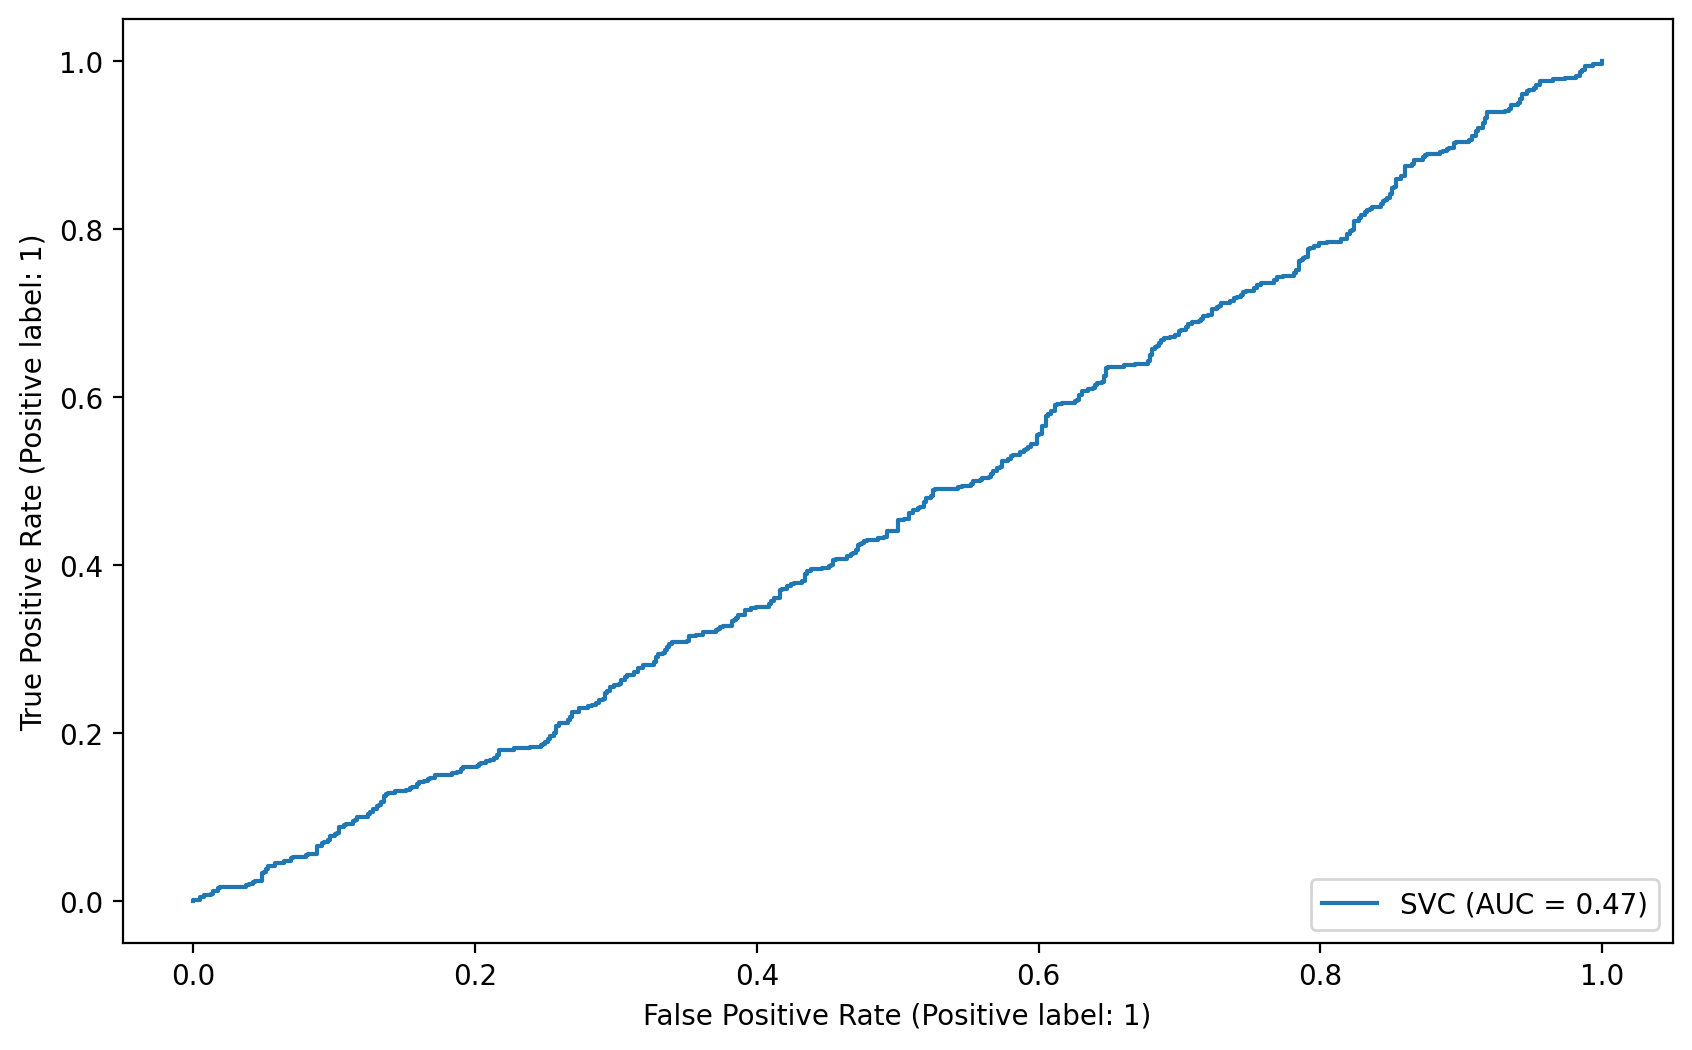

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.5041666666666667
roc_auc_score: 0.4816291930271722
precision_score: 0.3981264637002342
f1_score: 0.36363636363636365


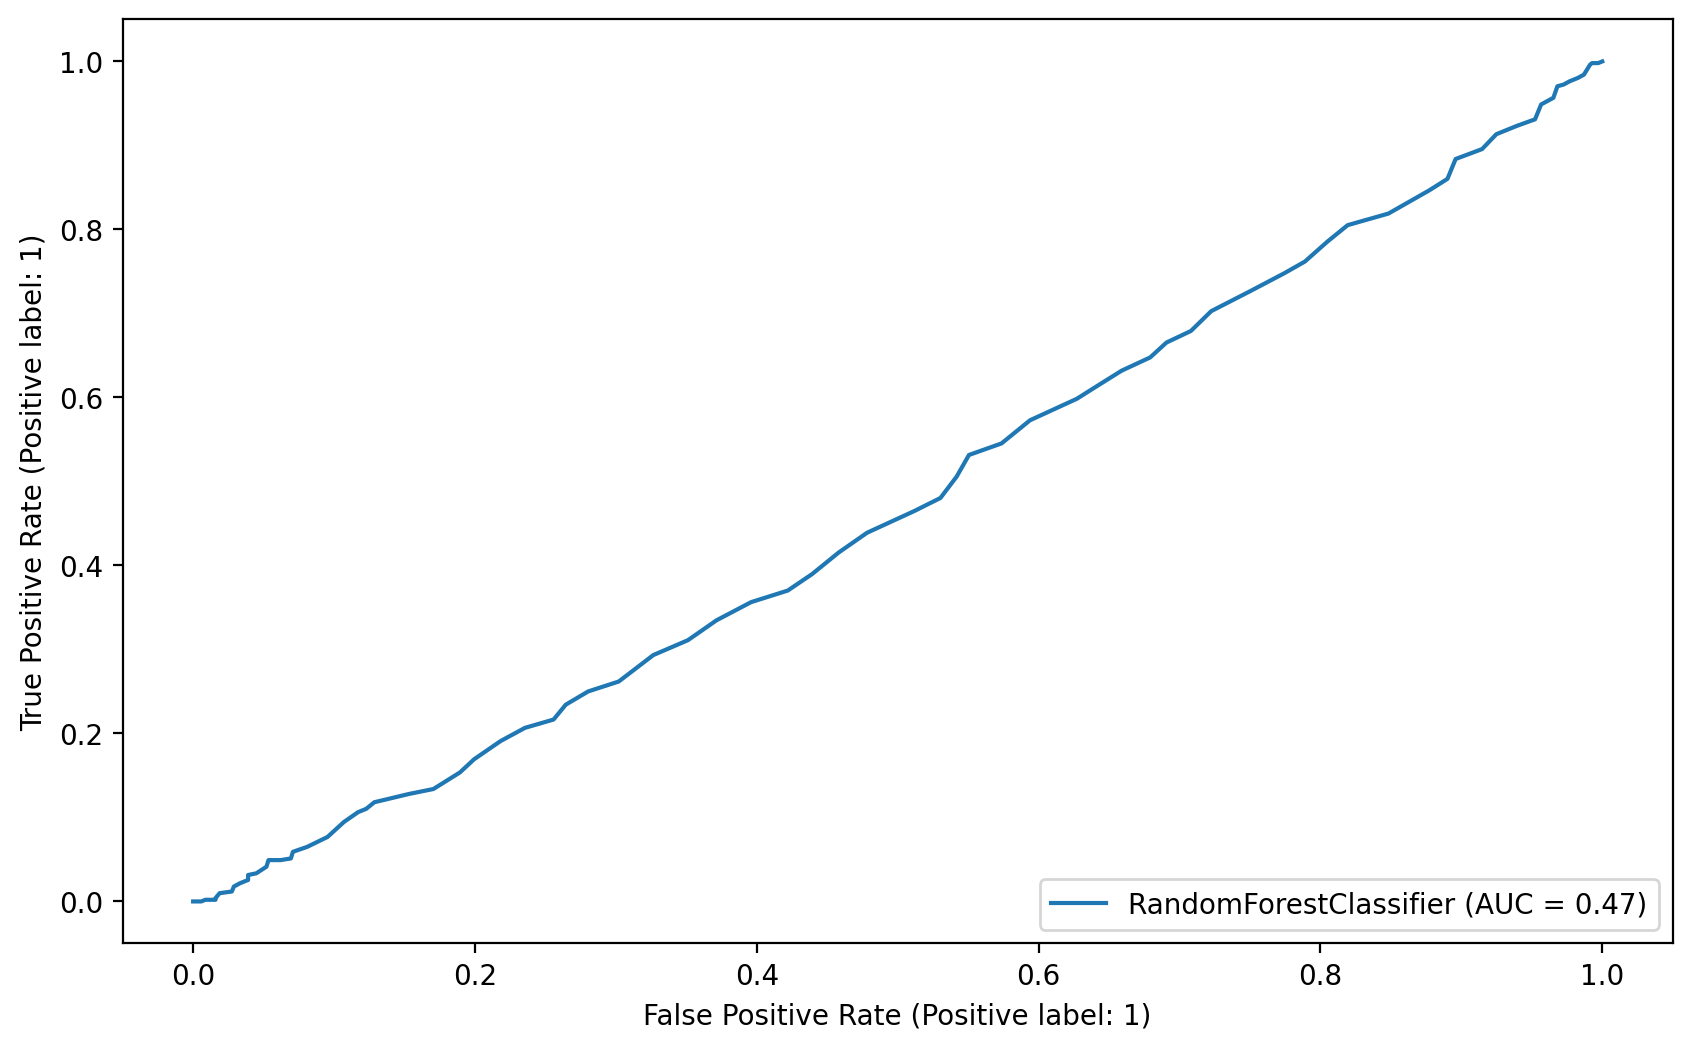

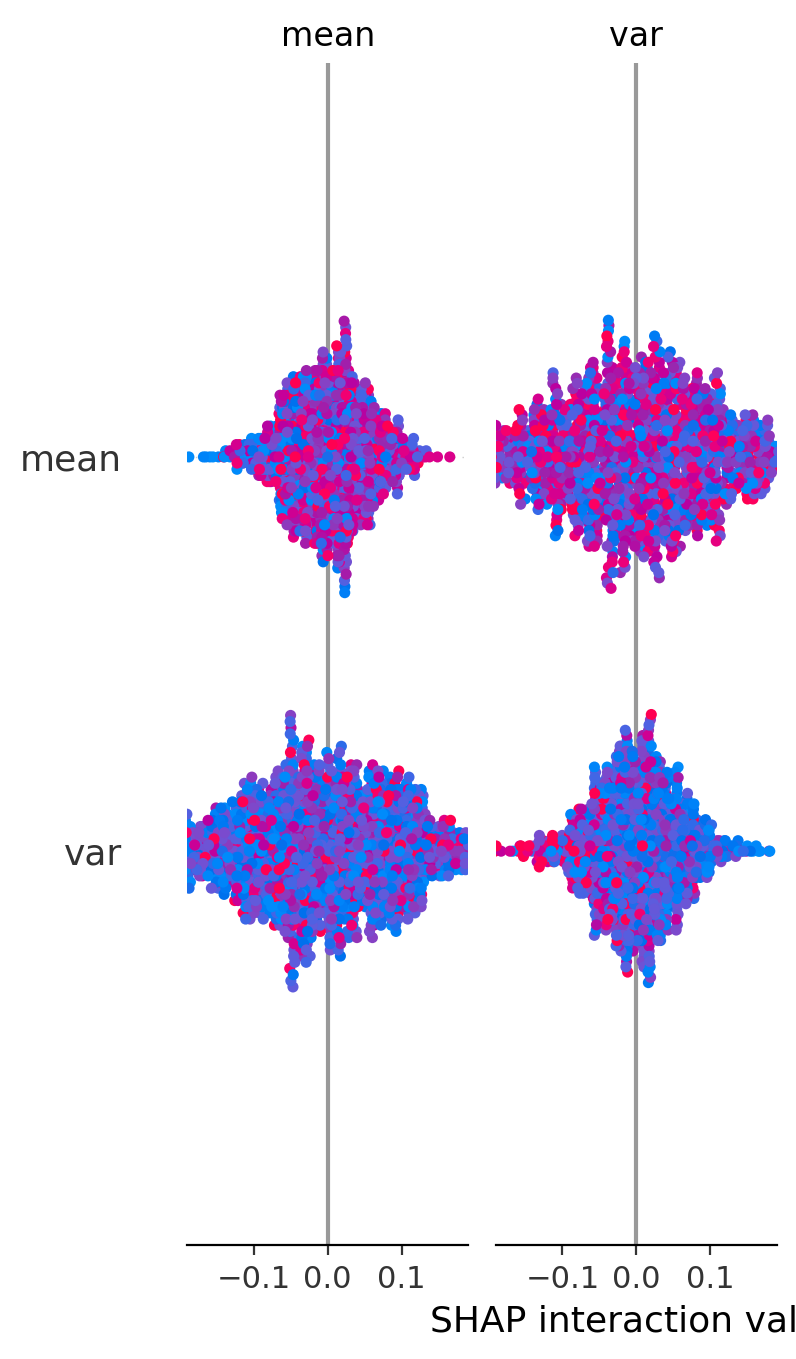

In [ ]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(df.drop(columns=["kurtosis","skew"]),0.2,m["model"],m["name"]))

### 2.3.3  Compare results

In [ ]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
XGBClassifier             0.6033     0.5556  0.5263  0.5405
CatBoostClassifier        0.6092     0.5617  0.5009  0.5296
decision tree             0.5550     0.5026  0.5400  0.5206
basic random forrest      0.5808     0.5238  0.5009  0.5121
LGBMClassifier            0.5875     0.5407  0.4850  0.5114
logistic regression       0.6167     0.5918  0.4361  0.5022
Support vector machine    0.6075     0.5620  0.3953  0.4642
AdaBoostClassifier        0.5833     0.5692  0.3327  0.4200
KNeighborsClassifier      0.5733     0.5299  0.2689  0.3568
Gaussian Naive Bayes      0.5525     0.0000  0.0000  0.0000


### 2.4 best features selection
in this section we will take all the featurs from previous section and attempt to classify using all of them

### 2.4.1  Load data

In [ ]:
df_interval=df_interval.sort_index()
df_interval=df_interval.drop("3",axis=1)

parsed_details=parsed_details.sort_index()
df=df.sort_index()
df=df.drop(columns=["kurtosis","skew"])

join_df=df.copy()

for c in parsed_details.columns:
    join_df[c]=parsed_details[c]
for c in df_interval.columns:
    join_df[c]=df_interval[c]
join_df

mean          var   min   max  Label      ECO_A  \
ABCi         1463.333333   739.022222  1406  1502      0  20.000000   
ABSBEGINNER  1344.142276  1451.811736  1241  1426      0   5.826558   
ADJUSTOR     1878.373218  1864.929391  1745  1994      1  18.660907   
AFCERGY      1571.542036  1115.665047  1461  1677      0  26.934436   
AFRF         1364.376000  1022.746624  1278  1456      1  20.840000   
...                  ...          ...   ...   ...    ...        ...   
zwartspeler  1821.970471  1499.353478  1724  1925      0  29.130088   
zwirek        985.571429   452.530612   951  1016      1  42.857143   
zxtxf        1332.290323  1331.109261  1252  1408      1  58.064516   
zyrq         1478.447326  2225.900386  1373  1590      0  20.907618   
zzyxx        1497.287770  1376.881217  1418  1597      0  27.338129   

                 ECO_B      ECO_C      ECO_D      ECO_E  PlyCountMean  \
ABCi         26.666667   0.000000  26.666667  26.666667     67.533333   
ABSBEGINNER  23.983740  56.436314  13.346883   0.406504     79.505420   
ADJUSTOR     35.485961  36.090713   0.215983   9.546436     75.049676   
AFCERGY      30.379996   0.472534  30.399685  11.813349     85.253790   
AFRF         55.560000  23.080000   0.440000   0.080000     65.696400   
...                ...        ...        ...        ...           ...   
zwartspeler  29.449322   1.436552  20.430966  19.553073     81.717478   
zwirek       14.285714  14.285714  28.571429   0.000000     74.428571   
zxtxf        25.806452   6.451613   6.451613   3.225806     69.483871   
zyrq         36.628849  11.669368  30.470016   0.324149     63.868720   
zzyxx        40.647482  16.906475   5.755396   9.352518     66.766187   

             PlyCountVar  PlyCountSkew  TotalGames       0       1       2  
ABCi          683.048889      0.758514          15  1458.0  1429.0  1457.0  
ABSBEGINNER   984.621244      0.525922        1476  1317.0  1356.0  1289.0  
ADJUSTOR      518.122802      0.190994        4630  1893.0  1862.0  1917.0  
AFCERGY       882.118894     -0.074684        5079  1532.0  1637.0  1600.0  
AFRF          870.892227      1.512712        2500  1353.0  1387.0  1285.0  
...                  ...           ...         ...     ...     ...     ...  
zwartspeler   888.628880      0.479423        1253  1821.0  1818.0  1812.0  
zwirek       1457.959184      0.729793           7   951.0   963.0  1016.0  
zxtxf         743.798127      0.253001          31  1331.0  1362.0  1309.0  
zyrq          806.648892      0.699075         617  1496.0  1464.0  1402.0  
zzyxx         993.596411      0.552998         278  1534.0  1495.0  1517.0  

[5999 rows x 17 columns]

### 2.4.2  Run classification model

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.5541666666666667
roc_auc_score: 0.5478239709008941
precision_score: 0.474169741697417
f1_score: 0.4899904671115348


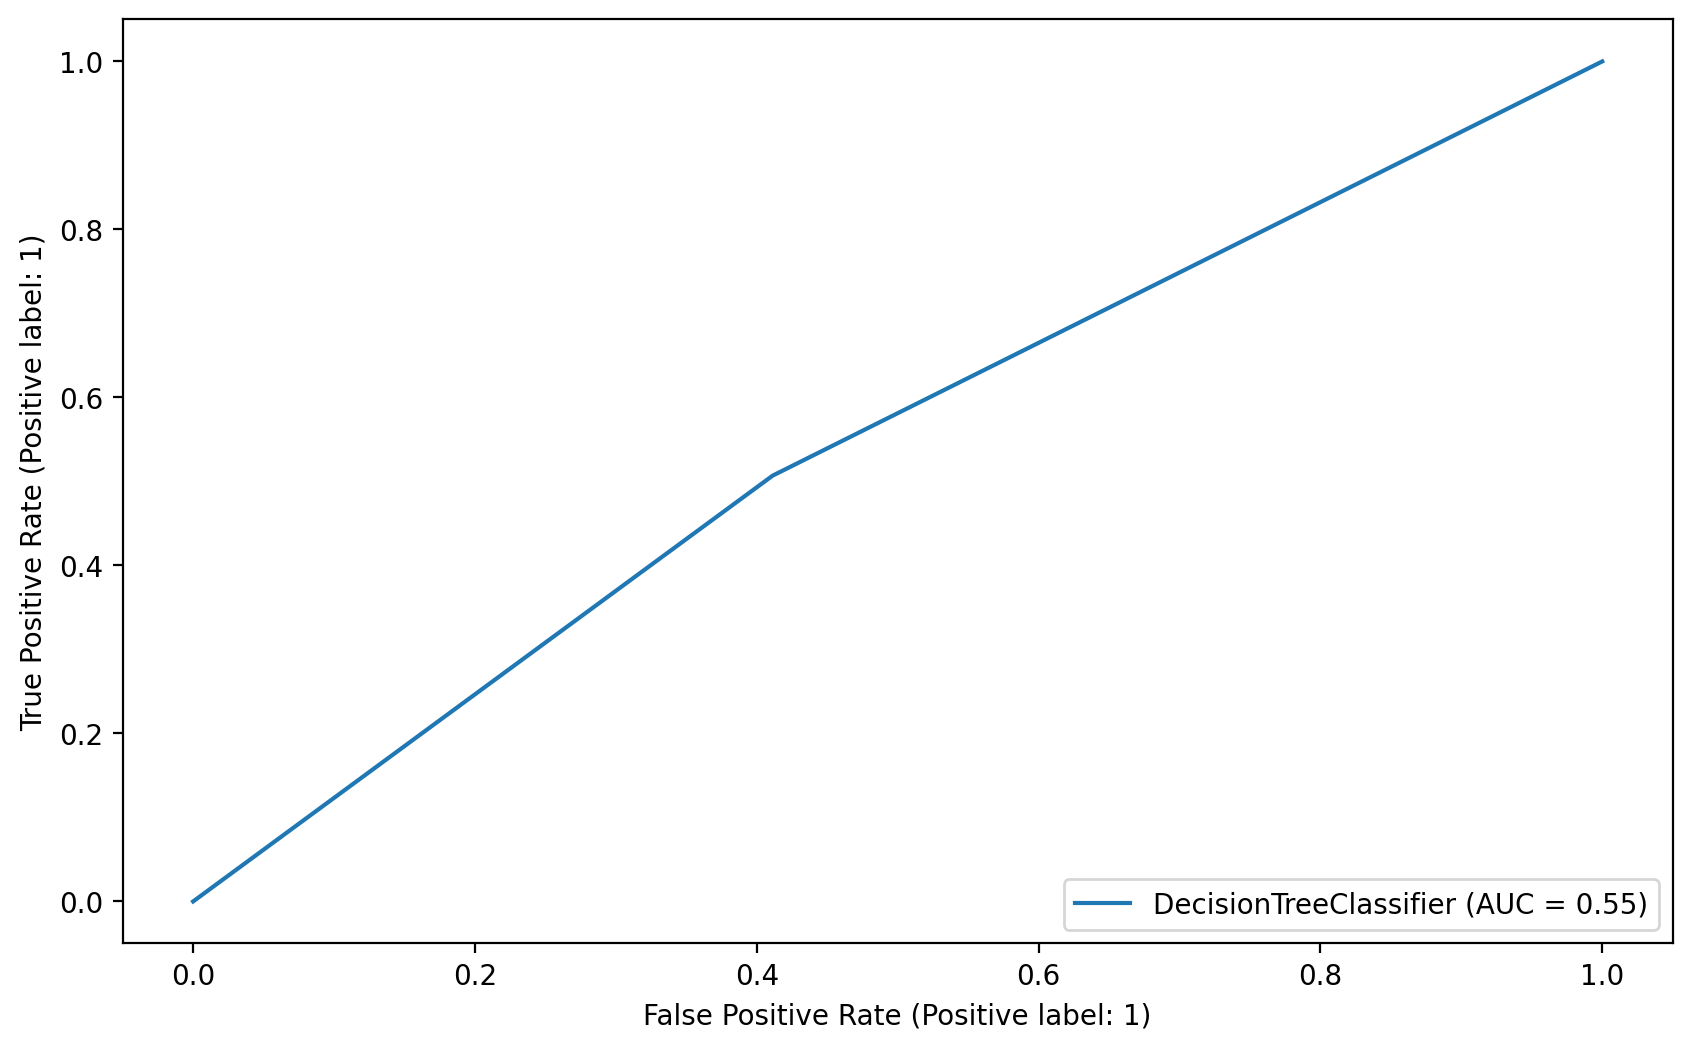

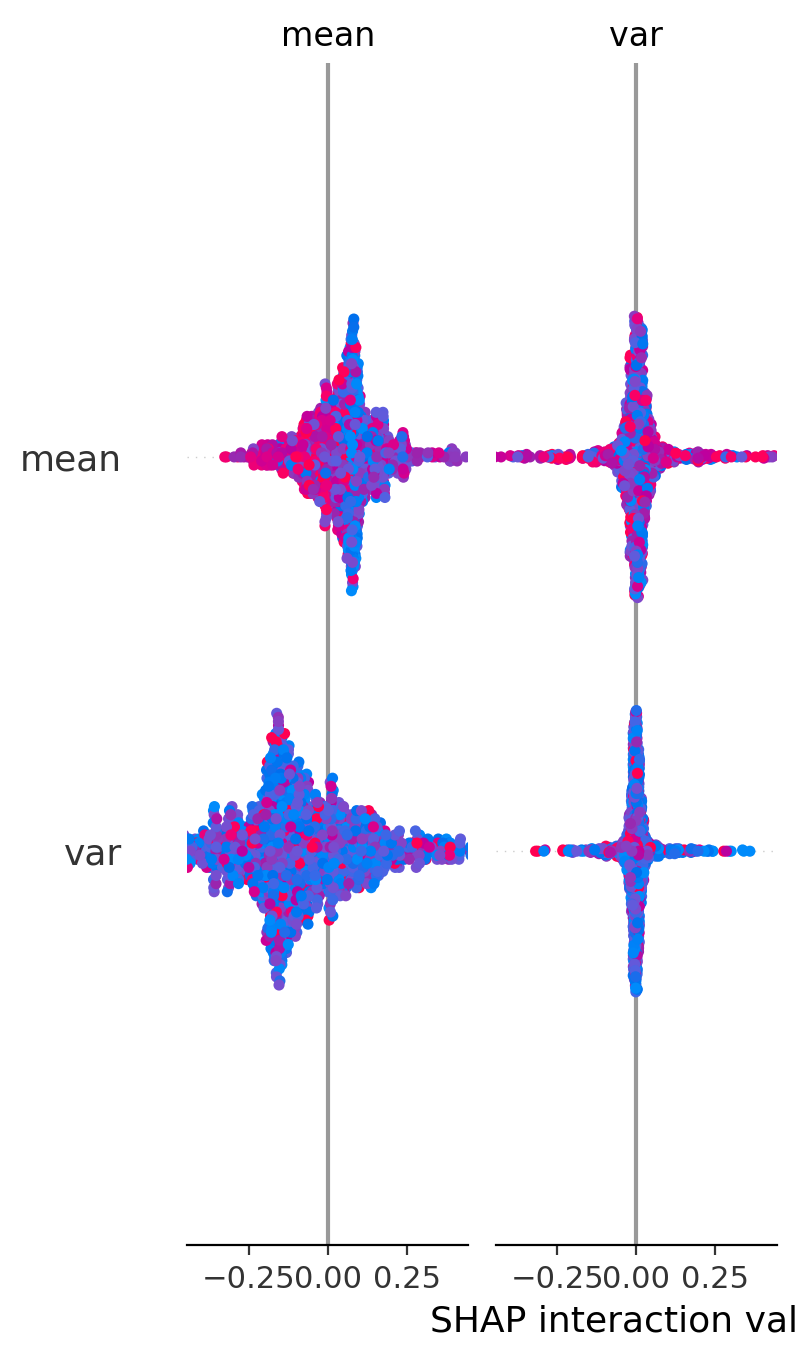

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.485
roc_auc_score: 0.49524945021406713
precision_score: 0.4150664697193501
f1_score: 0.47627118644067795


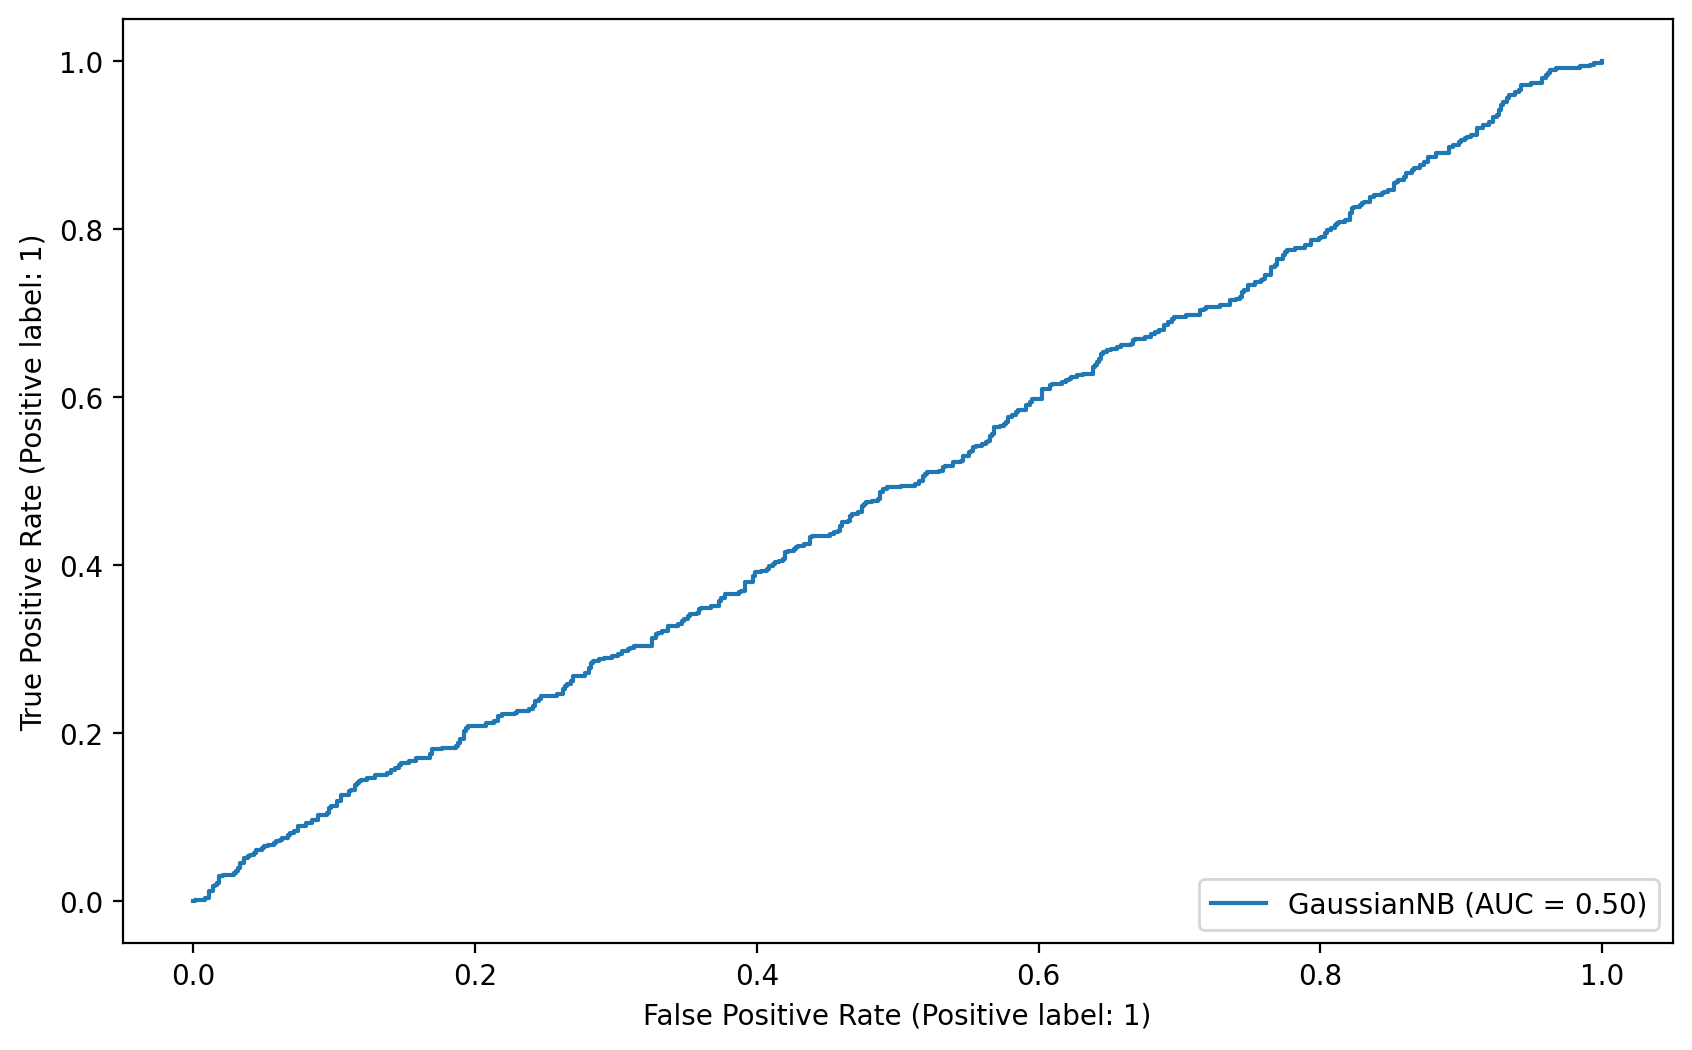

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.5383333333333333
roc_auc_score: 0.505773906282134
precision_score: 0.45353159851301117
f1_score: 0.30576441102756896


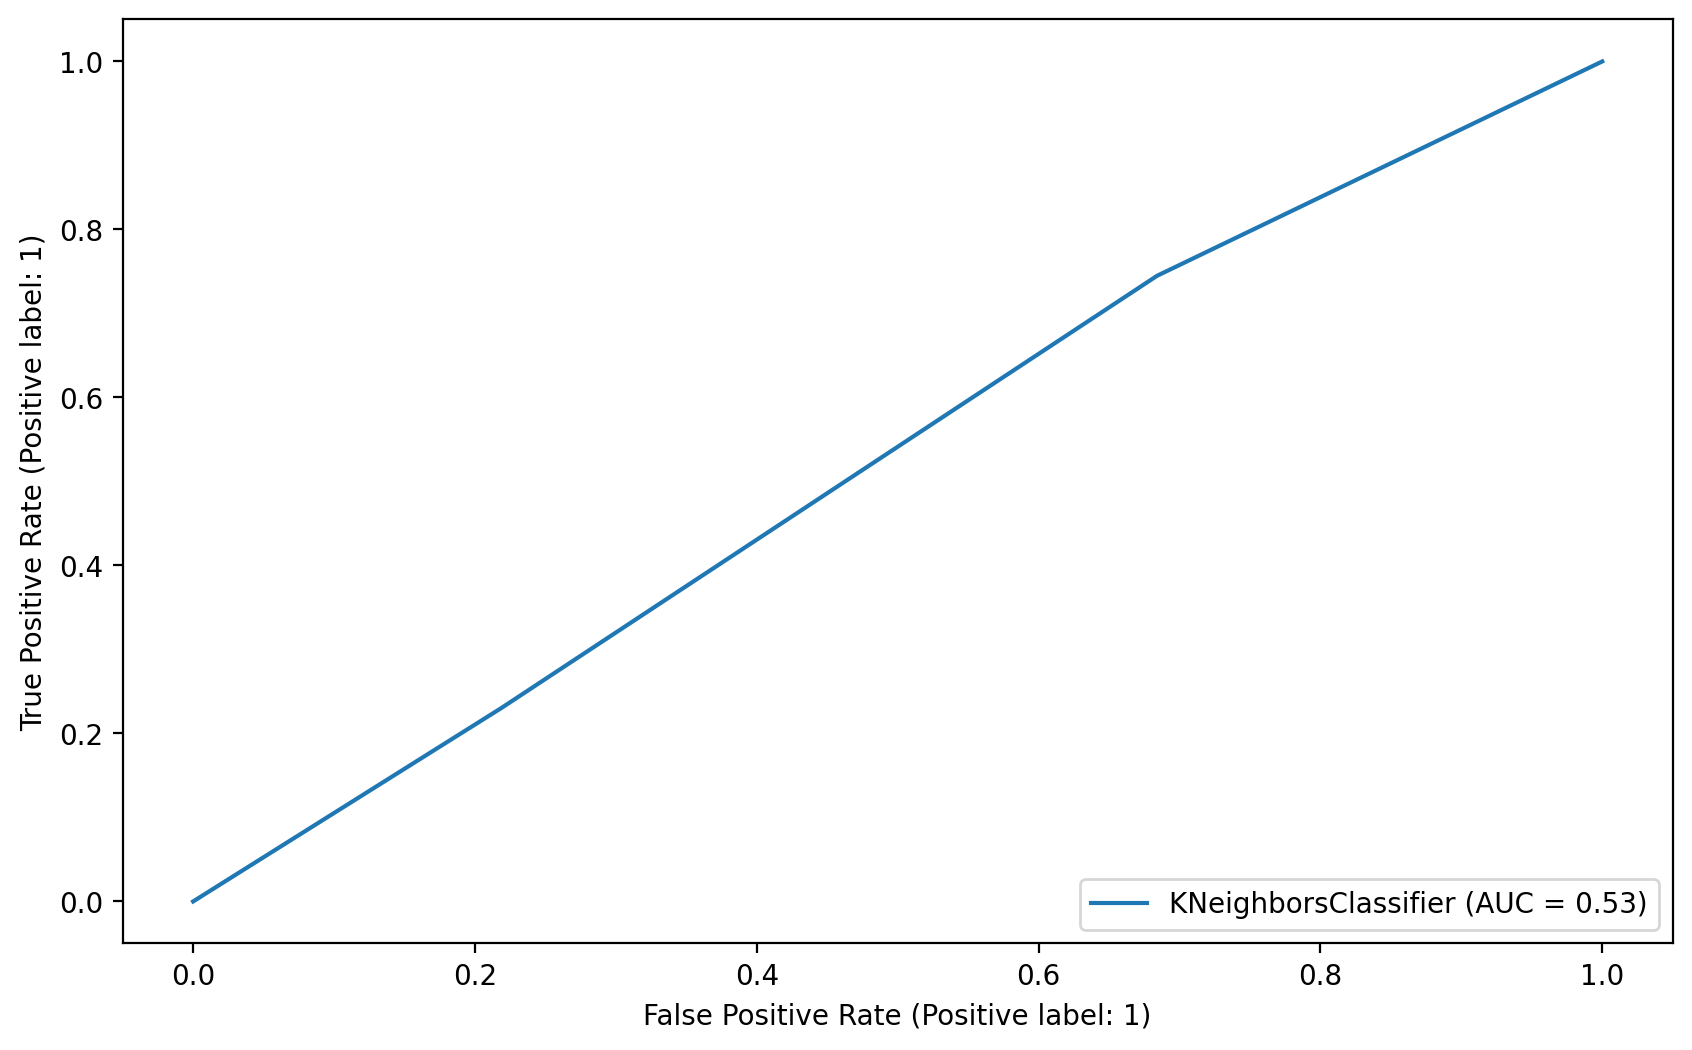

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.595
roc_auc_score: 0.5682032117910781
precision_score: 0.5507246376811594
f1_score: 0.43879907621247116


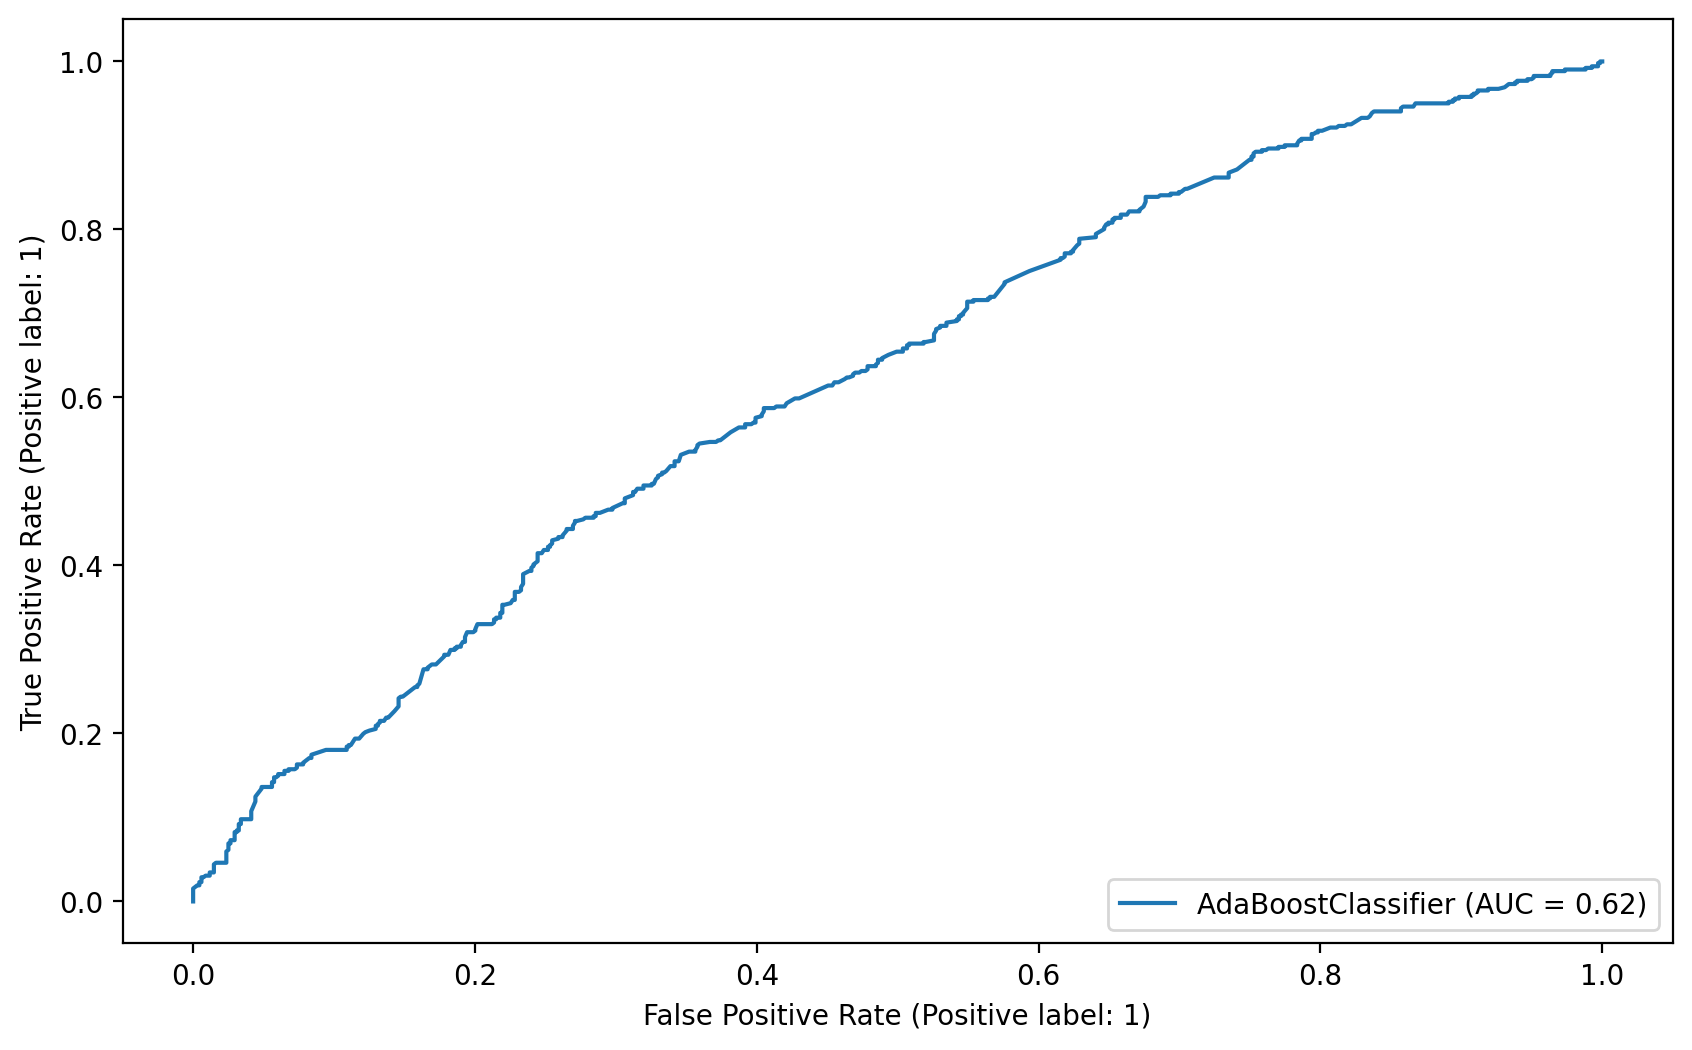

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6922244	total: 1.63ms	remaining: 1.63s
1:	learn: 0.6916559	total: 3.05ms	remaining: 1.52s
2:	learn: 0.6908984	total: 4.18ms	remaining: 1.39s
3:	learn: 0.6904698	total: 5.32ms	remaining: 1.32s
4:	learn: 0.6899414	total: 6.41ms	remaining: 1.27s
5:	learn: 0.6893922	total: 7.52ms	remaining: 1.25s
6:	learn: 0.6886300	total: 8.6ms	remaining: 1.22s
7:	learn: 0.6881481	total: 9.73ms	remaining: 1.21s
8:	learn: 0.6872569	total: 10.8ms	remaining: 1.19s
9:	learn: 0.6866728	total: 11.9ms	remaining: 1.18s
10:	learn: 0.6862847	total: 13ms	remaining: 1.17s
11:	learn: 0.6853715	total: 14.1ms	remaining: 1.16s
12:	learn: 0.6847769	total: 15.1ms	remaining: 1.15s
13:	learn: 0.6843734	total: 16.9ms	remaining: 1.19s
14:	learn: 0.6838085	total: 18ms	remaining: 1.18s
15:	learn: 0.6832185	total: 19.1ms	remaining: 1.17s
16:	learn: 0.6826226	total: 20.1

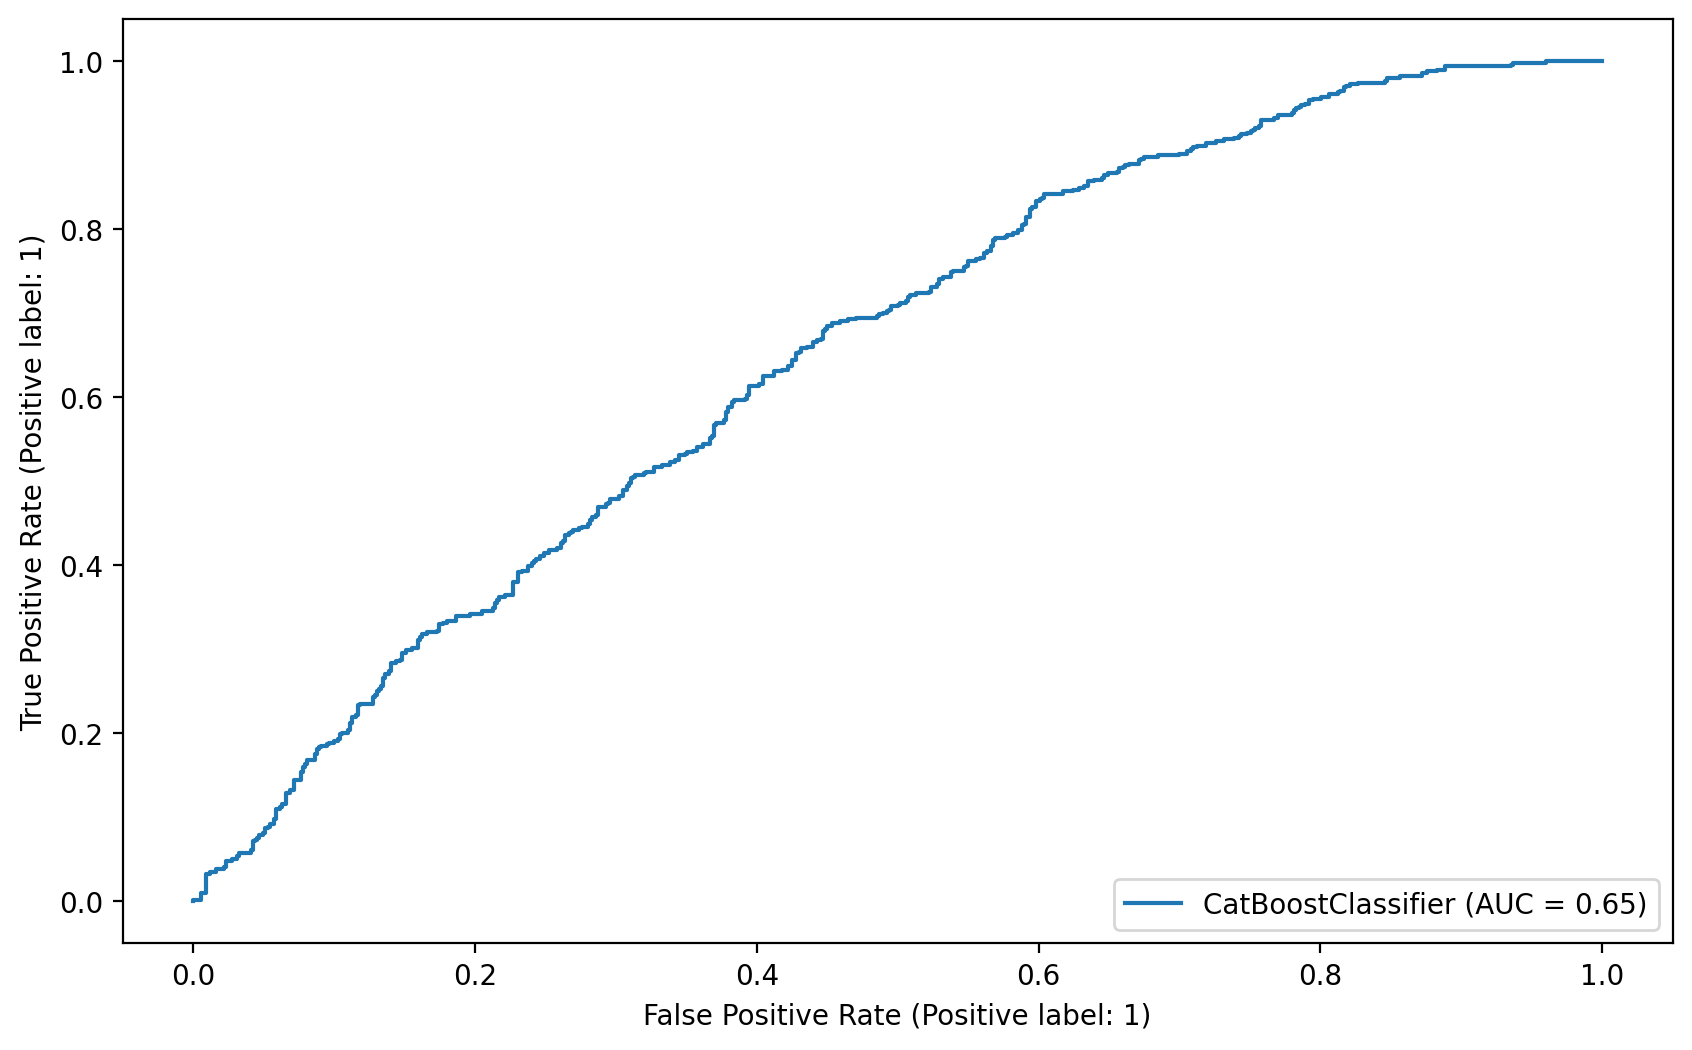

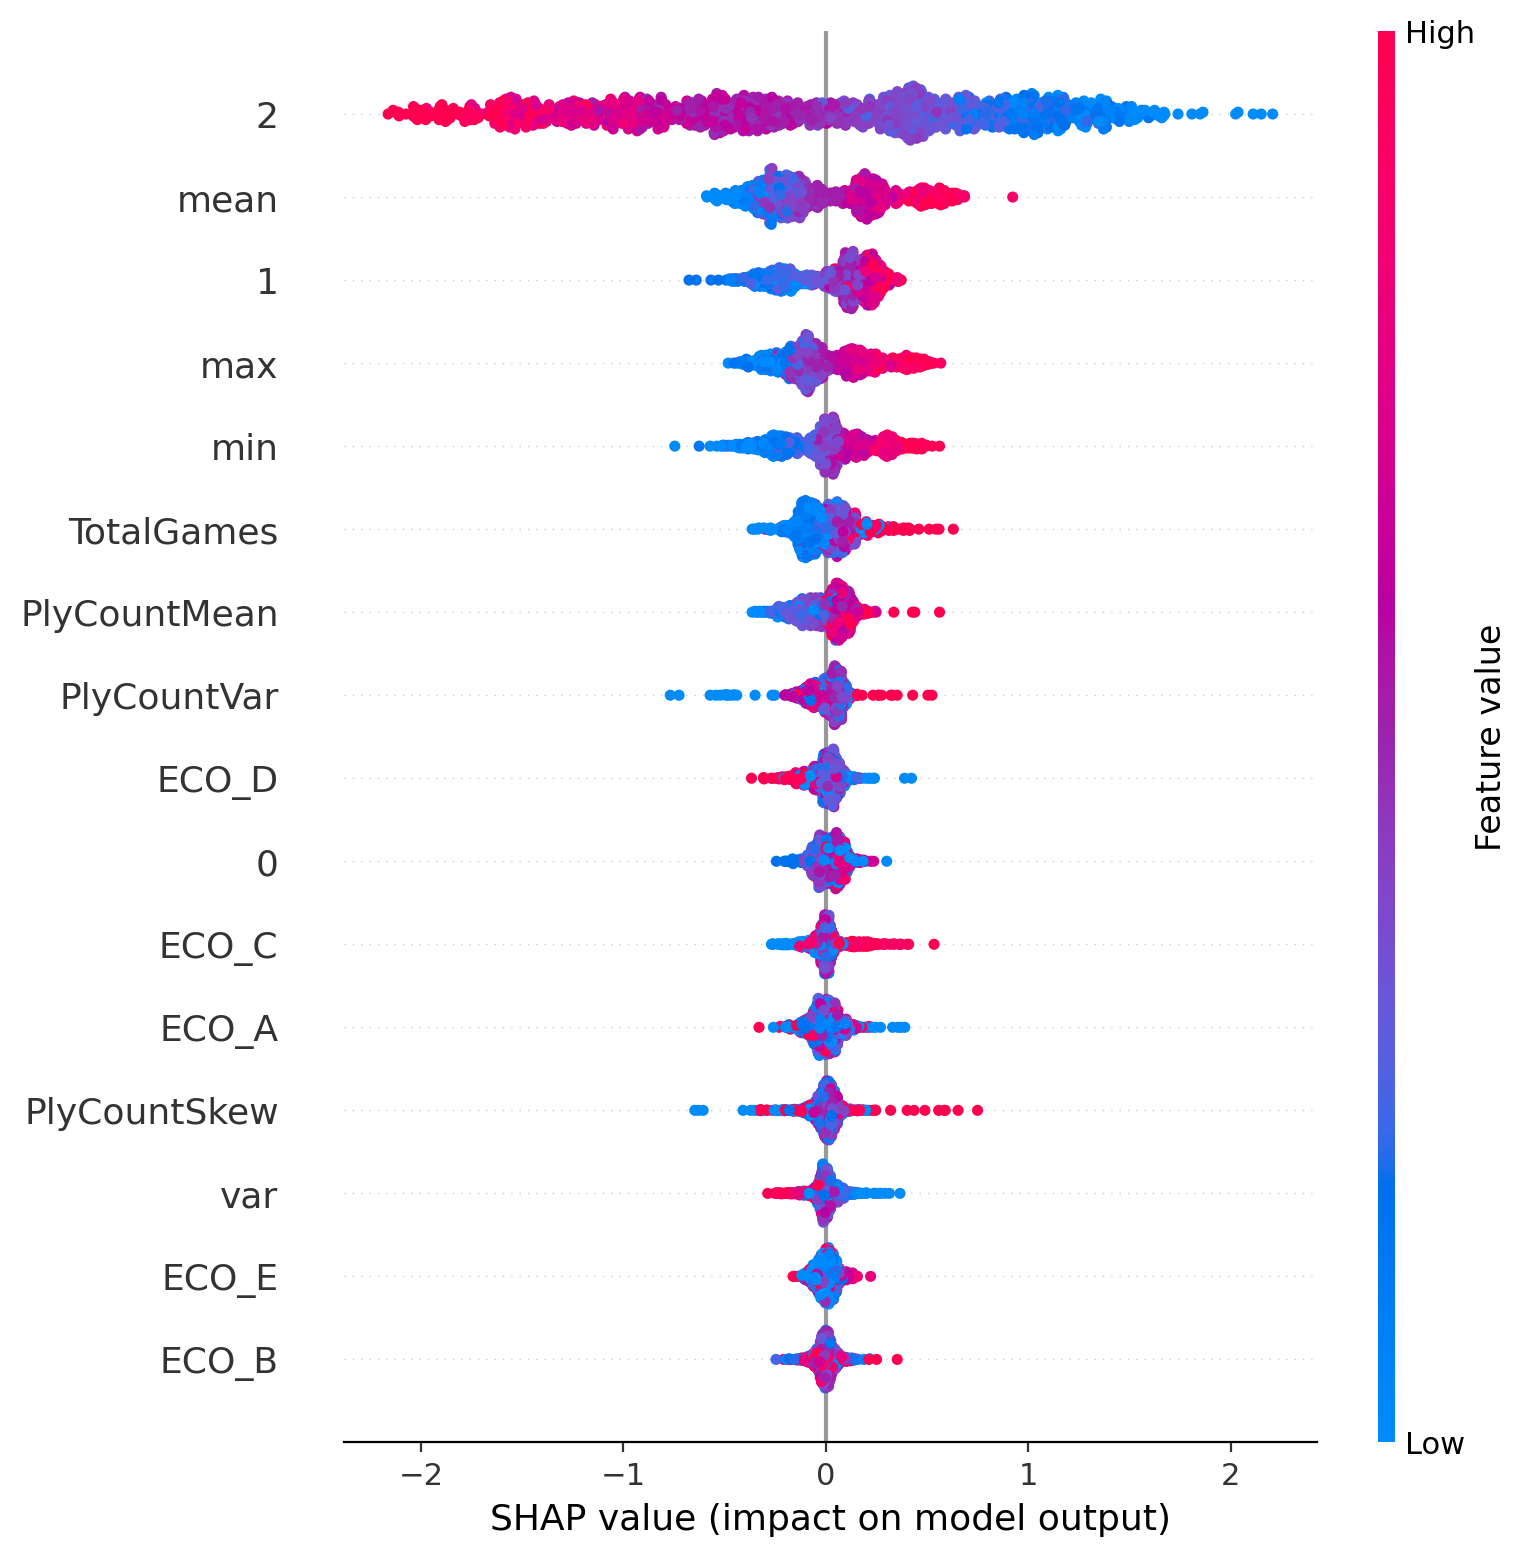

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.6225
roc_auc_score: 0.6111253196930946
precision_score: 0.558282208588957
f1_score: 0.5465465465465466


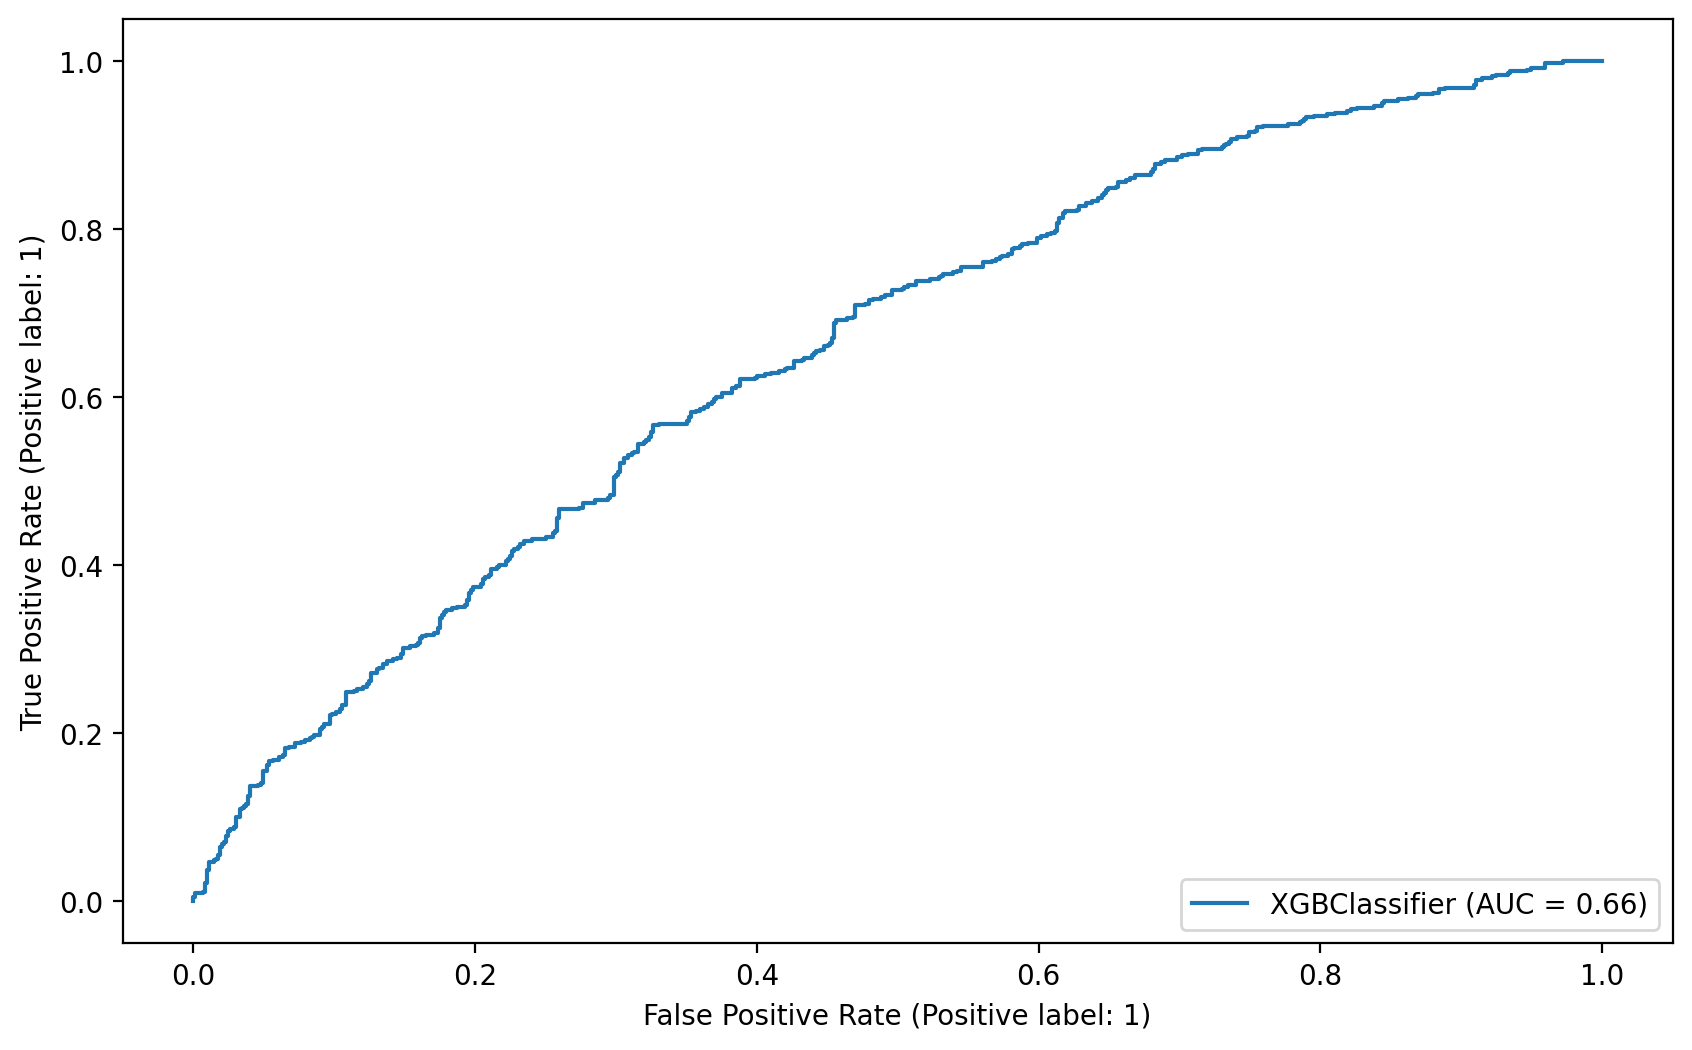

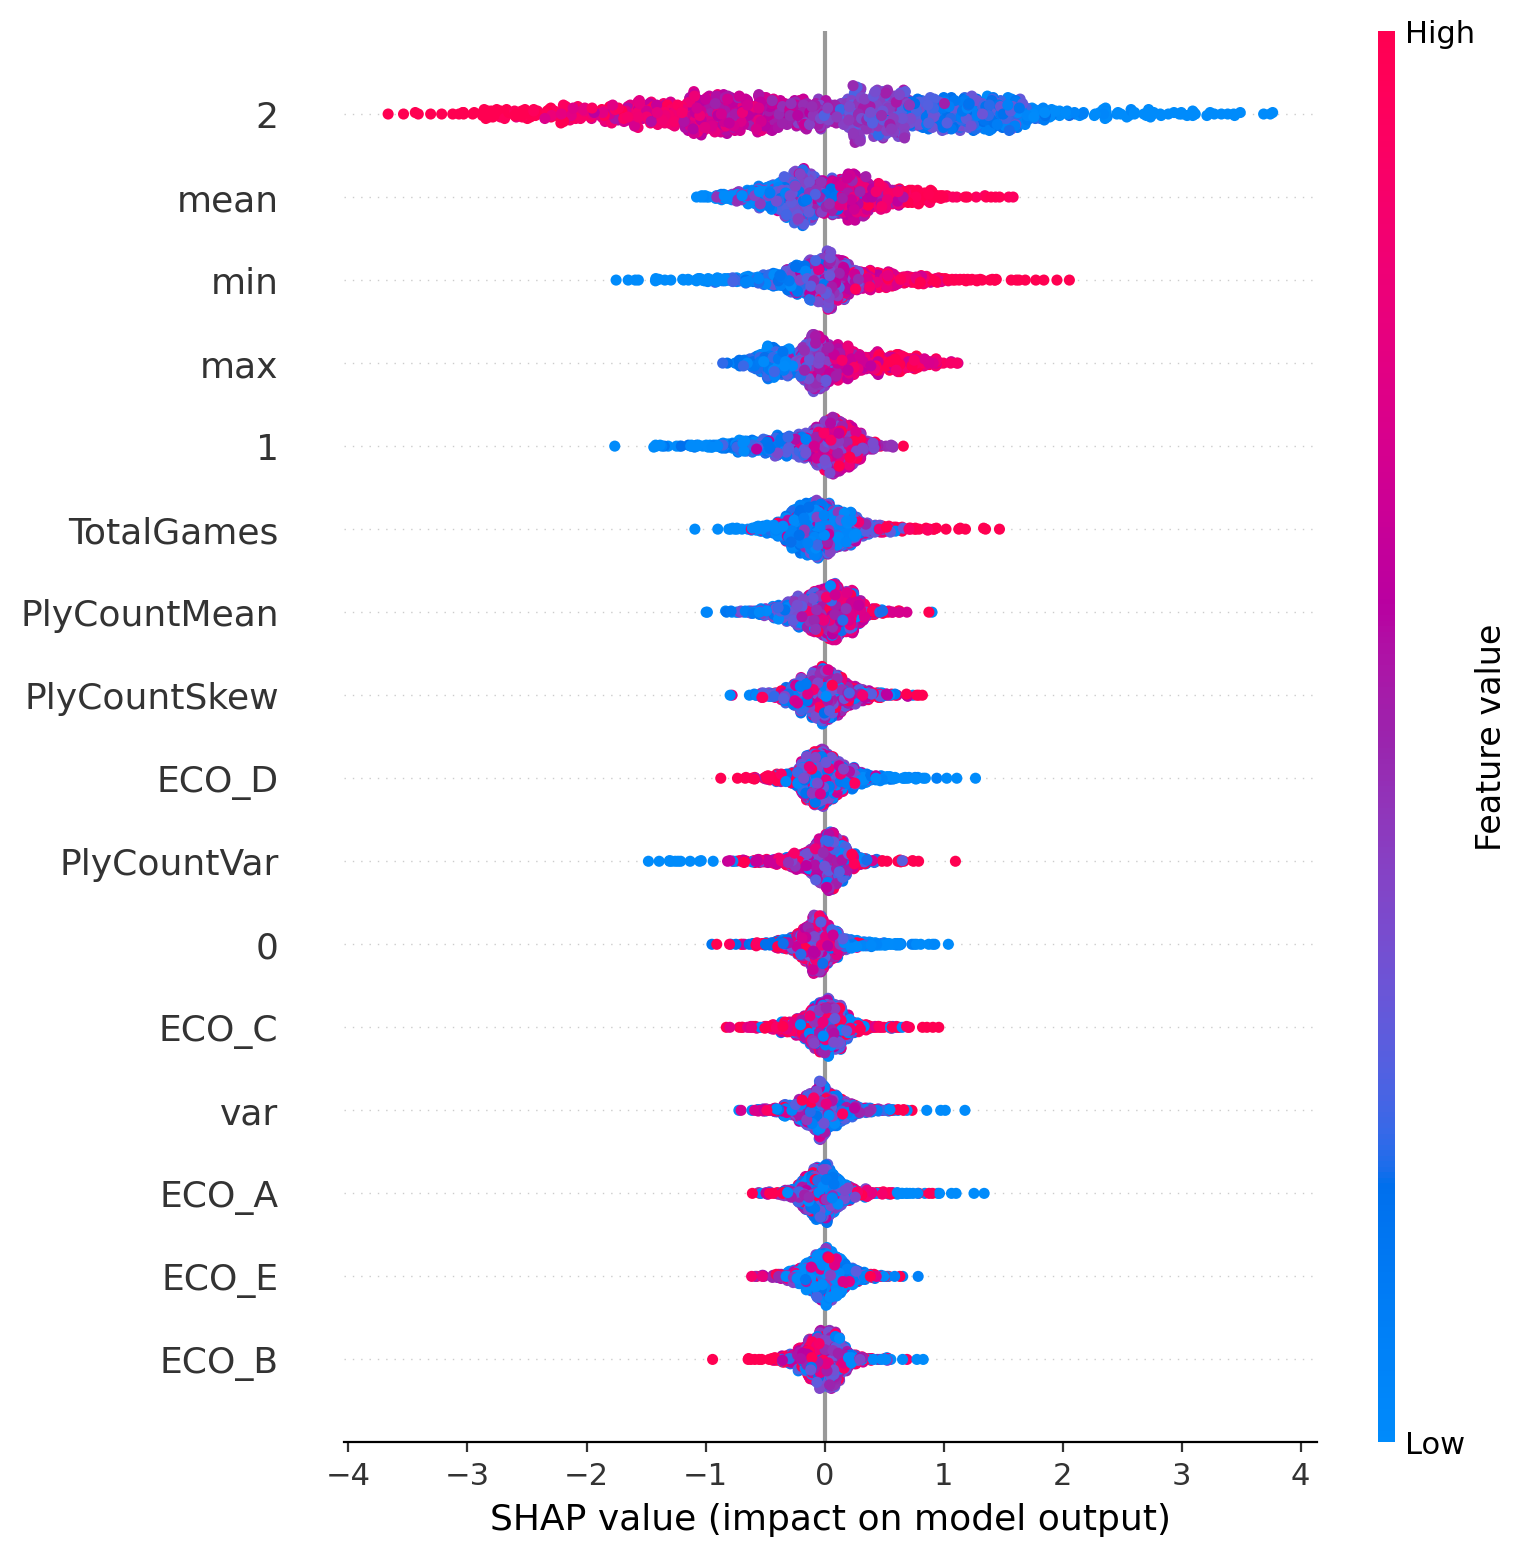

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 2115, number of negative: 2684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.440717 -> initscore=-0.238253
[LightGBM] [Info] Start training from score -0.238253
Model name: LGBMClassifier
accuracy_score: 0.6166666666666667
roc_auc_score: 0.604068383830739
precision_score: 0.5967365967365967
f1_score: 0.5267489711934157


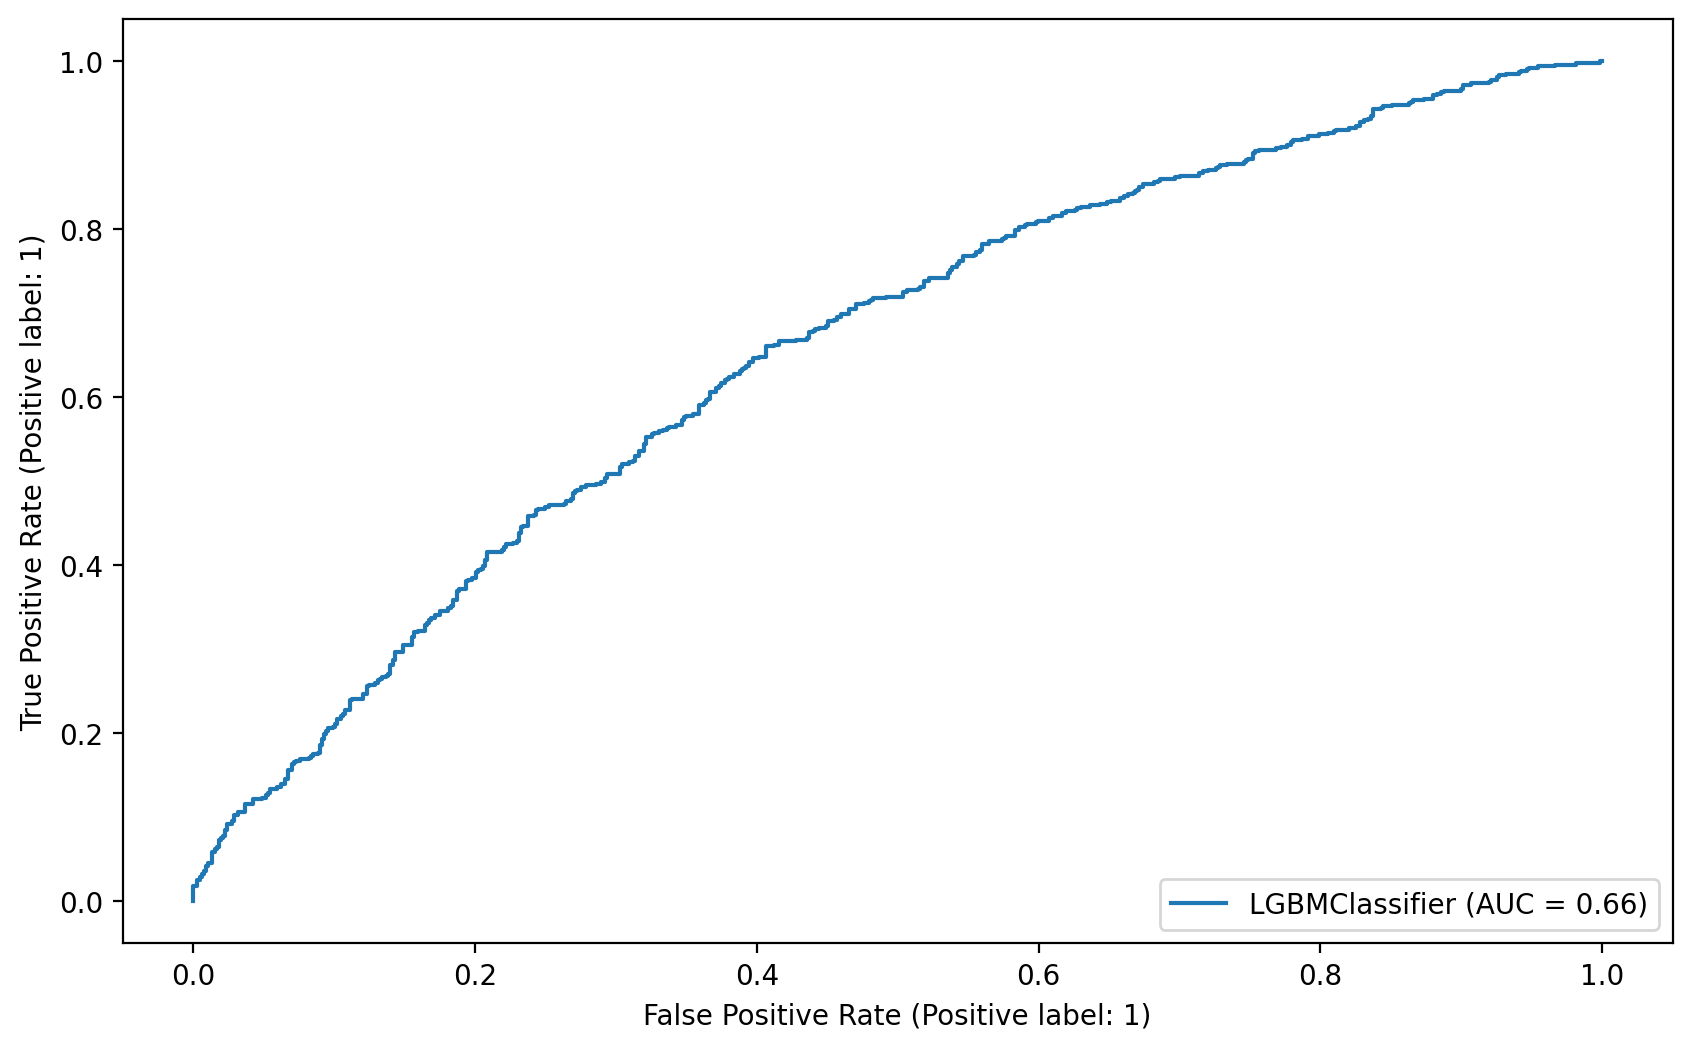

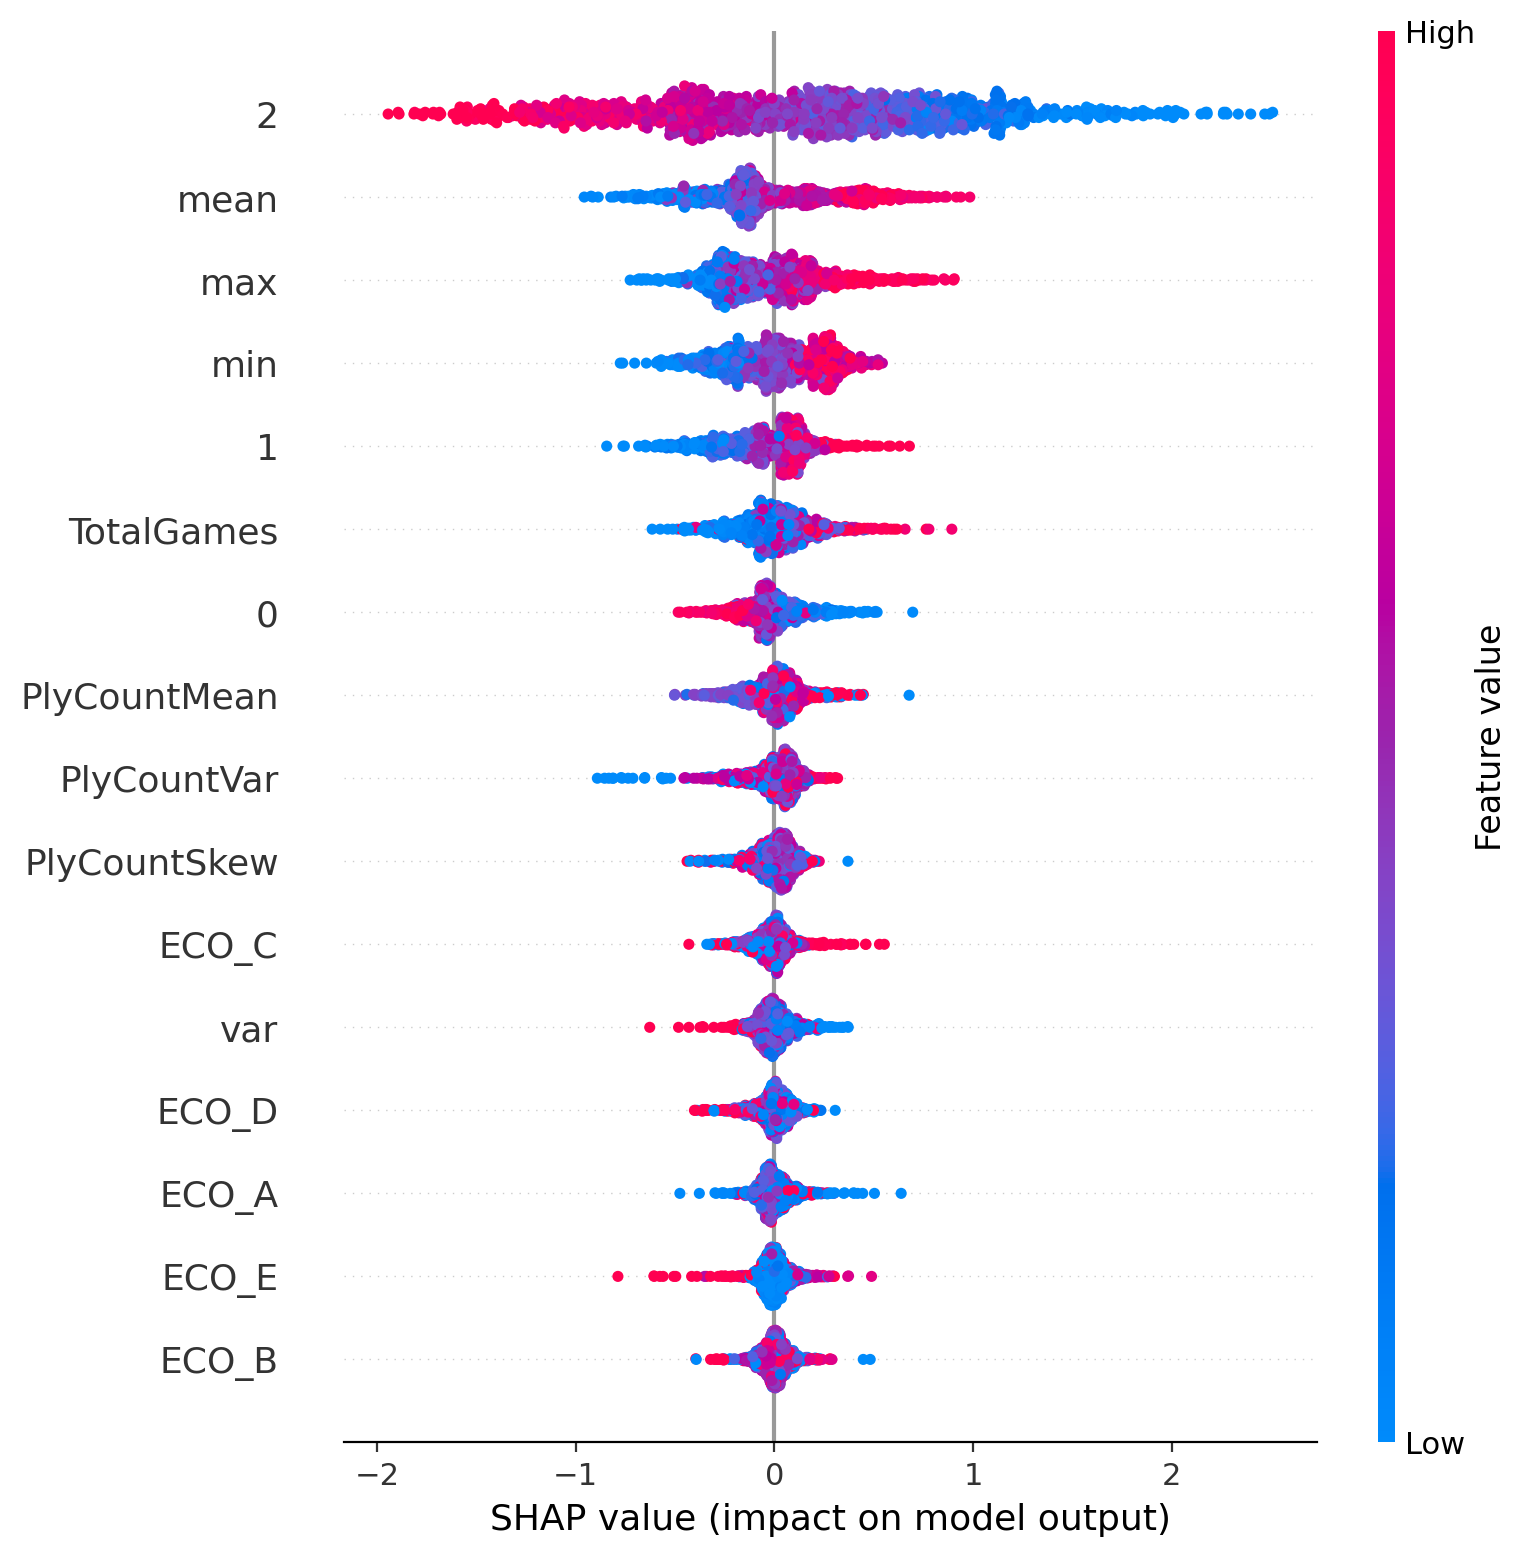

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6233333333333333
roc_auc_score: 0.6090678682061392
precision_score: 0.589041095890411
f1_score: 0.5330578512396694


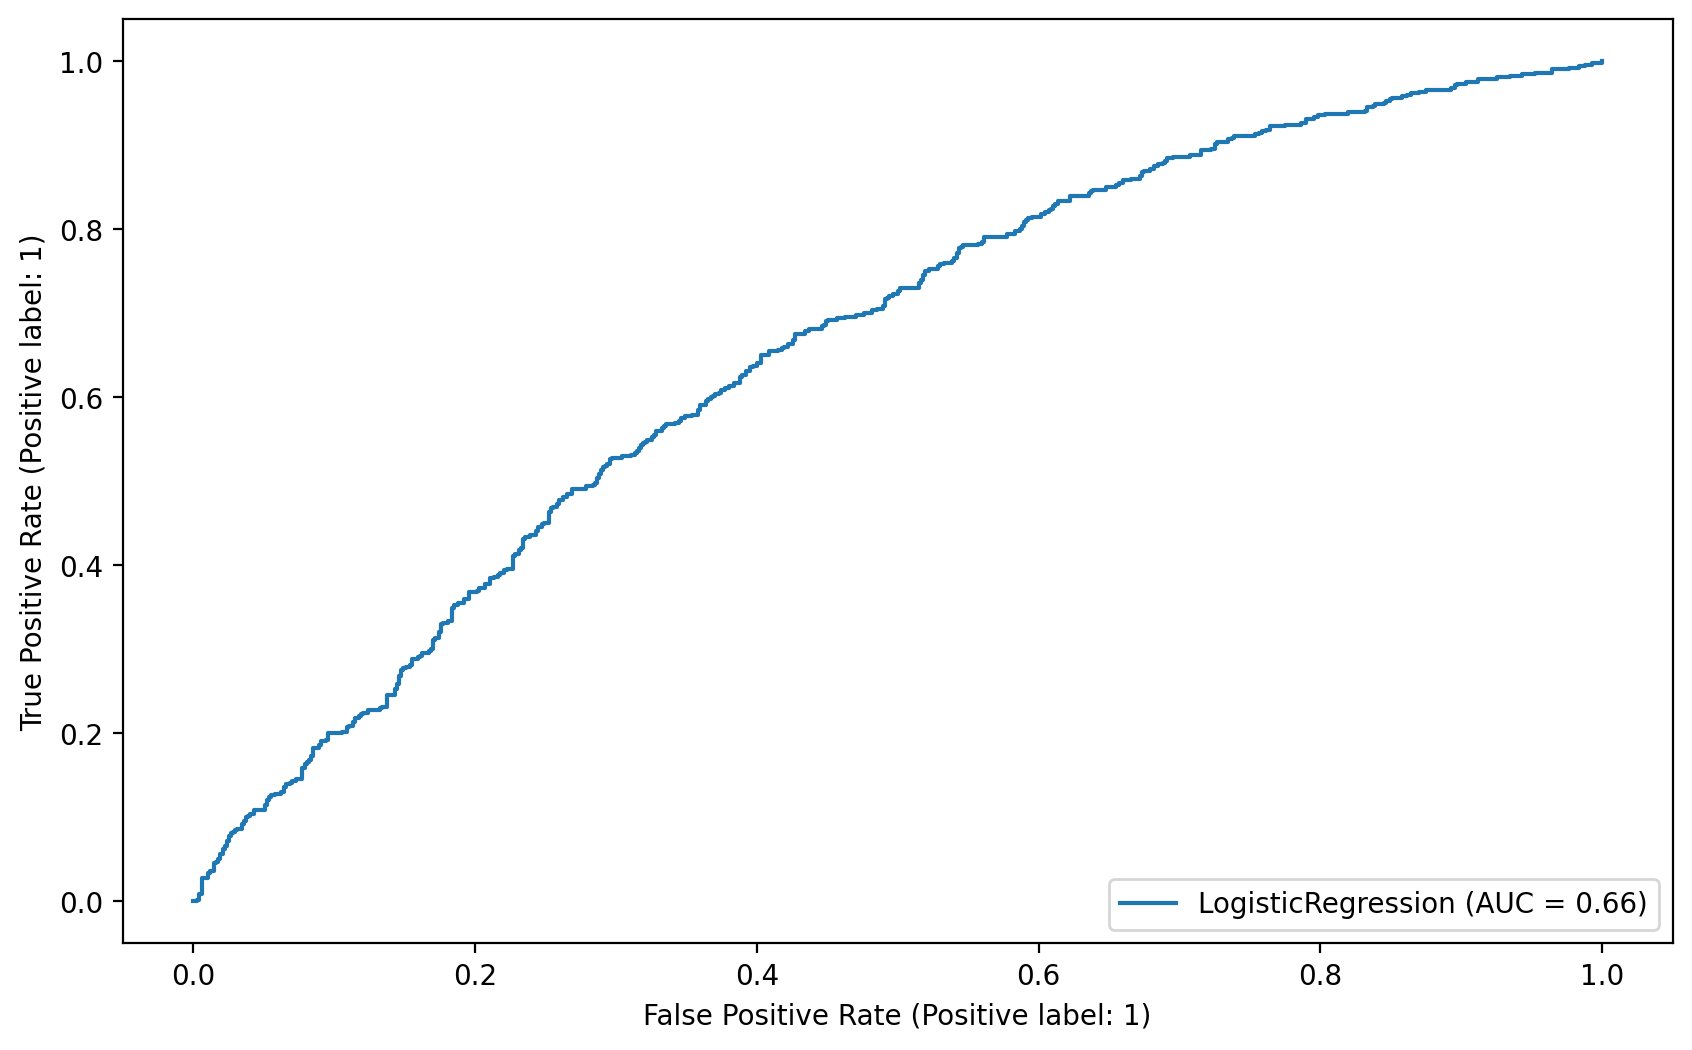

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.56
roc_auc_score: 0.5
precision_score: 0.0
f1_score: 0.0


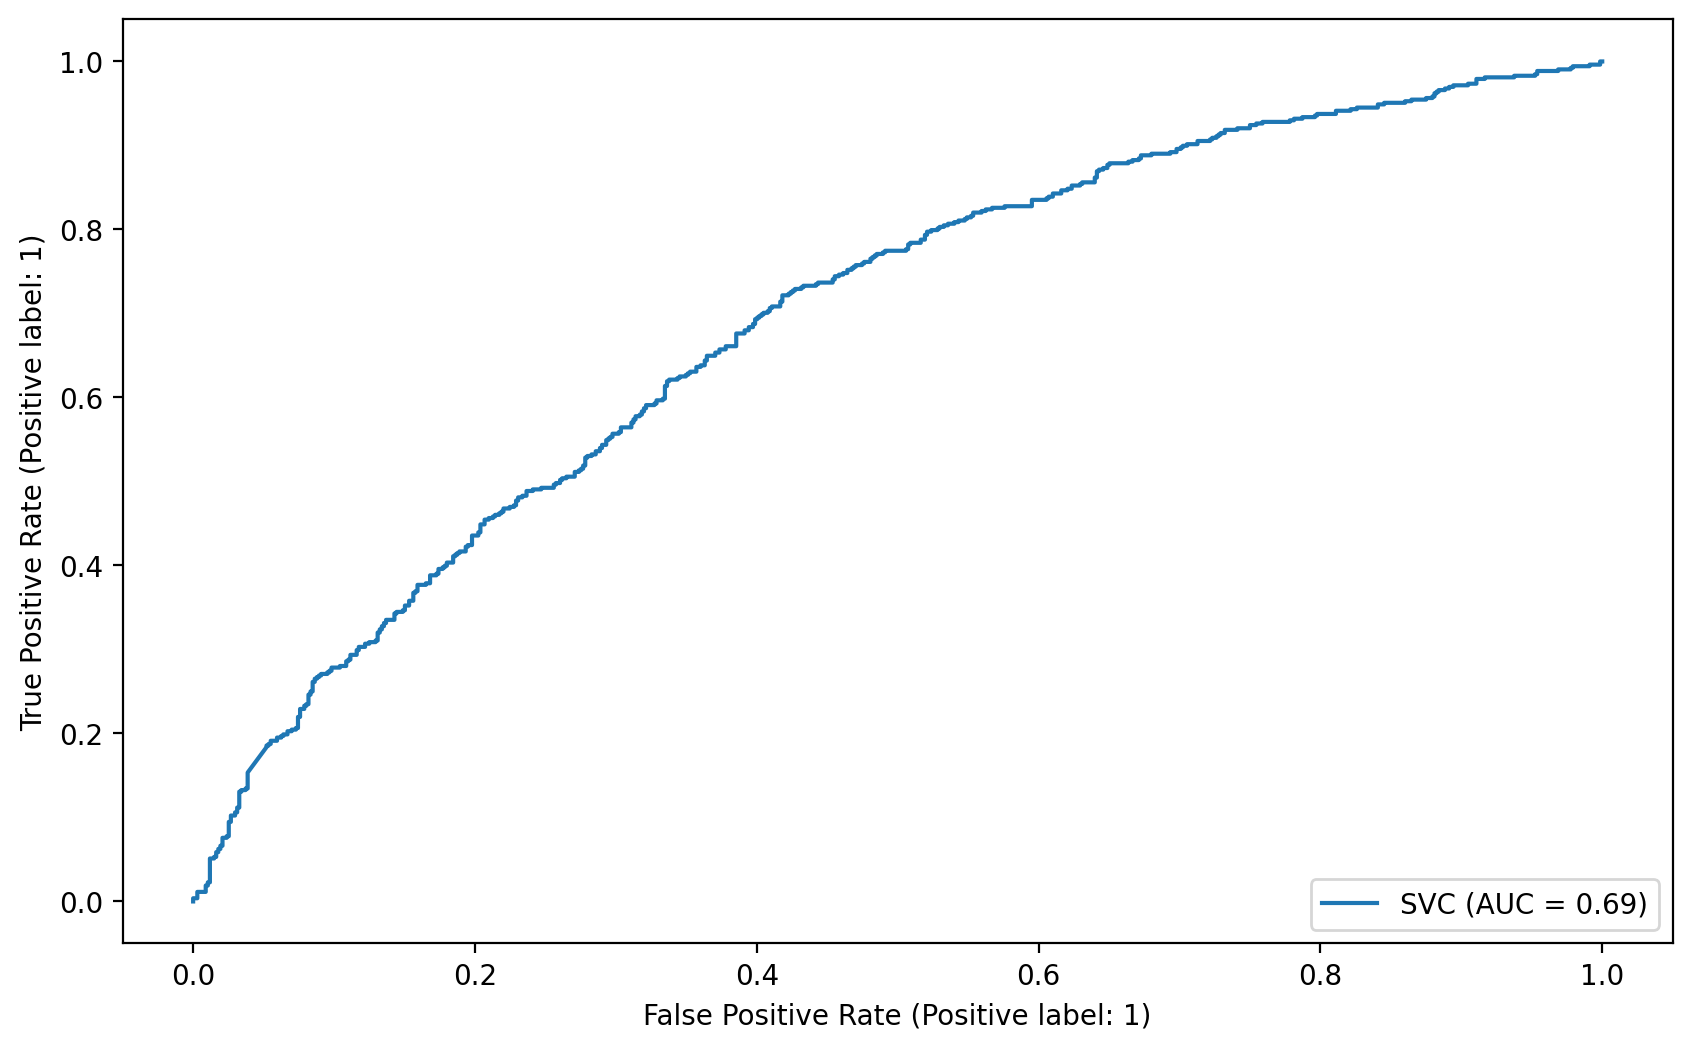

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.6116666666666667
roc_auc_score: 0.5934117965367967
precision_score: 0.5767326732673267
f1_score: 0.5


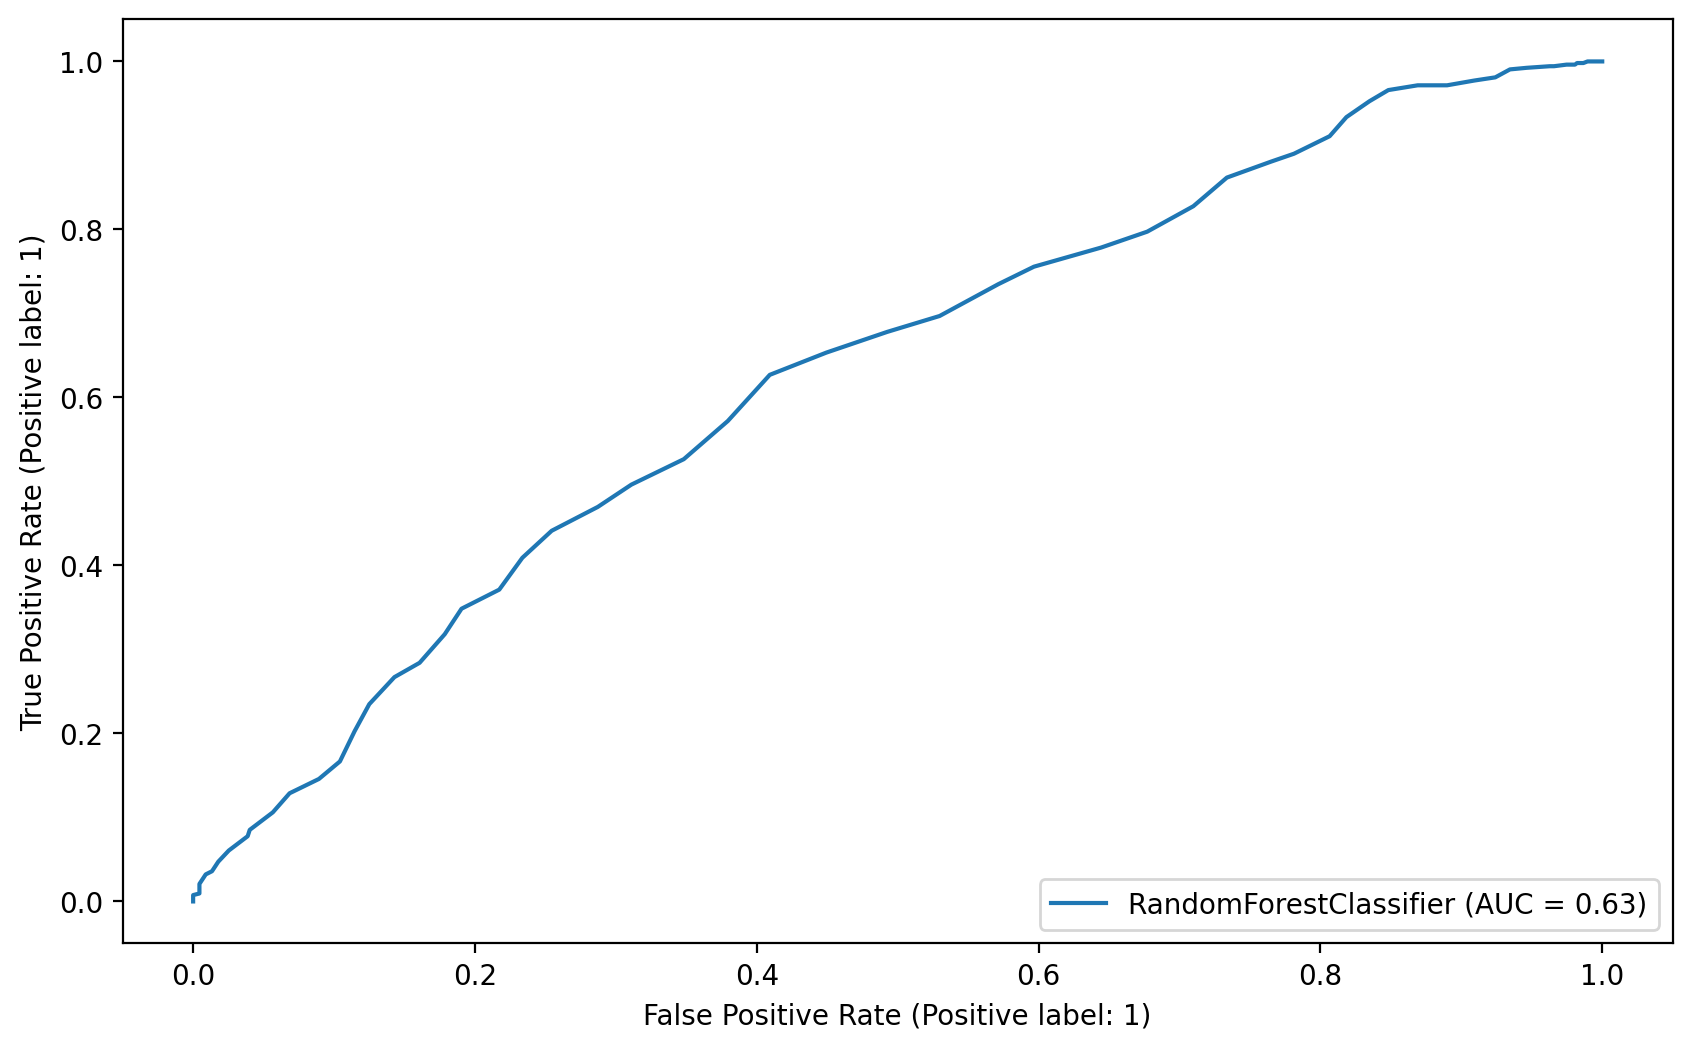

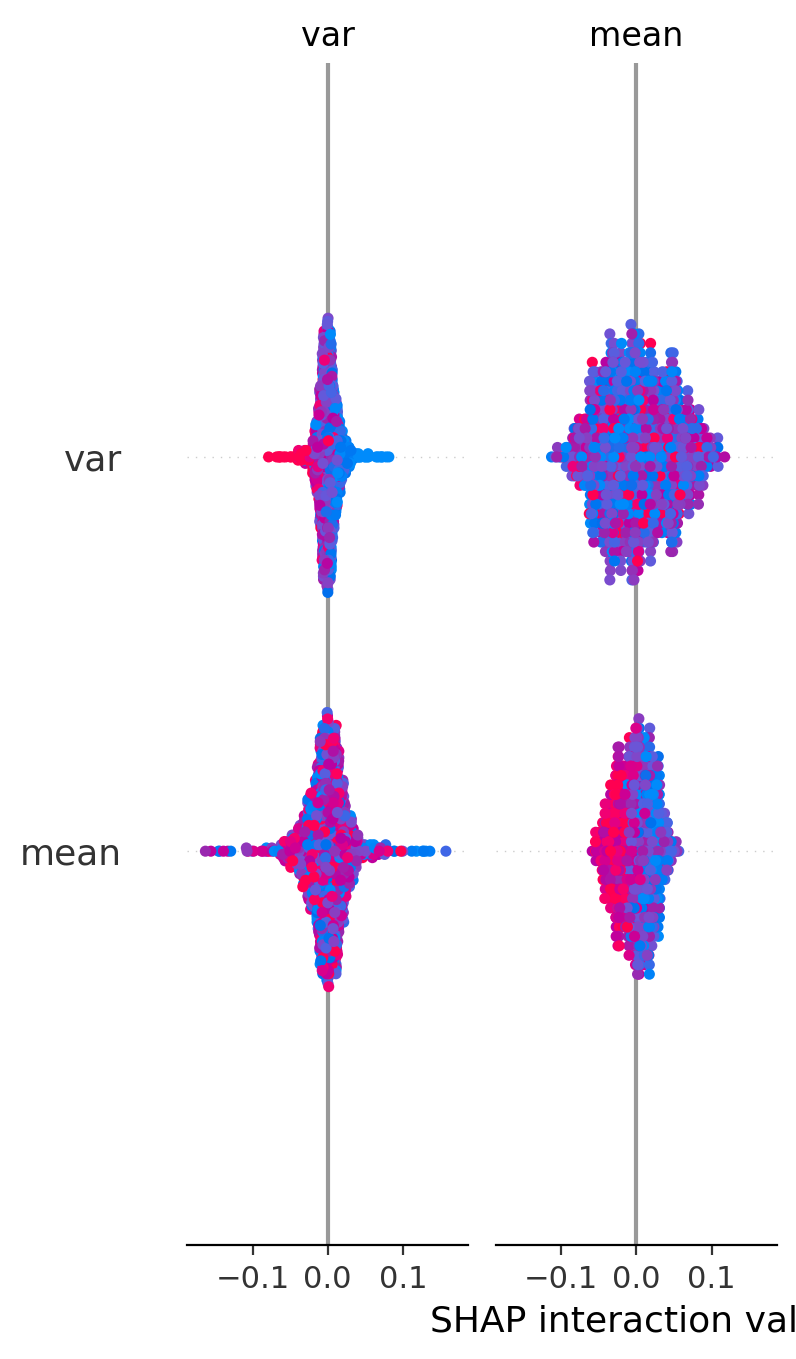

In [ ]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(join_df,0.2,m["model"],m["name"]))

### 2.4.3  Compare results

In [ ]:
compare_model_results(results)